# Practical Data Science: 1st Assignmnet

```
Are you familiar with the proverb "You reap what you sow"?
Enjoy :-)
```
---

> Evangelia P. Panourgia, Master Student in Data Science, AUEB <br />
> Department of Informatics, Athens University of Economics and Business <br />
> eva.panourgia@aueb.gr <br/><br/>

# Setting the Scene 
- For the scope of this assignment, we will need the following python packages:
    - `pandas`: being a fast, powerful, flexible and easy to use open source data analysis and manipulation tool,
built on top of the Python programming language [Documentation Pandas](https://pandas.pydata.org),
    - `os`: offering miscellaneous operating system interfaces [Documentstion os](https://docs.python.org/3/library/os.html),
    - `re`: offering the functionality of regular expressions [Documentation regex](https://pypi.org/project/regex/),
    - `ensure`: being a set of simple assertion helpers that let you write more expressive, literate, concise, and readable Pythonic code [Documentation ensure](https://pypi.org/project/ensure/),
    - `pprint`: being module provides a capability to “pretty-print” [Documentation pprint](https://docs.python.org/3/library/pprint.html), 
    - `matplotlib`: is a comprehensive library for creating static, animated, and interactive visualizations in Python [Documentation Matplotlib](https://matplotlib.org/),
    - `numpy`: offering computational power [Documentation numpy](https://numpy.org)
    - `sklearn`: library for machine elarning purposes [Documentation sklearn](https://scikit-learn.org/stable/)
    - `huggingface_hub` containing many pre-trained open source LLM models and more [Documentation huggingface_hub](https://huggingface.co/docs/huggingface_hub/installation)
    - `Folium`: Folium builds on the data wrangling strengths of the Python ecosystem and the mapping strengths of the Leaflet.js library. [Documentation](https://python-visualization.github.io/folium/latest/)

- Install & Import Python Packages
- To download the needed Python Packages please run the following cell.
    - If you run the Jupyter Notebook in Google Colab, you can skip the following cell, as it has pre-installed python packages.

In [1]:
!pip install pandas ensure matplotlib numpy sklearn huggingface_hub folium

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
    

- Having downloaded our needed python packages, we will import them so as to use them in the following cells.
- Furthermore, we add `alias` in each libarry for easy acess to it.

In [2]:
import pandas as pd 
import os
import re
from ensure import ensure_annotations
import pprint as pp
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import cohen_kappa_score
import re
from collections import Counter
from huggingface_hub import InferenceClient
import folium
from folium.features import DivIcon
from folium import Element
import unicodedata
import re
from collections import Counter
from typing import List, Tuple
from itertools import combinations

/var/folders/br/6xtfsjcd1pld8d58t5wwkmcr0000gn/T/ipykernel_40858/2147869888.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/Users/evangelia/.pyenv/versions/3.10.13/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


- Fine! Having intalled all the needed python libraries, we will move with our two tasks.

# Task A.

# **`A.1.`** Basic: Load the annotation files and compute the probability per emotion per annotator. Visualise it in a single plot.

- Regarding our dataset, we will load multiple `excel` files (being 12 in total)  hosted on the folder `annotations`.
- For this purpose, we wrote the function `load_and_combine_annotations` which "integrates" all of the provided excels following the agreement format.
    - We leveraged `regular expessions` in order to eliminate the reading of files not follow the format: f[ID] or P[ID] where ID is student's ID. This format is given by our professor, adn we used it as constaing to our function.
        - So, we defined the regular expression : `re.compile(r'^[a-zA-Z]\d{7}\.xlsx$')`<br>
    - Regarding the structure of our "integrated" dataframe (named `df_annotations`) we have the following elements: 
        - `ID_Annotator`, being a column created aditionally by us, representing from which annotator (thet is the **source**) coming from a row of our created dataframe. It is helpful for debugginh purposes as well as for the visualization of our task.
        - `text`, being  a given column of the provided seperated excels, representing the sentence(s), the annotator had to lebel.
        - And the folloowing columns that is `Anger`, `Fear`, `Joy`, `Sadness`, `Surprise` represent the columns related to emotions, in which the annotator had to assign either `1` (for having this emotion) or `0` (for not having this emotion).
    - Furthermore, via observing the given seperated excel files, we observed that they contain in the first row the "instructions", and as a result we skipped this line.
        - line of code : `read_options = {'skiprows': 1} if skip_first_row else {}`

In [3]:
@ensure_annotations
def load_and_combine_annotations(
                                folder_path: str = './annotations/', 
                                skip_first_row: bool = True
                                ) -> pd.DataFrame:
    """
    Loads and combines all Excel files from a specified folder that follow the pattern `[letter][7 digits].xlsx`.
    Adds an 'ID_Annotator' column for each file's identifier (filename without the extension).
    
    :param:folder_path (str), path to the folder containing annotation files.
    :param:skip_first_row (bool), If True, skips the first row of each file.
    :return:pd.DataFrame, A combined DataFrame with all annotation data, including an 'ID_Annotator' column.
    """
    
    # Define regex pattern to match filenames like "f1234567.xlsx"
    file_pattern = re.compile(r'^[a-zA-Z]\d{7}\.xlsx$')
    
    # List to store DataFrames for each valid file
    dataframes = []
    
    # Iterate through each file in the specified folder
    for filename in os.listdir(folder_path):
        print(filename)
        if file_pattern.match(filename):
            # Extract the index part (e.g., "f1234567" from "f1234567.xlsx")
            index_name = filename.split('.')[0]
            
            # Construct full file path
            file_path = os.path.join(folder_path, filename)
            
            # Define options for reading the file
            # Skip the first line of each "excel" file (meaning skip the Instructions). 
            read_options = {'skiprows': 1} if skip_first_row else {}
            
            # Load the Excel file
            df = pd.read_excel(file_path, **read_options)
            
            # Insert 'ID_Annotator' column with the file's identifier
            df.insert(0, 'ID_Annotator', index_name)
            
            # Add the DataFrame to our list
            dataframes.append(df)
    
    # Concatenate all individual DataFrames into a single DataFrame
    combined_df = pd.concat(dataframes)
    
    return combined_df

# Usage example
df_annotations = load_and_combine_annotations() # call the function 
df_annotations_copy = df_annotations.copy()
df_annotations # preview ou data frame 

f3352404.xlsx
f3352405.xlsx
p3210105.xlsx
f3352409.xlsx
f3352402.xlsx
f3352316.xlsx
f3352403.xlsx
f3352401.xlsx
f3352406.xlsx
f3352410.xlsx
f3352407.xlsx
p3352313.xlsx


,ID_Annotator,id,text,Anger,Fear,Joy,Sadness,Surprise
0,f3352404,eng_dev_track_a_00001,"My mouth fell open `` No, no, no... I..",0.0,1.0,0.0,0.0,1.0
1,f3352404,eng_dev_track_a_00002,You can barely make out your daughter's pale f...,0.0,1.0,0.0,0.0,0.0
2,f3352404,eng_dev_track_a_00003,But after blinking my eyes for a few times lep...,0.0,0.0,0.0,0.0,1.0
3,f3352404,eng_dev_track_a_00004,Slowly rising to my feet I came to the conclus...,0.0,0.0,0.0,1.0,0.0
4,f3352404,eng_dev_track_a_00005,I noticed this months after moving in and doin...,1.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...
111,p3352313,eng_dev_track_a_00112,"""ARcH stop your progression.",0.0,0.0,0.0,0.0,0.0
112,p3352313,eng_dev_track_a_00113,"This 'star', starts to move across the sky.",0.0,0.0,0.0,0.0,1.0
113,p3352313,eng_dev_track_a_00114,and my feet hurt.,0.0,1.0,0.0,0.0,0.0
114,p3352313,eng_dev_track_a_00115,so i cried my eyes out and did the drawing.,0.0,0.0,0.0,1.0,0.0


- Having loaded, our seperated excels in the following cells, we will both test if our data loaded correctly and we will implement basic data exploration.
- Firslty, We will remove the column `id` as it is useless to our analysis.

In [4]:
print(f"The Columns of our datasframe are: {list(df_annotations.columns)}") # preview "exact" names of the columns 
df_annotations.drop(columns=["id"], inplace=True)#remove the useless column "id"
print(f"The Column Id successfully deleyed as: {list(df_annotations.columns)}") # preview "exact" names of the columns 

The Columns of our datasframe are: ['ID_Annotator', 'id', 'text', 'Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']
The Column Id successfully deleyed as: ['ID_Annotator', 'text', 'Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']


- Via oppening a random excel file (e.g.f3352404.xlsx), we oberved that it contains `116 rows` of sentences with lebeling in emotions. 
- So, having this in mind, we wait teh total number of our "integrated" data frame has a total number of rows equally to 12 (total excel files) * 116 (examined rows of each seperated) data frame. So, (12)*(116)=**1392** total number of rows for our "integrated" dataframe (being `df_annotations`).
- For this purpose, firstly, via using the pandas.shape,we will find the total number of rows of our generated dataframe and pandas.function : `value_counts()`, we will see how many rows contain each seperate excel.

In [5]:
total_number_of_annotators = len(df_annotations['ID_Annotator'].value_counts())
print(f"The total number of roes of our data frame is : {df_annotations.shape[0]}")
print(f'The total number of annotators is {total_number_of_annotators}')
df_annotations['ID_Annotator'].value_counts()

The total number of roes of our data frame is : 1392
The total number of annotators is 12


ID_Annotator
f3352404    116
f3352405    116
p3210105    116
f3352409    116
f3352402    116
f3352316    116
f3352403    116
f3352401    116
f3352406    116
f3352410    116
f3352407    116
p3352313    116
Name: count, dtype: int64

- Fine, we observe that all excel have the expected total number of rows that is `116`. We, also, observed that the total number of our generated dataframe has total number equally to `1392`.
- Furthermore, a;; seperated files loaded that is `12` in total.
- So, from a genaral analysis, the loaded of excels seem to be correct.

In [6]:
total_number_of_annotators = len(df_annotations['ID_Annotator'].value_counts())
total_number_of_annotators

12

- For, more in depth analysis, we will check if each of the sentences in column `text` of our dataframe is used 12 times. 
- For this purpose, we will create a dictionary wit `key` being the value of the columns `text` of our dataframe and `value` being the and int number showing how many times this instance found in our "intagrated" data frame.
- We wait to see 12 as valu in all keys. 

In [7]:
dict_debug_load_and_combine_annotations = dict(df_annotations['text'].value_counts())
different_values = {key: value for key, value in dict_debug_load_and_combine_annotations.items() if value != 12} # Filter keys with values not equal to 12
different_values # preview the filtered dictionary 


{'This was fairly recently...': 11, 'This was fairly recently…': 1}

- From the result of the filtered dictionary, we can conclude that maybe an annotaror changed a given sentence from `'This was fairly recently...'` to `'This was fairly recently…'`
- So, we will change it with the corect format for full stop that is `...`

In [8]:
df_annotations['text'] = df_annotations['text'].replace('This was fairly recently…', 'This was fairly recently...')
# let's preview ig our change passed 
dict_debug_load_and_combine_annotations = dict(df_annotations['text'].value_counts())
different_values = {key: value for key, value in dict_debug_load_and_combine_annotations.items() if value != 12} # Filter keys with values not equal to 12
different_values # preview the filtered dictionary 

{}

- Fine, our change passed, as the filtered diictioanry is empty. 
- Now, we will check that the columns related to emotions contain value `0`, `1`, 
- For this purpoge we will use the function `unique()` of pandas.

In [9]:
df_annotations['Anger'].unique()

array([ 0.,  1., nan])

- Ooops, we have a thord values being nan indicating the exitance of "missing" values. 
- Before handling it let's check for the other emptipn columns. 

In [10]:
df_annotations[df_annotations['Anger'].isnull()]

,ID_Annotator,text,Anger,Fear,Joy,Sadness,Surprise
57,f3352406,"We had obviously done this before, but this ti...",NaN,NaN,NaN,NaN,NaN


In [11]:
df_annotations[df_annotations['Fear'].isnull()]

,ID_Annotator,text,Anger,Fear,Joy,Sadness,Surprise
57,f3352406,"We had obviously done this before, but this ti...",NaN,NaN,NaN,NaN,NaN


In [12]:
df_annotations[df_annotations['Joy'].isnull()]

,ID_Annotator,text,Anger,Fear,Joy,Sadness,Surprise
57,f3352406,"We had obviously done this before, but this ti...",NaN,NaN,NaN,NaN,NaN


In [13]:
df_annotations[df_annotations['Sadness'].isnull()]

,ID_Annotator,text,Anger,Fear,Joy,Sadness,Surprise
53,f3352404,After standing in a few times in the past his ...,0.0,1.0,0.0,NaN,0.0
57,f3352406,"We had obviously done this before, but this ti...",NaN,NaN,NaN,NaN,NaN


- For the emotion `Sadness` we hame more missing values 

In [14]:
df_annotations[df_annotations['Surprise'].isnull()]

,ID_Annotator,text,Anger,Fear,Joy,Sadness,Surprise
57,f3352406,"We had obviously done this before, but this ti...",NaN,NaN,NaN,NaN,NaN


- We observe tha the annptator with ID `f3352406` maybe forgot to foill the whole line 
- Whereas the annoteror with ID `f3352404` forgot to fill one value for the emotion "Sadness"
- There are many "strategies" to fill missing values or even to remove.
- We decided for the current sentence to find the most common "lebel" for each emotion using the remaining sub-excels; meaning the values of other annotators.
    - Based of the logic of the current dataset, a text is a data that based on the meaning so we suppose that the most people "understand" a sentence causing anger or surprise etc. 

In [15]:
# fetch the "text" detected the missing values 
print(list(df_annotations.loc[57, 'text'])[0]) # 57 being the index found the missing values 
print(list(df_annotations.loc[53, 'text'])[0]) # 53 being the index found the missing values 

We had obviously done this before, but this time something was different.
After standing in a few times in the past his buddy asks again but warns him that it is the full moon and it won't be like the last times.


- Case 1: Filter for the sentence "We had obviously done this before, but this time something was different."

In [16]:
# Case 1: Filter for the sentence "We had obviously done this before, but this time something was different." and remove the annotation of the annotator "forgot" to label.
case_1_df_fill_missing_values_of_annotator_f3352406 = df_annotations[(df_annotations['text'] == list(df_annotations.loc[57, 'text'])[0]) & (df_annotations['ID_Annotator'] != 'f3352406')]
case_1_df_fill_missing_values_of_annotator_f3352406

,ID_Annotator,text,Anger,Fear,Joy,Sadness,Surprise
57,f3352404,"We had obviously done this before, but this ti...",0.0,0.0,0.0,1.0,0.0
57,f3352405,"We had obviously done this before, but this ti...",0.0,0.0,1.0,0.0,1.0
57,p3210105,"We had obviously done this before, but this ti...",0.0,0.0,0.0,0.0,1.0
57,f3352409,"We had obviously done this before, but this ti...",0.0,0.0,0.0,0.0,1.0
57,f3352402,"We had obviously done this before, but this ti...",0.0,0.0,0.0,0.0,1.0
57,f3352316,"We had obviously done this before, but this ti...",0.0,1.0,0.0,0.0,1.0
57,f3352403,"We had obviously done this before, but this ti...",0.0,1.0,1.0,0.0,1.0
57,f3352401,"We had obviously done this before, but this ti...",0.0,0.0,0.0,0.0,1.0
57,f3352410,"We had obviously done this before, but this ti...",0.0,0.0,0.0,0.0,1.0
57,f3352407,"We had obviously done this before, but this ti...",0.0,0.0,0.0,0.0,1.0


- The dataframe `case_1_df_fill_missing_values_of_annotator_f3352406` shows the values of all annotators **except** the annotator with ID  f3352406 for the sentence `We had obviously done this before, but this time something was different.`
- Having this data frame at our disposal, we will calculate the **mode** for each of the emotion columns as the annotator `f3352406` forgot for all of the columns to assign values (that is 0 , 1). 

In [17]:
# Initialize a list for storing the values to fill the missing values.
list_fill_case_1 = []

In [18]:
list_fill_case_1 = [list(case_1_df_fill_missing_values_of_annotator_f3352406['Anger'].mode())[0]] + \
                   [list(case_1_df_fill_missing_values_of_annotator_f3352406['Fear'].mode())[0]] + \
                   [list(case_1_df_fill_missing_values_of_annotator_f3352406['Joy'].mode())[0]] + \
                   [list(case_1_df_fill_missing_values_of_annotator_f3352406['Sadness'].mode())[0]] + \
                   [list(case_1_df_fill_missing_values_of_annotator_f3352406['Surprise'].mode())[0]]

list_fill_case_1 # preview the list cotnianing the modes for each emotion. 

[0.0, 0.0, 0.0, 0.0, 1.0]

- So, for the Annotator with ID `f3352406` FOR THE `text` column with value `We had obviously done this before, but this time something was different.` we will fill the columns related to the emotions with the following values : 
    - For `Anger` fill with `0`
    - For `Fear` fill with `0`
    - For `Joy` fill with `0`
    - For `Sadness` fill with `0`
    - For `Surprise` fill with `1`

In [19]:
# Assign values to specific columns based on conditions in 'ID_Annotator' and 'text'
df_annotations.loc[
    (df_annotations['ID_Annotator'] == 'f3352406') & 
    (df_annotations['text'] == "We had obviously done this before, but this time something was different."),
    ['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']
] = list_fill_case_1


In [20]:
df_annotations[(df_annotations['ID_Annotator'] == 'f3352406') & (df_annotations['text'] == "We had obviously done this before, but this time something was different.")] 

,ID_Annotator,text,Anger,Fear,Joy,Sadness,Surprise
57,f3352406,"We had obviously done this before, but this ti...",0.0,0.0,0.0,0.0,1.0


- Fine, regarding the first ase of missing values we handled it. 
- Now, we want to handle for the annotator with ID `f3352404` the missing value in the column `Sadness` for the `text`: `After standing in a few times in the past his buddy asks again but warns him that it is the full moon and it won't be like the last times.`
- We decede similarly to replace with the mode value based on the values of other annotators except the annotator `f3352404`.

In [21]:
df_annotations[df_annotations['Sadness'].isnull()]

,ID_Annotator,text,Anger,Fear,Joy,Sadness,Surprise
53,f3352404,After standing in a few times in the past his ...,0.0,1.0,0.0,NaN,0.0


In [22]:
case_2_df_fill_missing_values_of_annotator_f3352405 = df_annotations[(df_annotations['text'] == list(df_annotations.loc[53, 'text'])[0]) & (df_annotations['ID_Annotator'] != 'f3352404')]
case_2_df_fill_missing_values_of_annotator_f3352405

,ID_Annotator,text,Anger,Fear,Joy,Sadness,Surprise
53,f3352405,After standing in a few times in the past his ...,0.0,1.0,0.0,0.0,1.0
53,p3210105,After standing in a few times in the past his ...,0.0,1.0,1.0,0.0,1.0
53,f3352409,After standing in a few times in the past his ...,0.0,0.0,0.0,1.0,0.0
53,f3352402,After standing in a few times in the past his ...,0.0,0.0,0.0,1.0,0.0
53,f3352316,After standing in a few times in the past his ...,0.0,0.0,0.0,0.0,0.0
53,f3352403,After standing in a few times in the past his ...,1.0,0.0,0.0,0.0,0.0
53,f3352401,After standing in a few times in the past his ...,0.0,0.0,0.0,0.0,0.0
53,f3352406,After standing in a few times in the past his ...,0.0,1.0,0.0,0.0,0.0
53,f3352410,After standing in a few times in the past his ...,0.0,1.0,0.0,0.0,0.0
53,f3352407,After standing in a few times in the past his ...,0.0,1.0,0.0,1.0,0.0


In [23]:
# calculate mode for the column Sadness
list(case_2_df_fill_missing_values_of_annotator_f3352405['Sadness'].mode())[0]

0.0

- Now, we will assign `0` in order to fill the missing value. 

In [24]:
df_annotations.loc[
    (df_annotations['ID_Annotator'] == 'f3352404') & 
    (df_annotations['text'] == "After standing in a few times in the past his buddy asks again but warns him that it is the full moon and it won't be like the last times."),
    ['Sadness']
] = list(case_2_df_fill_missing_values_of_annotator_f3352405['Sadness'].mode())[0]

- Now, we will check for missing values and data types.
- We will use the function `info()` of pandas, as it contains both.

In [25]:
df_annotations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1392 entries, 0 to 115
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID_Annotator  1392 non-null   object 
 1   text          1392 non-null   object 
 2   Anger         1392 non-null   float64
 3   Fear          1392 non-null   float64
 4   Joy           1392 non-null   float64
 5   Sadness       1392 non-null   float64
 6   Surprise      1392 non-null   float64
dtypes: float64(5), object(2)
memory usage: 119.3+ KB


- We observe that we don't have missing values as all non-null are equal to the total number of our df rows tha tis 1392. 
- The data types are `object` for the columns ID_Annotator, text and `float64` for the remaining ones.
- We will convert the first data type to `string` and the second one to `int` (binary data).

In [26]:
df_annotations.columns

Index(['ID_Annotator', 'text', 'Anger', 'Fear', 'Joy', 'Sadness', 'Surprise'], dtype='object')

In [27]:
# from object ---> string 
df_annotations['ID_Annotator'] = df_annotations['ID_Annotator'].astype('string')
df_annotations['text'] = df_annotations['text'].astype('string')

# from float64 ---> int 
df_annotations['Anger'] = df_annotations['Anger'].astype(int)
df_annotations['Fear'] = df_annotations['Fear'].astype(int)
df_annotations['Joy'] = df_annotations['Joy'].astype(int)
df_annotations['Sadness'] = df_annotations['Sadness'].astype(int)
df_annotations['Surprise'] = df_annotations['Surprise'].astype(int)

df_annotations.info() #check if our change passed 

<class 'pandas.core.frame.DataFrame'>
Index: 1392 entries, 0 to 115
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID_Annotator  1392 non-null   string
 1   text          1392 non-null   string
 2   Anger         1392 non-null   int64 
 3   Fear          1392 non-null   int64 
 4   Joy           1392 non-null   int64 
 5   Sadness       1392 non-null   int64 
 6   Surprise      1392 non-null   int64 
dtypes: int64(5), string(2)
memory usage: 119.3 KB


In [28]:
df_annotations.head(10)

,ID_Annotator,text,Anger,Fear,Joy,Sadness,Surprise
0,f3352404,"My mouth fell open `` No, no, no... I..",0,1,0,0,1
1,f3352404,You can barely make out your daughter's pale f...,0,1,0,0,0
2,f3352404,But after blinking my eyes for a few times lep...,0,0,0,0,1
3,f3352404,Slowly rising to my feet I came to the conclus...,0,0,0,1,0
4,f3352404,I noticed this months after moving in and doin...,1,1,0,1,1
5,f3352404,"I know not why, I wipe my face.",0,1,1,1,0
6,f3352404,It was rather insulting.,1,0,0,0,0
7,f3352404,"I was born without the compassion chromosome, ...",0,0,0,1,0
8,f3352404,; ) In the evening we did go down and put our ...,0,0,1,0,1
9,f3352404,I feel like I am in over my head... Like Quick...,0,1,0,1,0


- In addition, we will sort our data frame to follow the given order of the given excel files. 

In [29]:
# df_annotations = df_annotations.sort_values(by='ID_Annotator')#here 

- Fine. Now we are reafdy to start with the calcualtion of prior probability. 
- The following cell calculates the prior probability of each emotion per annotator by grouping the data in `df_annotations` by `ID_Annotator` and averaging the binary values in each emotion column (`Anger`, `Fear`, `Joy`, `Sadness`, `Surprise`). 
- The resulting DataFrame, `prior_probabilities_per_annotator_per_emotion`, provides the probability that each annotator marks an emotion as present across all their annotations, giving insight into individual labeling tendencies.
- Genrally, the prior probability of an event \( A \) (in our case emotion) is defined as:

$$
P(A) = \frac{\text{Number of occurrences of } A}{\text{Total number of outcomes}}
$$
where:

- **Number of occurrences of \( A \)**: The number of times the event has been observed to occur.
- **Total number of outcomes**: The total number of possible outcomes or trials observed.


In [30]:
prior_probabilities_per_annotator_per_emotion = df_annotations.groupby("ID_Annotator")[["Anger", "Fear", "Joy", "Sadness", "Surprise"]].mean() # we leverage binary data and we use "mean".
prior_probabilities_per_annotator_per_emotion # preview prop probability calculations

,Anger,Fear,Joy,Sadness,Surprise
ID_Annotator,,,,,
f3352316,0.198276,0.172414,0.120690,0.224138,0.120690
f3352401,0.077586,0.189655,0.112069,0.206897,0.275862
f3352402,0.103448,0.146552,0.137931,0.543103,0.189655
f3352403,0.241379,0.284483,0.310345,0.405172,0.275862
f3352404,0.258621,0.379310,0.181034,0.258621,0.224138
f3352405,0.250000,0.232759,0.241379,0.336207,0.405172
f3352406,0.163793,0.250000,0.155172,0.293103,0.241379
f3352407,0.318966,0.232759,0.189655,0.439655,0.181034
f3352409,0.310345,0.405172,0.206897,0.629310,0.224138


- Now, using `matplotlib` we  will plot our data.
- We will adapt the setting for better appearance.

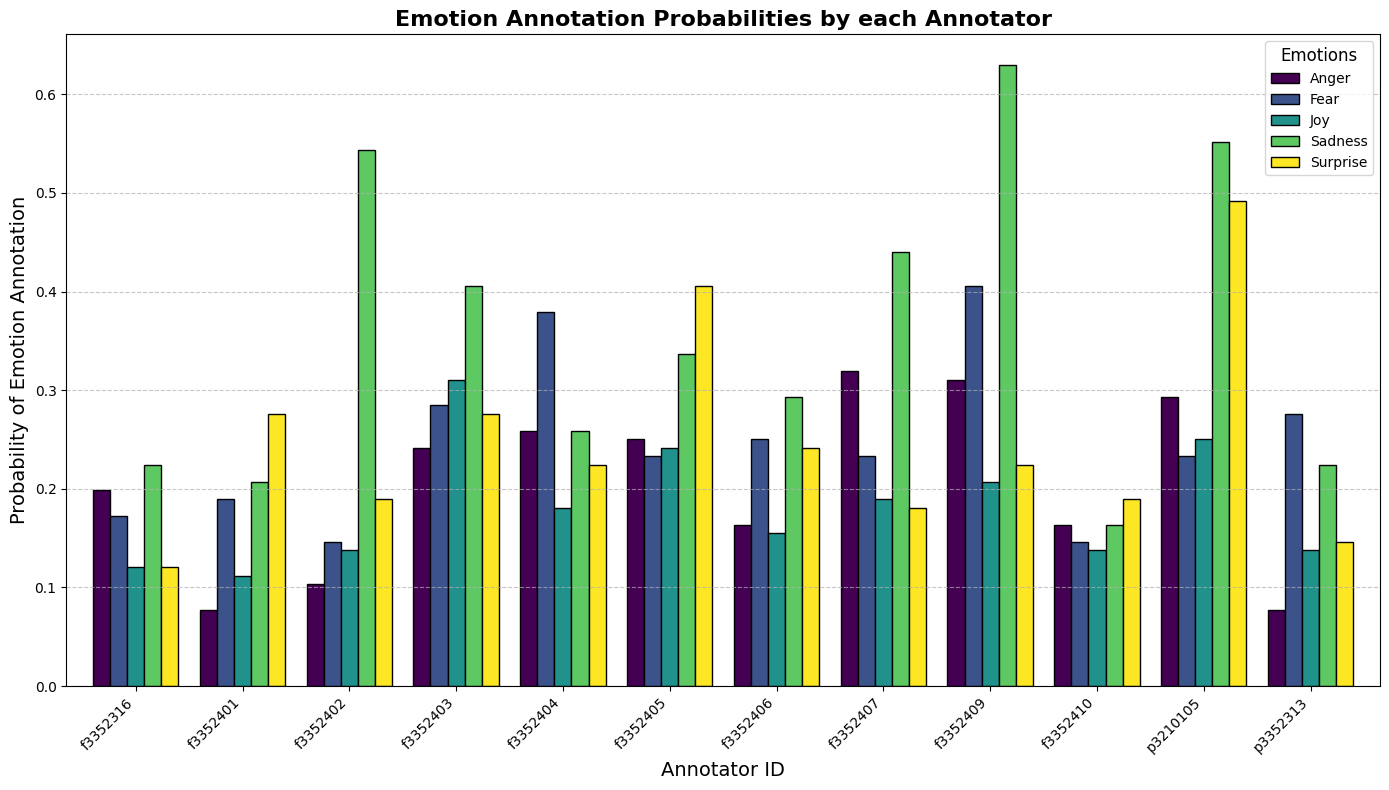

In [31]:
# Plotting
ax = prior_probabilities_per_annotator_per_emotion.plot(kind="bar", figsize=(14, 8), width=0.8, edgecolor="black", colormap="viridis")

# Enhancing plot details for professionalism
ax.set_title("Emotion Annotation Probabilities by each Annotator", fontsize=16, fontweight="bold")
ax.set_xlabel("Annotator ID", fontsize=14)
ax.set_ylabel("Probability of Emotion Annotation", fontsize=14)
ax.legend(title="Emotions", title_fontsize=12, fontsize=10)
ax.grid(axis="y", linestyle="--", alpha=0.7)  # Adding a light grid for readability

# Rotating x-axis labels and setting layout
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Display the plot
plt.show()


- Comments for our generated plot: 
- Emotion Annotation Probabilities by Annotator
    - This plot illustrates the probability of each emotion being annotated by various annotators, identified by their unique IDs on the x-axis. 
    - Each annotator has a set of colored bars representing different emotions (Anger, Fear, Joy, Sadness, and Surprise), with the y-axis indicating the probability of each emotion annotation.


- Key Observations:
    - **Varied Annotation Patterns**: Some annotators show a balanced distribution across emotions, while others exhibit higher probabilities for specific emotions. For example, annotators with IDs ending in 316 and 401 have a more even spread, whereas annotators like those ending in 402 and 409 show a strong tendency toward `Sadness`.
    - **Dominant Emotions**: Certain annotators are more likely to annotate particular emotions, with `Sadness` and `Surprise` appearing more frequently. Conversely, emotions like `Anger` and `Fear` and `Joy` generally have lower probabilities, suggesting they are less frequently labeled.
    - **Insights on Annotator Behavior**: This visualization helps in assessing annotator consistency and may reveal individual tendencies or biases in emotion labeling.

- This plot provides a quick and clear overview of each annotator's tendencies in labeling emotions, which is valuable for evaluating the consistency and potential biases in emotion annotation data.


# `A2` IAA: Compute the pairwise inter-annotator agreement, using both Cohen's kappa and percentage agreeemnt. Compare the two and discuss any differences. Visualise the best of the two using a table of agreement with a heatmap.

- Because our assignmnt doesn't define the `overall` or `per emotion agreemnt`, we decided to calculate the percentage agreemnt and kappa `**per** emotions`. 
- This choice provides insights into **how consistently annotators** identify each specific emotion.
- `High Agreement`: A high Kappa or percentage agreement for an emotion (e.g., sadness) means annotators are consistently able to recognize that emotion in the sentences. 
    - This suggests that the emotion is relatively straightforward to identify, either because it’s strongly present or has clear indicators.
- Low Agreement: Low agreement for an emotion (e.g., surprise) suggests that annotators may interpret it differently, either due to subtleties in the text or ambiguity in what constitutes that emotion. 
    - This could mean that the emotion is less explicit or harder to detect.
- High agreement on some emotions but not others implies that the annotation instructions or guidelines may need refinement for the emotions with low agreement. 
    - For instance, annotators may need clearer definitions or examples of what constitutes "surprise" if that emotion has lower agreement.
- So, the choice it depends on what the annotator team wants to imrpove or focus on. We assume tha twe want to focus on the behaviour of our annoattors per emotion.
- Before calculating each metric we will check the `prior probability` pew emotion for all annotators in order to have an overall vie of the distribution of our emotion categories. 

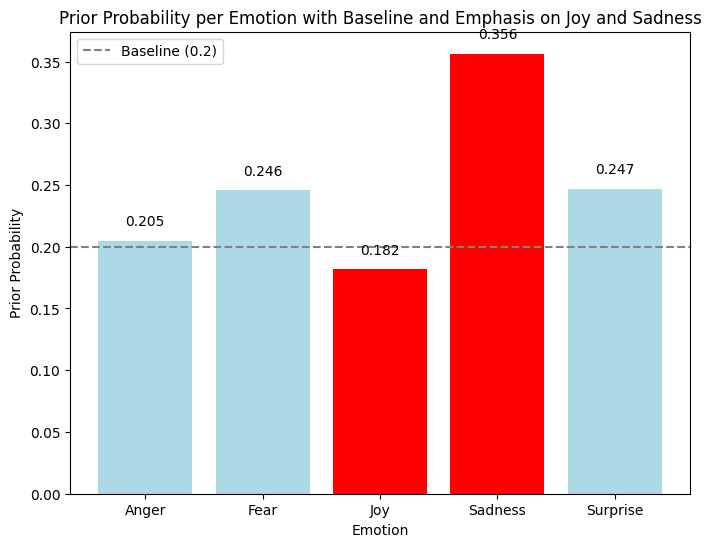

In [32]:
#  prior probability per emotion 
# Calculate the mean for each emotion column to get the prior probabilities
prior_probabilities_per_emotion = df_annotations[["Anger", "Fear", "Joy", "Sadness", "Surprise"]].mean()
dict_prior_probability_per_emotion = dict(prior_probabilities_per_emotion)

#plot 
# Colors for emphasis: Joy and Sadness in red
colors = ['red' if emotion in ['Joy', 'Sadness'] else 'lightblue' for emotion in dict_prior_probability_per_emotion.keys()]
# Plotting histogram
plt.figure(figsize=(8, 6))
bars = plt.bar(dict_prior_probability_per_emotion.keys(), dict_prior_probability_per_emotion.values(), color=colors)
# Adding baseline at 0.2
plt.axhline(y=0.2, color='gray', linestyle='--', linewidth=1.5, label='Baseline (0.2)')
# Adding data labels above each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{yval:.3f}', ha='center', va='bottom')
# Titles and labels
plt.xlabel('Emotion')
plt.ylabel('Prior Probability')
plt.title('Prior Probability per Emotion with Baseline and Emphasis on Joy and Sadness')
plt.legend()

plt.show()

- The prior probabilities for each emotion range from about 0.18 (Joy) to 0.36 (Sadness), indicating that some emotions (e.g., Sadness) are ** more frequent** than others (e.g., Joy).
- In **a balanced distribution**, we’d expect all emotions to have roughly similar prior probabilities, ideally around (1/5)=**0.2** (since there are 5 emotions). 
    -Here, however, Sadness has a higher baseline, while Joy is under-represented. The difrence is not extemely high but it exists a kind of imbalance. 
- `Joy` and `Sadness` being with red present the highest and lowest values respectively. 
- **Note**: Our choice `per emotion` may be better than the overall calculation of %agreement and kappa due to this imbalance. 
    - With imbalanced data, it’s better to calculate agreement per emotion because it reveals how consistently annotators identify each specific emotion, especially rare ones (e.g. Joy). 
    - Overall agreement can be skewed by frequently labeled emotions (like "Sadness"), masking low reliability on less frequent emotions (like "Joy").

- Before delving into the calculations, firslty we will apply a validation check to ensure that each anotator labeled the sentences in the same order 
- this is **crusial assumption** for our calcualtions for %agreement and kappa.

In [33]:
list_all_anotators_ID = df_annotations.ID_Annotator.to_list()

In [34]:
list_text_value_f3352316 = df_annotations[df_annotations['ID_Annotator']=='f3352316'].text.tolist()
# pp.pp(len(list_text_value_f3352316))
# for each other annotator i want to ensure that the values of its sub datafarem are the same with that annoattor "f3352316"
validation_list = []
for id_annotator in list_all_anotators_ID: 
    list_text_value = df_annotations[df_annotations['ID_Annotator']==id_annotator].text.tolist()
    validation_list.append(list_text_value_f3352316==list_text_value)
[value for value in validation_list if not value] # only return valeusof list having False 

[]

- Fine the order verifred, now, we will move with the calculations  
- The `calculate_pairwise_percentage_agreement` function calculates the pairwise percentage agreement between annotators across specified emotion column(s). In our case each column pass each time because we want to calculate `per` emotion. 
    - First, it extracts the unique annotators and initializes a DataFrame to store percentage agreements between each annotator pair. 
    - For each pair, it filters and aligns the data on emotion labels, compares each annotator’s labels across all emotion columns, and calculates the percentage of agreement for each pair rangeing from `0 to 1` (in order to be coparable with kappa_score) , rounding it to two decimal places. 
    - This result is stored in the `percentage_agreement` matrix, with perfect self-agreement 1 (meaning 100%) filled along the diagonal. 
    - Finally, any missing values are replaced with `"-"` for readability, and the function returns the completed percentage agreement matrix.
* Note, we did **not** present the result in  **percentage** in order to be `comparable` to kappa calculations.

In [35]:
@ensure_annotations
def calculate_pairwise_percentage_agreement(df_annotations:pd.DataFrame, 
                                            id_col : str = "ID_Annotator", 
                                            emotion_cols:list = None
                                           ) -> pd.DataFrame:
    """
    Calculates the pairwise percentage agreement between annotators across specified emotion column(s).
    
    :params: df_annotations (pd.DataFrame): DataFrame containing annotator IDs and emotion labels.
    :params: Column name for annotator IDs.
    :params: emotion_cols (list of str): List of emotion column(s) for which agreement is calculated.
    
    :returns: pd.DataFrame: A DataFrame showing percentage agreement between each pair of annotators.
    """
    
    # Step 1: Define unique annotators based on the ID column
    annotators = df_annotations[id_col].unique()
    
    # Step 2: Initialize an empty DataFrame to store percentage agreement for each pair of annotators
    percentage_agreement = pd.DataFrame(index=annotators, columns=annotators)
    
    # Step 3: Calculate pairwise percentage agreement
    for i, annotator_i in enumerate(annotators):  # Loop over each annotator
        for j, annotator_j in enumerate(annotators):  # Loop over each annotator again to form pairs
            if i >= j:
                continue  # Skip redundant pairs and self-comparison
            
            # Filter data for each annotator in the current pair
            data_i = df_annotations[df_annotations[id_col] == annotator_i][emotion_cols]
            data_j = df_annotations[df_annotations[id_col] == annotator_j][emotion_cols]
            
            # Align data on the same index, assuming both annotators labeled the same instances; the validation check here done (see up ode cell). 
            merged = pd.merge(data_i, data_j, left_index=True, right_index=True, suffixes=('_i', '_j'))
            
            # Calculate agreement for each emotion individually
            agreements = []
            for emotion in emotion_cols:
                # Compare each emotion column for the two annotators
                agreement = merged[f"{emotion}_i"] == merged[f"{emotion}_j"]
                agreements.append(agreement)
            
            # Check overall agreement across all emotions for each instance
            merged["agreement"] = np.all(agreements, axis=0)  # `np.all` verifies agreement across emotions
            agreement_percentage = round(merged["agreement"].mean(), 2)  # Calculate percentage agreement via rounding 2. digits.
            
            # Store the result in the matrix
            percentage_agreement.loc[annotator_i, annotator_j] = agreement_percentage
    
    # Step 4: Fill the diagonal with 1 to represent perfect self-agreement
    np.fill_diagonal(percentage_agreement.values, 1)
    
    # Fill NaN values with "-" for readability and return the matrix
    return percentage_agreement.fillna("-")

- For the calculation of  pairwise kappa we created the function `calculate_pairwise_kappa`
    - `calculate_pairwise_kappa` computes the pairwise Cohen's Kappa score between each pair of annotators for a specified list of emotions. 
    - Given a DataFrame containing annotator IDs and labels for different emotions, this function returns a matrix of kappa scores, helping researchers and data analysts understand agreement levels between annotators on each emotion.
    - Key Features: 
        - **Customizable Emotion List**: Specify which emotion categories to calculate agreement on.
        - **Average Kappa Score**: For each pair of annotators, an average kappa score is computed across all selected emotions.
        - **Self-Agreement Representation**: The diagonal of the output matrix is set to 1.0, reflecting perfect agreement with oneself.
        - **Output Clarity**: Missing or undefined pairs in the output matrix are marked for easier readability.

In [36]:
def calculate_pairwise_kappa(df_annotations: pd.DataFrame, 
                             id_col: str = "ID_Annotator", 
                             emotion_cols: list = None
                            ) -> pd.DataFrame:
    """
    Calculates the pairwise Cohen's Kappa agreement between annotators across specified emotion columns.
    
    :params df_annotations: pd.DataFrame containing annotator IDs and emotion labels.
    :param id_col: Column name for annotator IDs.
    :param emotion_cols: List of emotion column(s) for which agreement is calculated.
    
    :returns: A DataFrame showing Cohen's Kappa scores between each pair of annotators.
    """
    
    # Step 1: Define unique annotators based on the ID column
    annotators = df_annotations[id_col].unique()
    
    # Step 2: Initialize an empty DataFrame to store Cohen's Kappa scores for each pair of annotators
    kappa_scores = pd.DataFrame(index=annotators, columns=annotators)
    
    # Step 3: Calculate pairwise Cohen's Kappa
    for i, annotator_i in enumerate(annotators):  # Loop over each annotator
        for j, annotator_j in enumerate(annotators):  # Loop over each annotator again to form pairs
            if i >= j:
                continue  # Skip redundant pairs and self-comparison
            
            # Filter data for each annotator in the current pair
            data_i = df_annotations[df_annotations[id_col] == annotator_i][emotion_cols]
            data_j = df_annotations[df_annotations[id_col] == annotator_j][emotion_cols]
            
            # Align data on the same index, assuming both annotators labeled the same instances
            merged = pd.merge(data_i, data_j, left_index=True, right_index=True, suffixes=('_i', '_j'))
            
            # Calculate Cohen's Kappa for each emotion and take the mean
            kappa_list = []
            for emotion in emotion_cols:
                # Calculate Cohen's Kappa for each emotion between the two annotators
                kappa = cohen_kappa_score(merged[f"{emotion}_i"], merged[f"{emotion}_j"])
                kappa_list.append(kappa)
            
            # Calculate average kappa score for all emotions and store it
            avg_kappa = round(np.nanmean(kappa_list), 2)  # NaNs are ignored in averaging
            kappa_scores.loc[annotator_i, annotator_j] = avg_kappa
    
    # Fill the diagonal with 1.0 to represent perfect self-agreement
    np.fill_diagonal(kappa_scores.values, 1.0)
    
    # Fill NaN values with "-" for readability and return the matrix
    return kappa_scores.fillna("-")

- call function `calculate_pairwise_percentage_agreement` %agreement  `per Emotion`

In [37]:
percentage_agreement_matrix_anger = calculate_pairwise_percentage_agreement(df_annotations, emotion_cols=["Anger"]) # call function for the emotion anger 
percentage_agreement_matrix_fear = calculate_pairwise_percentage_agreement(df_annotations, emotion_cols=["Fear"]) # call function for the emotion fear 
percentage_agreement_matrix_joy = calculate_pairwise_percentage_agreement(df_annotations, emotion_cols=["Joy"]) # call function for the emotion joy 
percentage_agreement_matrix_sadness = calculate_pairwise_percentage_agreement(df_annotations, emotion_cols=["Sadness"]) # call function for the emotion sadness 
percentage_agreement_matrix_surprise = calculate_pairwise_percentage_agreement(df_annotations, emotion_cols=["Surprise"]) # call function for the emotion surprise 

/var/folders/br/6xtfsjcd1pld8d58t5wwkmcr0000gn/T/ipykernel_40858/359980234.py:53: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return percentage_agreement.fillna("-")
/var/folders/br/6xtfsjcd1pld8d58t5wwkmcr0000gn/T/ipykernel_40858/359980234.py:53: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return percentage_agreement.fillna("-")
/var/folders/br/6xtfsjcd1pld8d58t5wwkmcr0000gn/T/ipykernel_40858/359980234.py:53: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer

In [38]:
percentage_agreement_matrix_anger

,f3352404,f3352405,p3210105,f3352409,f3352402,f3352316,f3352403,f3352401,f3352406,f3352410,f3352407,p3352313
f3352404,1,0.72,0.71,0.71,0.78,0.77,0.74,0.78,0.8,0.78,0.68,0.78
f3352405,-,1,0.72,0.66,0.73,0.74,0.73,0.79,0.74,0.72,0.69,0.76
p3210105,-,-,1,0.66,0.71,0.73,0.72,0.73,0.72,0.73,0.75,0.75
f3352409,-,-,-,1,0.71,0.73,0.76,0.72,0.72,0.73,0.7,0.73
f3352402,-,-,-,-,1,0.77,0.79,0.85,0.8,0.8,0.7,0.87
f3352316,-,-,-,-,-,1,0.84,0.86,0.88,0.86,0.74,0.84
f3352403,-,-,-,-,-,-,1,0.8,0.8,0.84,0.77,0.80
f3352401,-,-,-,-,-,-,-,1,0.88,0.86,0.69,0.91
f3352406,-,-,-,-,-,-,-,-,1,0.86,0.72,0.86
f3352410,-,-,-,-,-,-,-,-,-,1,0.74,0.86


-  We will plot our data in the format of heatmap, for the `(% agreement)`
    - note 1: the function `plot_multiple_heatmaps_layout_1_5` returns 5 heatmaps in the same row this is because to be easy the comparison with the five heatmaps stemming from kappa.
    - note 2: the function `plot_multiple_heatmaps` returns again 5 heatmaps but it display them in 3 rows (this will be used to present our final plot being the "best" choice kappa vs % agreemnt).
- Furthermore, we will calculate which percenatge of the values on out heatmaps have values more than 0.70.

=======================Percenatge Agreement per Emotion =========


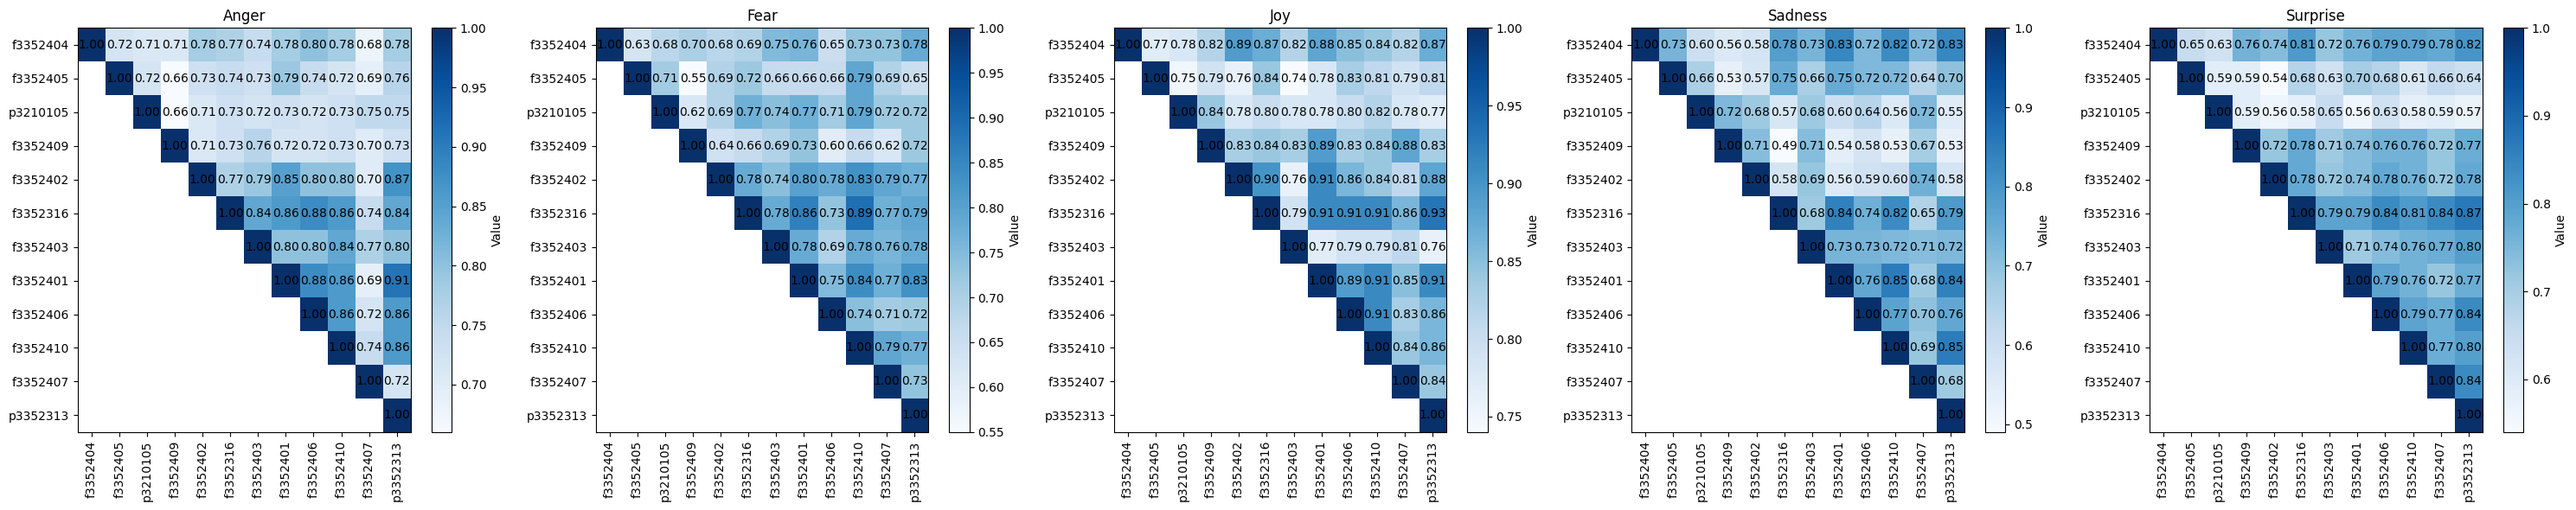

Anger :: Percenatge of coverage having more than 70% values in each cell:  91%
Fear :: Percenatge of coverage having more than 70% values in each cell:  72%
Joy :: Percenatge of coverage having more than 70% values in each cell:  100%
Sadness :: Percenatge of coverage having more than 70% values in each cell:  56%
Surprise :: Percenatge of coverage having more than 70% values in each cell:  73%


In [39]:
def plot_multiple_heatmaps_layout_1_5(
    dfs, 
    titles=None, 
    color_map="Blues"
) -> None:
    """
    Plots multiple heatmaps side by side for the given list of DataFrames with values displayed in each cell.

    :param dfs: list - A list of DataFrames to plot.
    :param titles: list - A list of titles for each heatmap. If None, default titles are used.
    :param color_map: str - The color map to use for the heatmaps (default is 'Blues').

    Note: Displays 5 heatmaps in a single row.
    """
    
    # Validate input types
    if not isinstance(dfs, list) or not all(isinstance(df, pd.DataFrame) for df in dfs):
        raise TypeError("dfs must be a list of pandas DataFrames")
    
    if titles is not None and (not isinstance(titles, list) or not all(isinstance(title, str) for title in titles)):
        raise TypeError("titles must be a list of strings")
    
    # Number of DataFrames
    n_dfs = len(dfs)
    if titles is None:
        titles = [f"Heatmap {i+1}" for i in range(n_dfs)]
    
    # Set up the subplot figure with a flexible grid
    fig, axes = plt.subplots(1, n_dfs, figsize=(6 * n_dfs, 6))
    
    # Plot each heatmap
    for i, (df, title) in enumerate(zip(dfs, titles)):
        # Ensure non-numeric entries are converted to NaN
        df = df.apply(pd.to_numeric, errors='coerce')
        
        # Set up individual subplot
        ax = axes[i] if n_dfs > 1 else axes  # Handle case where n_dfs == 1
        ax.set_title(title)
        heatmap = ax.imshow(df, cmap=color_map, aspect="auto", interpolation="nearest")
        fig.colorbar(heatmap, ax=ax, label="Value")
        
        # Configure x and y ticks
        ax.set_xticks(range(len(df.columns)))
        ax.set_xticklabels(df.columns, rotation=90)
        ax.set_yticks(range(len(df.index)))
        ax.set_yticklabels(df.index)
        
        # Display values in each cell
        for row in range(df.shape[0]):
            for col in range(df.shape[1]):
                value = df.iloc[row, col]
                if not pd.isna(value):
                    ax.text(col, row, f"{value:.2f}", ha="center", va="center", color="black")

    plt.tight_layout()
    plt.show()

# Example usage
print('=======================Percenatge Agreement per Emotion =========')
dataframes_percentage = [percentage_agreement_matrix_anger, percentage_agreement_matrix_fear, percentage_agreement_matrix_joy, percentage_agreement_matrix_sadness, percentage_agreement_matrix_surprise]
titles = ["Anger", "Fear", "Joy", "Sadness", "Surprise"]
plot_multiple_heatmaps_layout_1_5(dataframes_percentage, titles=titles)

#-------------------------------------------- additioanl calcualtion

# calculate pervcenatge of valeus having more than  0.70 per emotion 
list_percentage_agreement_matrix_anger = percentage_agreement_matrix_anger.values.tolist()
total_number_of_numbers = filtered_flat_list = [
    value for sublist in list_percentage_agreement_matrix_anger 
    for value in sublist if isinstance(value, (int, float)) 
]
total_number_of_numbers = len(filtered_flat_list)
total_number_of_numbers # remove <<->>

#   Converting values of teh dataframe to list.
list_percentage_agreement_matrix_anger = percentage_agreement_matrix_anger.values.tolist()
list_percentage_agreement_matrix_fear = percentage_agreement_matrix_fear.values.tolist()
list_percentage_agreement_matrix_joy = percentage_agreement_matrix_joy.values.tolist()
list_percentage_agreement_matrix_sadness = percentage_agreement_matrix_sadness.values.tolist()
list_percentage_agreement_matrix_surprise = percentage_agreement_matrix_surprise.values.tolist()

# Flatten the list and filter for values > 0.70
filtered_flat_list_anger = [ value for sublist in list_percentage_agreement_matrix_anger  for value in sublist if isinstance(value, (int, float)) and value > 0.70]
filtered_flat_list_fear = [ value for sublist in list_percentage_agreement_matrix_fear  for value in sublist if isinstance(value, (int, float)) and value > 0.70]
filtered_flat_list_joy = [ value for sublist in list_percentage_agreement_matrix_joy  for value in sublist if isinstance(value, (int, float)) and value > 0.70]
filtered_flat_list_sadness = [ value for sublist in list_percentage_agreement_matrix_sadness  for value in sublist if isinstance(value, (int, float)) and value > 0.70]
filtered_flat_list_surprise = [ value for sublist in list_percentage_agreement_matrix_surprise  for value in sublist if isinstance(value, (int, float)) and value > 0.70]

print(f'Anger :: Percenatge of coverage having more than 70% values in each cell:  {round(len(filtered_flat_list_anger)/total_number_of_numbers*100)}%')
print(f'Fear :: Percenatge of coverage having more than 70% values in each cell:  {round(len(filtered_flat_list_fear)/total_number_of_numbers*100)}%')
print(f'Joy :: Percenatge of coverage having more than 70% values in each cell:  {round(len(filtered_flat_list_joy)/total_number_of_numbers*100)}%')
print(f'Sadness :: Percenatge of coverage having more than 70% values in each cell:  {round(len(filtered_flat_list_sadness)/total_number_of_numbers*100)}%')
print(f'Surprise :: Percenatge of coverage having more than 70% values in each cell:  {round(len(filtered_flat_list_surprise)/total_number_of_numbers*100)}%')


- We can observe that the anottation process present a general agreemnt per emotion. As many of the values across the hetmaps are high ranging from 0.70 to 0.90.
- Furthermore, from the calculated percentages, showing the percentage of values being more than 0.70 per emotion, we can see taht the **emotion** sadness need more attention 
    - as the percenatge equal to `56%` means taht only 56% of teh total valeus of teh heatmap have valeus more tahnn 0.70. 
    - so maybe more instructions for the emotion should be given.

- Now, we will call the function `calculate_pairwise_kappa` per  Emotion

In [40]:
kappa_scores_matrix_anger = calculate_pairwise_kappa(df_annotations, id_col="ID_Annotator", emotion_cols=["Anger"]) # we pass as arguments emotions for scalability 
kappa_scores_matrix_fear = calculate_pairwise_kappa(df_annotations, id_col="ID_Annotator", emotion_cols=["Fear"]) # we pass as arguments emotions for scalability 
kappa_scores_matrix_joy = calculate_pairwise_kappa(df_annotations, id_col="ID_Annotator", emotion_cols=["Joy"]) # we pass as arguments emotions for scalability 
kappa_scores_matrix_sadness = calculate_pairwise_kappa(df_annotations, id_col="ID_Annotator", emotion_cols=["Sadness"]) # we pass as arguments emotions for scalability 
kappa_scores_matrix_surprise = calculate_pairwise_kappa(df_annotations, id_col="ID_Annotator", emotion_cols=["Surprise"]) # we pass as arguments emotions for scalability 

/var/folders/br/6xtfsjcd1pld8d58t5wwkmcr0000gn/T/ipykernel_40858/1837050185.py:49: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return kappa_scores.fillna("-")
/var/folders/br/6xtfsjcd1pld8d58t5wwkmcr0000gn/T/ipykernel_40858/1837050185.py:49: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return kappa_scores.fillna("-")
/var/folders/br/6xtfsjcd1pld8d58t5wwkmcr0000gn/T/ipykernel_40858/1837050185.py:49: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy

- We will plot our data with the already function presented being `plot_multiple_heatmaps_layout_1_5`
- Furthermore, we will calculate which percenatge of the values on out heatmaps have values more than 0.70.

=======================Kappa per Emotion =========


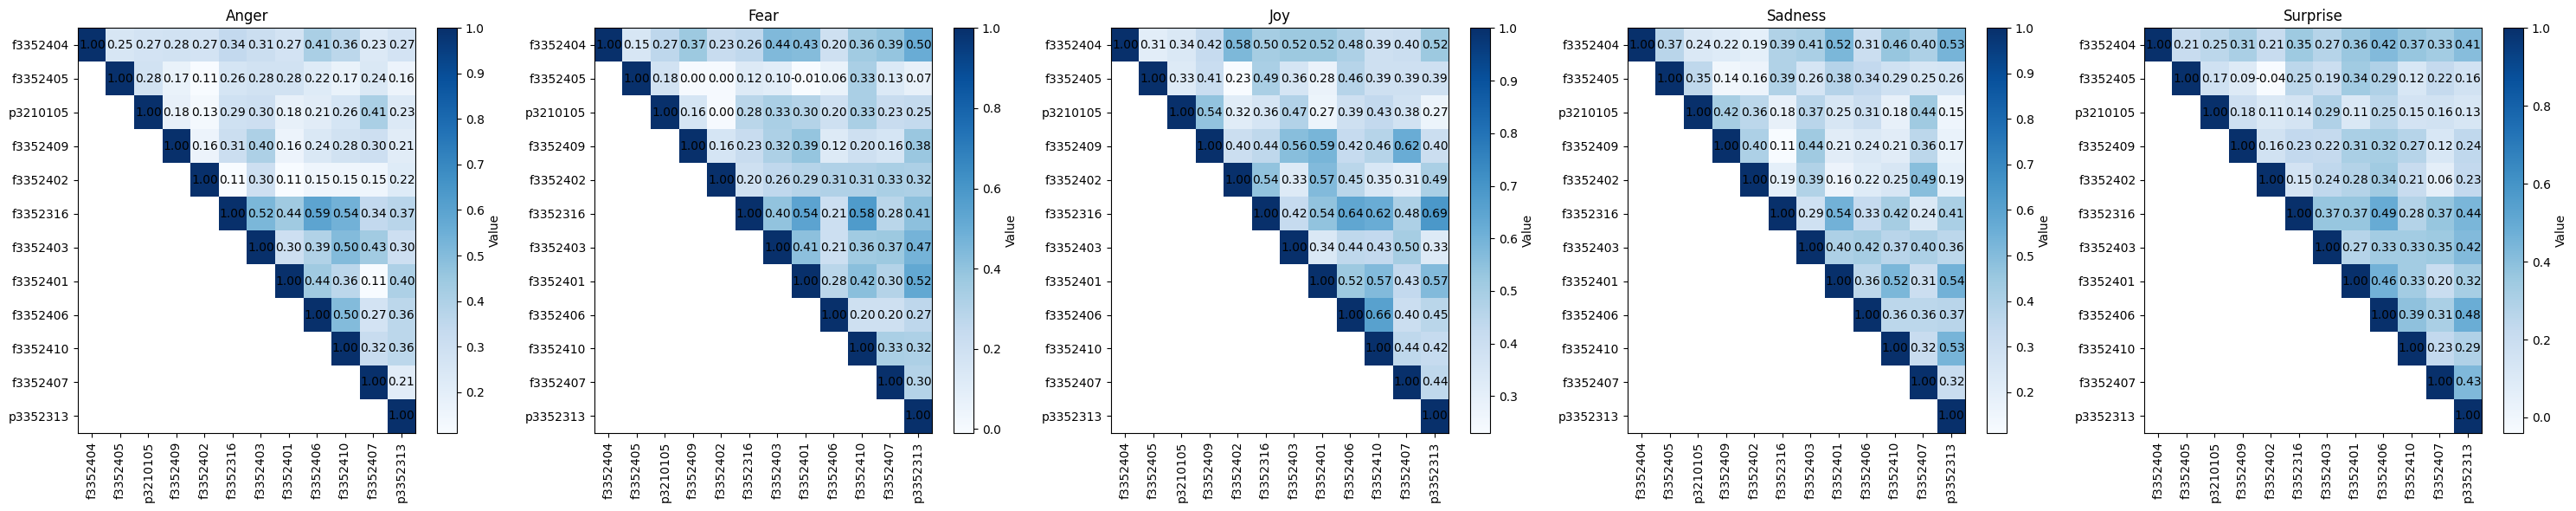

Anger :: Percenatge of coverage having more than 70% values in each cell:  15%
Fear :: Percenatge of coverage having more than 70% values in each cell:  15%
Joy :: Percenatge of coverage having more than 70% values in each cell:  18%
Sadness :: Percenatge of coverage having more than 70% values in each cell:  15%
Surprise :: Percenatge of coverage having more than 70% values in each cell:  15%


In [41]:
print('=======================Kappa per Emotion =========')
dataframes_kappa = [kappa_scores_matrix_anger, kappa_scores_matrix_fear, kappa_scores_matrix_joy, kappa_scores_matrix_sadness, kappa_scores_matrix_surprise]
titles = ["Anger", "Fear", "Joy", "Sadness", "Surprise"]
plot_multiple_heatmaps_layout_1_5(dataframes_kappa, titles=titles)

#   Converting values of teh dataframe to list.
list_kappa_matrix_anger = kappa_scores_matrix_anger.values.tolist()
list_kappa_matrix_fear = kappa_scores_matrix_fear.values.tolist()
list_kappa_matrix_joy = kappa_scores_matrix_joy.values.tolist()
list_kappa_matrix_sadness = kappa_scores_matrix_sadness.values.tolist()
list_kappa_matrix_surprise = kappa_scores_matrix_surprise.values.tolist()

# Flatten the list and filter for values > 0.80
filtered_flat_list_anger_k = [ value for sublist in list_kappa_matrix_anger  for value in sublist if isinstance(value, (int, float)) and value > 0.65]
filtered_flat_list_fear_k = [ value for sublist in list_kappa_matrix_fear  for value in sublist if isinstance(value, (int, float)) and value > 0.65]
filtered_flat_list_joy_k = [ value for sublist in list_kappa_matrix_joy  for value in sublist if isinstance(value, (int, float)) and value > 0.65]
filtered_flat_list_sadness_k = [ value for sublist in list_kappa_matrix_sadness  for value in sublist if isinstance(value, (int, float)) and value > 0.65]
filtered_flat_list_surprise_k = [ value for sublist in list_kappa_matrix_surprise  for value in sublist if isinstance(value, (int, float)) and value > 0.65]

print(f'Anger :: Percenatge of coverage having more than 70% values in each cell:  {round(len(filtered_flat_list_anger_k)/total_number_of_numbers*100)}%')
print(f'Fear :: Percenatge of coverage having more than 70% values in each cell:  {round(len(filtered_flat_list_fear_k)/total_number_of_numbers*100)}%')
print(f'Joy :: Percenatge of coverage having more than 70% values in each cell:  {round(len(filtered_flat_list_joy_k)/total_number_of_numbers*100)}%')
print(f'Sadness :: Percenatge of coverage having more than 70% values in each cell:  {round(len(filtered_flat_list_sadness_k)/total_number_of_numbers*100)}%')
print(f'Surprise :: Percenatge of coverage having more than 70% values in each cell:  {round(len(filtered_flat_list_surprise_k)/total_number_of_numbers*100)}%')

- We observe that for the majority of our cases  15% of the values of each heatmap (except Joy) has values more than 0.65 (we defined this threshold you can emmpirially play make trials with it) menaing that the annoattors tend to desagree in all emotions.
    - As 15% for each emotion heatmap, only 15% of the values that it contains have as value more than 0.65 kappa value. 
        - If kappa has high value , we have more agreemnt between our annotators (we defines thrshold 0.65 as a value tend o be high).    
- In the next cell will plot in parallw both (% agreemnt) and kappa calculaions and we will discuss thei high diffrence in their numbers!

=======================Percenatge Agreement per Emotion =========


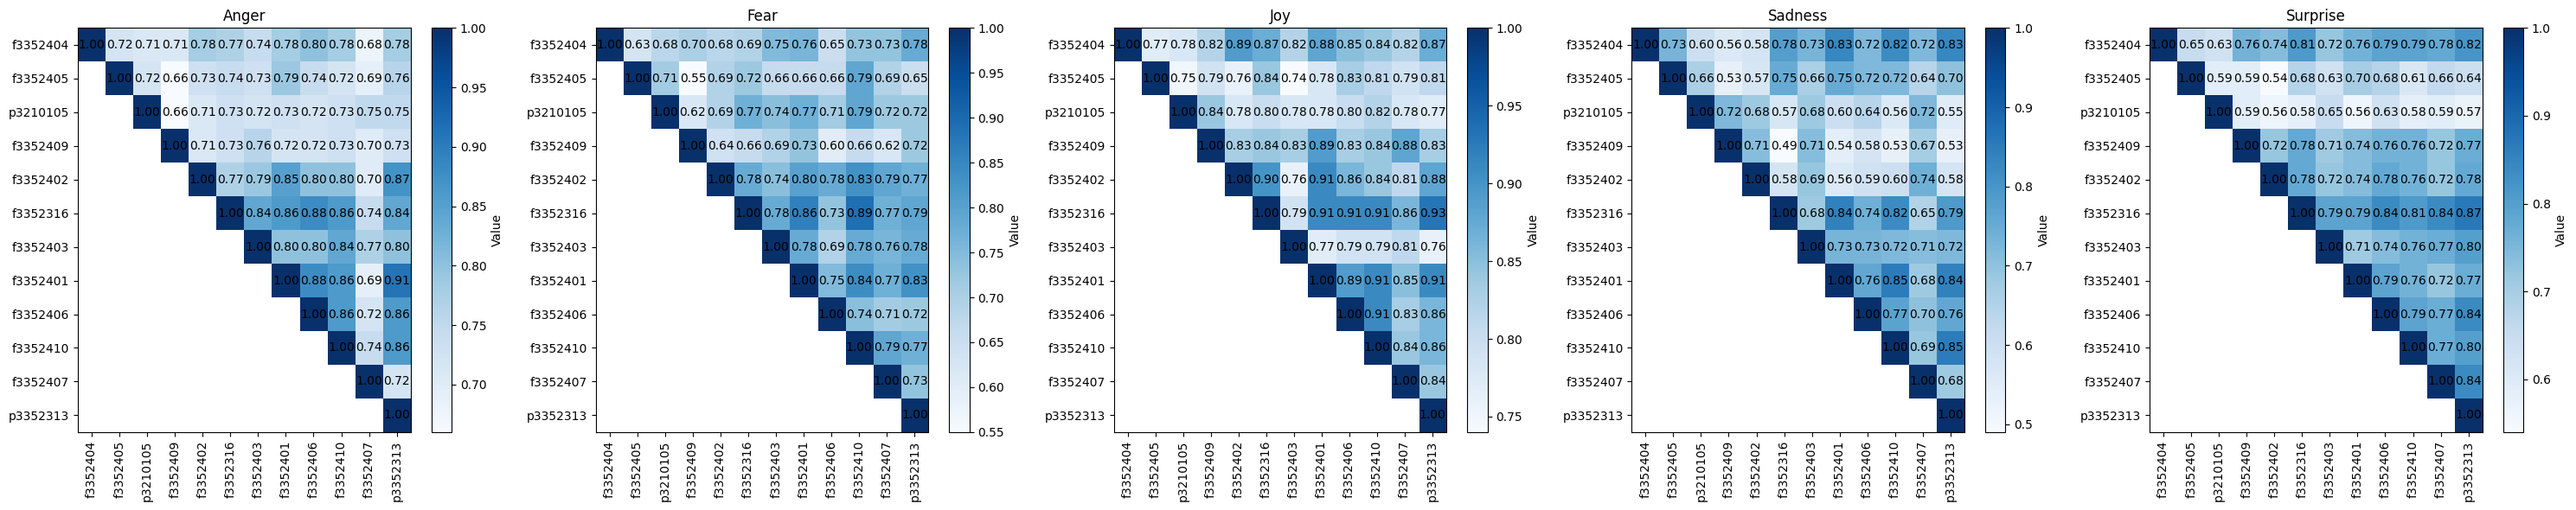

=======================Kappa per Emotion =========


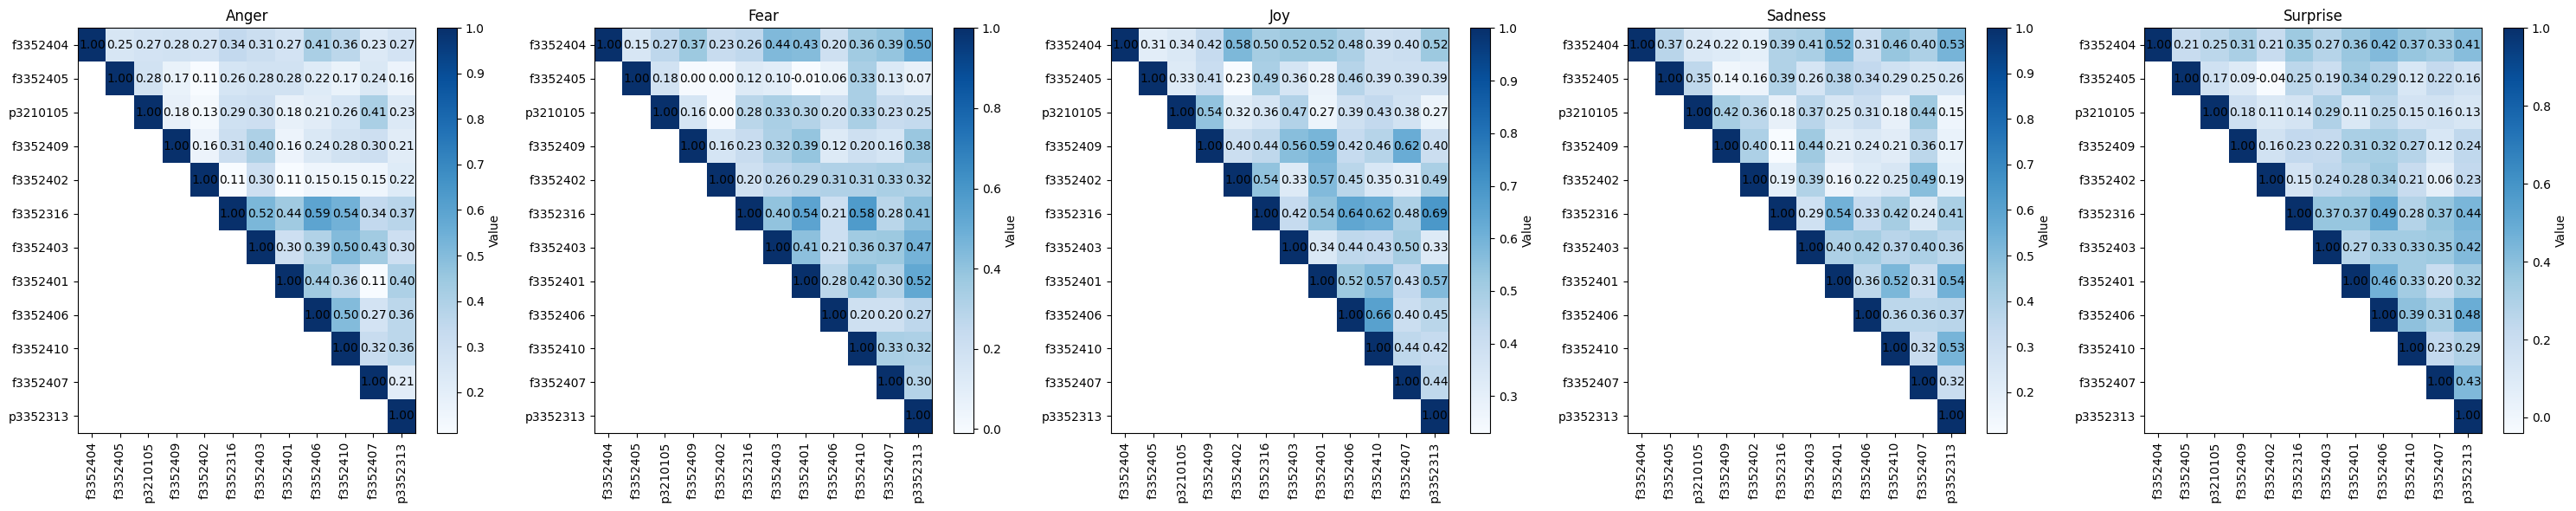

In [42]:
print('=======================Percenatge Agreement per Emotion =========')
dataframes_percentage = [percentage_agreement_matrix_anger, percentage_agreement_matrix_fear, percentage_agreement_matrix_joy, percentage_agreement_matrix_sadness, percentage_agreement_matrix_surprise]
titles = ["Anger", "Fear", "Joy", "Sadness", "Surprise"]
plot_multiple_heatmaps_layout_1_5(dataframes_percentage, titles=titles)


print('=======================Kappa per Emotion =========')
dataframes_kappa = [kappa_scores_matrix_anger, kappa_scores_matrix_fear, kappa_scores_matrix_joy, kappa_scores_matrix_sadness, kappa_scores_matrix_surprise]
titles = ["Anger", "Fear", "Joy", "Sadness", "Surprise"]
plot_multiple_heatmaps_layout_1_5(dataframes_kappa, titles=titles)

- It is obvious that `kappa` has considerable lower values than (% agreemnt) per emotion.
- This differeme can be explained in we focus on theory related to these metrics.
- Cohen’s Kappa has considerably lower values than percentage agreement per emotion primarily `because Kappa accounts for chance agreement`, while percentage agreement does not. Here’s why this difference arises:
    - `Adjustment for Chance`: Kappa adjusts the agreement score by estimating how much of the agreement between annotators `could occur randomly`. When emotions are rare or the data is imbalanced (remind imbalance betwwen `Sadness` and `Joy`), annotators might agree on those labels by default, inflating the percentage agreement. `Kappa reduces the score accordingly to avoid overestimating true agreement`.
    - `High Prevalence of One Label`:  If one label is dominant for an emotion, annotators are likely to agree on it simply because it's common, not necessarily because they consistently detect the presence or absence of the emotion. Kappa corrects for this by lowering the score, especially for `imbalanced data`.
    - Sensitive to Imbalance: Kappa is sensitive to the distribution of labels, so for emotions that are rare (leading to more frequent 0 labels), it will show lower values compared to percentage agreement, providing a more conservative and realistic view of annotator reliability.
- `In short, Kappa’s lower values reflect a more nuanced view of agreement, discounting agreement due to label imbalance or chance, and thus providing a clearer measure of true consensus on each emotion.`
- So, as **best** metric bering in mind the imbalance beween the emotions `Sadness` and `Joy` we will hold `Kappa`.
- We will re-plot it with the function `plot_multiple_heatmaps` having larges heatmaps.

- Cohen’s Kappa and percentage agreement can differ per emotion because each metric measures agreement in a different way:
- Regarding **Percentage Agreement**: 
    - `Percentage Agreement Doesn’t Account for Chance`:  Percentage agreement simply calculates how often annotators agree (both labeling 1 or both labeling 0) out of the total annotations for an emotion.
    - Drawback: This metric doesn’t account for the fact that some agreement may occur purely by chance. For example, if annotators tend to label “sadness” as 0 (no sadness) more often than 1, the percentage agreement might appear high simply because annotators coincidentally chose the same label.
- Regarding Kappa
    - Kappa Accounts for Chance Agreement. Cohen’s Kappa adjusts for the likelihood of annotators agreeing by chance. It does this by calculating the expected agreement based on how often each label (0 or 1) is used by each annotator, then comparing this to the observed agreement.
    - Effect on Interpretation: For emotions where one label is much more common (e.g., sadness might have a lot of “0” labels if sentences are generally neutral or happy), Kappa will reduce the agreement score because it factors in the high probability of chance agreement on that common label.
- **Percentage Agreement** is simpler but doesn’t consider the probability of chance agreement, which can inflate agreement scores for emotions that are rare or frequently labeled with 0.
**Kappa** provides a more reliable measure by accounting for chance, and it is generally considered more accurate for imbalanced data, which is often the case with emotions.

=======================Our Best Metric :: Kappa per Emotion =========


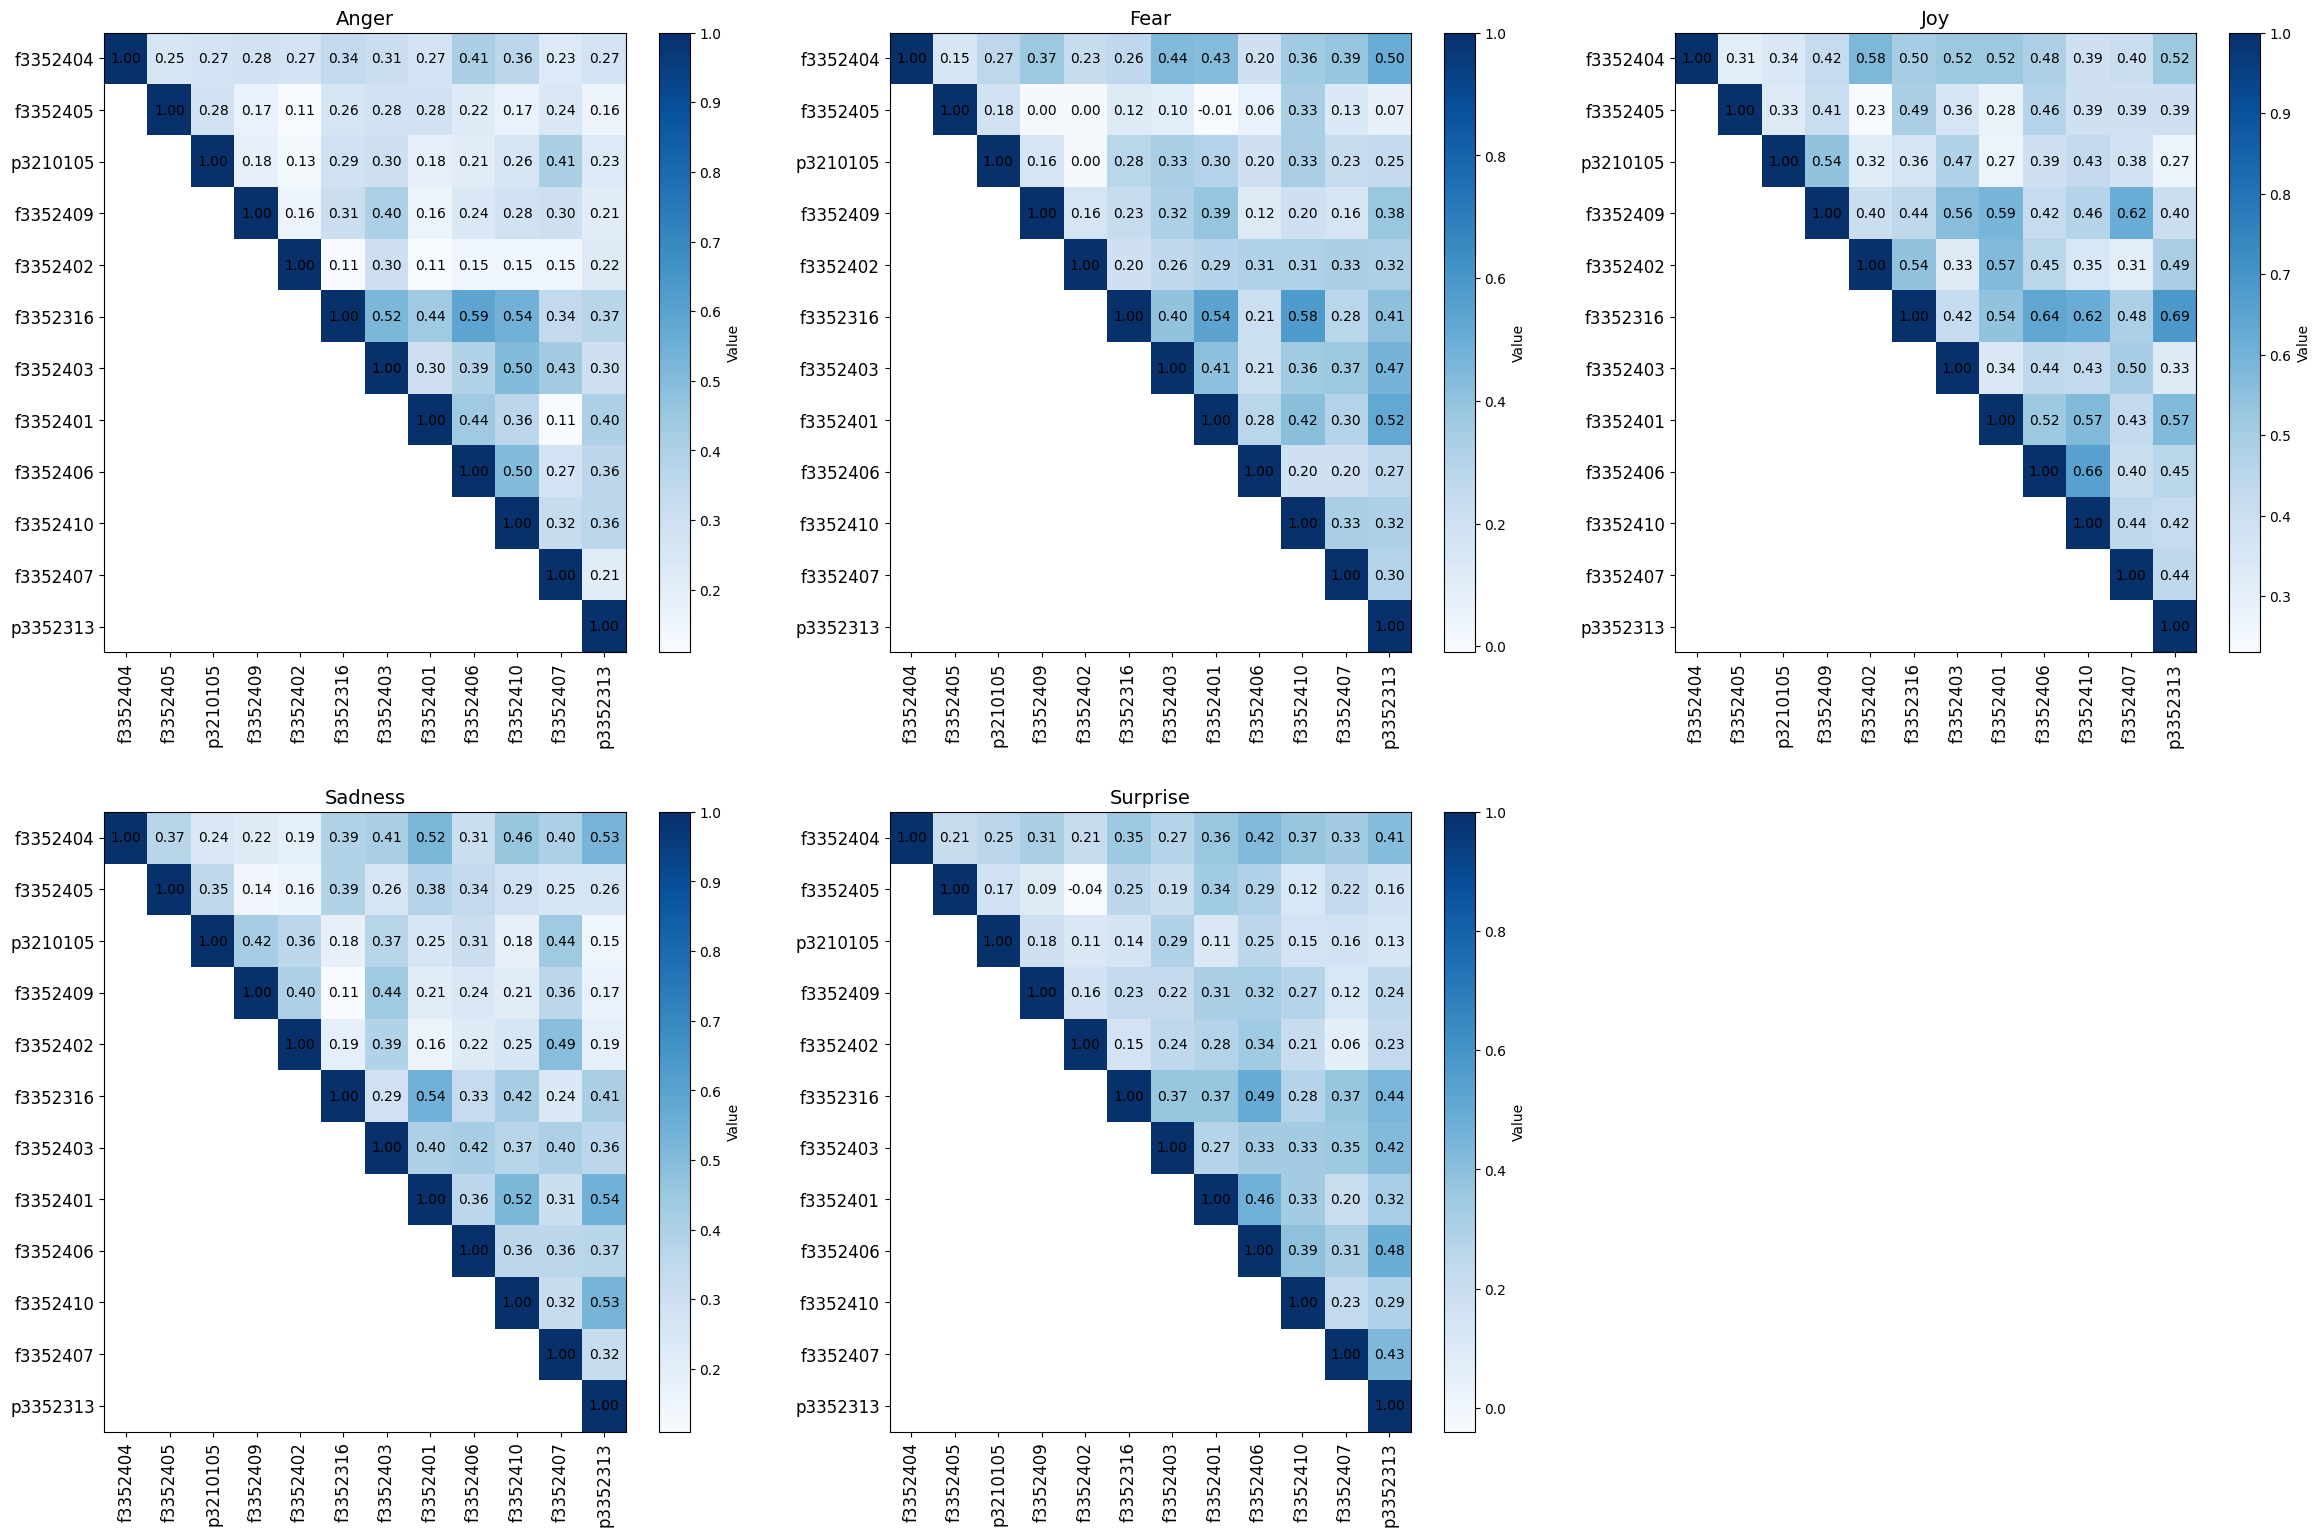

In [43]:
def plot_multiple_heatmaps(
    dfs, 
    titles=None, 
    color_map="Blues"
) -> None:
    """
    Plots multiple heatmaps side by side for a given list of DataFrames with cell values displayed.

    :param dfs: list - A list of pandas DataFrames to plot.
    :param titles: list - A list of titles for each heatmap. If None, default titles are used.
    :param color_map: str - The color map to use for the heatmaps (default is 'Blues').
    """
    
    # Validate input types
    if not isinstance(dfs, list) or not all(isinstance(df, pd.DataFrame) for df in dfs):
        raise TypeError("dfs must be a list of pandas DataFrames")
    
    if titles is not None and (not isinstance(titles, list) or not all(isinstance(title, str) for title in titles)):
        raise TypeError("titles must be a list of strings")
    
    # Number of DataFrames
    n_dfs = len(dfs)
    if titles is None:
        titles = [f"Heatmap {i+1}" for i in range(n_dfs)]
    
    # Determine layout: two rows if more than 2 DataFrames, otherwise a single row
    if n_dfs > 2:
        n_rows = 2
        n_cols = (n_dfs + 1) // 2  # Distribute evenly across two rows
    else:
        n_rows = 1
        n_cols = n_dfs
    
    # Set up the subplot figure with larger dimensions
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 8 * n_rows))
    axes = axes.flatten() if n_dfs > 1 else [axes]  # Flatten axes array for easier indexing

    # Plot each heatmap
    for i, (df, title) in enumerate(zip(dfs, titles)):
        # Ensure non-numeric entries are converted to NaN
        df = df.apply(pd.to_numeric, errors='coerce')
        
        # Set up individual subplot
        ax = axes[i]
        ax.set_title(title, fontsize=14)
        heatmap = ax.imshow(df, cmap=color_map, aspect="auto", interpolation="nearest")
        fig.colorbar(heatmap, ax=ax, label="Value")
        
        # Configure x and y ticks with increased font size for clarity
        ax.set_xticks(range(len(df.columns)))
        ax.set_xticklabels(df.columns, rotation=90, fontsize=12)
        ax.set_yticks(range(len(df.index)))
        ax.set_yticklabels(df.index, fontsize=12)
        
        # Display values in each cell
        for row in range(df.shape[0]):
            for col in range(df.shape[1]):
                value = df.iloc[row, col]
                if not pd.isna(value):
                    ax.text(col, row, f"{value:.2f}", ha="center", va="center", color="black", fontsize=10)

    # Hide any unused subplots if n_dfs < n_rows * n_cols
    for j in range(i + 1, n_rows * n_cols):
        fig.delaxes(axes[j])

    plt.tight_layout(pad=3)
    plt.show()

# Example usage
print('=======================Our Best Metric :: Kappa per Emotion =========')
dataframes_percentage = [
    percentage_agreement_matrix_anger, 
    percentage_agreement_matrix_fear, 
    percentage_agreement_matrix_joy, 
    percentage_agreement_matrix_sadness, 
    percentage_agreement_matrix_surprise
]
titles = ["Anger", "Fear", "Joy", "Sadness", "Surprise"]
plot_multiple_heatmaps(dataframes_kappa, titles=titles)


- This plot is a better version, but because it have already analysed we have not any commnet.

# `A3` Ground-truth: Compute a ground truth value per emotion per text (e.g., using a majority vote).

- In the folloowing cell we have: 
    - `calculate_mode Function`: Computes the mode for each emotion; in case of a tie, returns both values [0, 1].
    - Grouping by text: Aggregates annotations by unique sentences to calculate ground-truth values per sentence.
    - Applying Majority Vote with calculate_mode: The function is applied to each emotion column to determine consensus across annotators.
    - Handling Ties: If annotators are evenly split, the code retains both values ([0, 1]) to indicate a tie.
    - Output: The resulting df_ground_truth_all_modes dataframe shows each sentence with its ground-truth emotion values, providing a consensus view across annotations.


In [44]:
# Sample data structure assuming 'df_annotations' is the loaded dataframe with annotations from multiple annotators

# Define a function to return both values in case of a tie
def calculate_mode(x):
    modes = x.mode()  # Get the mode(s) of the series
    if len(modes) > 1:
        return [0, 1]  # Return both values if there's a tie
    else:
        return modes[0]  # Return the single mode if no tie

# Group by 'text' to aggregate annotations for each sentence and compute ground-truth using majority vote
df_ground_truth_all_modes = df_annotations.groupby('text').agg({
    'Anger': calculate_mode,
    'Fear': calculate_mode,
    'Joy': calculate_mode,
    'Sadness': calculate_mode,
    'Surprise': calculate_mode
}).reset_index()

# Display the resulting ground-truth dataframe with both values retained in cases of ties
df_ground_truth_all_modes


,text,Anger,Fear,Joy,Sadness,Surprise
0,""" And burst into tears.",0,0,0,1,0
1,""" I'm like ""sure.",0,0,0,0,0
2,"""ARcH stop your progression.",1,0,0,0,0
3,"""I don't have time to arrest drunk drivers bec...",1,0,0,1,0
4,& # x 26; nbsp; What I did was cut the top off...,0,0,0,0,0
...,...,...,...,...,...,...
111,Your sister is a heavy sleeper.,0,0,0,0,0
112,and my brain can think up some pretty horrible...,0,1,0,0,0
113,and my feet hurt.,0,0,0,1,0
114,can't wait to be in another wedding!,0,0,1,0,0


In [45]:
# df_ground_truth_all_modes.text[0] #'" And burst into tears.'

- How to interpret the up dataframe output: 
    - For the cell: (" And burst into tears., Anger) we have `0` meaning the majority of annotators labeled with `0` (mening **not** feeleing anger for the sentence: `" And burst into tears.'`)  
    - but for the the same sentence in the cell (" And burst into tears., Sadness) we have `1` meaning the majority of annotators labeled with `1` (mening feeleing sadness for the sentence: `" And burst into tears.'`)
- Similarly, we can explain the other combiantions of ($sentenes_i$ , $emotion_j$)

In [46]:
# Define the emotion columns to check for ties
emotion_columns = ['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']

# Filter rows where any emotion column contains a tie represented by [0, 1] or [1, 0]
df_ground_truth__modes_tie_cases = df_ground_truth_all_modes[
    df_ground_truth_all_modes[emotion_columns].applymap(lambda x: isinstance(x, list) and (x == [0, 1] or x == [1, 0])).any(axis=1) # filter [1, 0] is redundant. 
]

# Display the filtered dataframe with only rows having [0, 1] or [1, 0] ties in any emotion column
df_ground_truth__modes_tie_cases


/var/folders/br/6xtfsjcd1pld8d58t5wwkmcr0000gn/T/ipykernel_40858/879006447.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_ground_truth_all_modes[emotion_columns].applymap(lambda x: isinstance(x, list) and (x == [0, 1] or x == [1, 0])).any(axis=1) # filter [1, 0] is redundant.


,text,Anger,Fear,Joy,Sadness,Surprise
7,") I started to teach myself Japanese, and just...",0,0,0,"[0, 1]",0
9,; ) In the evening we did go down and put our ...,0,0,"[0, 1]",0,1
12,A fraying rope stretches down from the rafters.,0,"[0, 1]",0,0,0
16,After standing in a few times in the past his ...,0,"[0, 1]",0,0,0
19,"And I laughed like this: garhahagar, because m...",0,0,"[0, 1]",0,0
23,Clint and I went up and down with that weight ...,0,0,0,0,"[0, 1]"
29,"I can't move, my hand is stuck, I'm making wei...",0,1,0,"[0, 1]",0
31,I didn't see it through but what I did see whe...,0,0,0,0,"[0, 1]"
39,I noticed this months after moving in and doin...,0,"[0, 1]",0,0,0
44,I untie my bear bag and grab some food inside it.,0,0,"[0, 1]",0,0


In [47]:
list(df_ground_truth__modes_tie_cases.text.head(1))#) I started to teach myself Japanese, and just...

[") I started to teach myself Japanese, and just couldn't shake the feeling that I was supposed to live there."]

- At this point, we should point out that there is an `edge` case we named `tie`
    - The term "tie" refers to a situation where multiple annotators have labeled a sentence with conflicting values for a specific emotion, resulting in an equal frequency of 0s and 1s for that emotion. Since there's no clear majority, this results in a tie.
    - These cases are appeared in the output data frame in the up cell.
    - For example, for the cell: (    ) I started to teach myself Japanese, and just... , Sadness) we have a tie, meaning that 6 annotators in our case voted that this sentence caused them Sadness and 6 the opposite.
)

In [48]:
# additional debug
list(df_annotations.Sadness[df_annotations['text'] == ") I started to teach myself Japanese, and just couldn't shake the feeling that I was supposed to live there."])

[1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1]

- Indeed 6, 6

#  `A4.` LLMs: Prompt an open-source large language model (LLM), such as the Llama-3-8b-instruct (quantized) that we used in class to annotate each text for existing emotions.

- For this task we will use the pre-trained LLM model `Meta-Llama-3-8B-Instruct` offered by hugging face.
- Firstly, we will initialize a `connection` to the `Hugging Face inference API` using a specific API key for authentication. The `InferenceClient` is a **wrapper** to call models hosted on the Hugging Face platform [source](https://huggingface.co/docs/api-inference/tasks/chat-completion).
- Secondly, we will create the function `get_annotation_vector`, that takes `text` (a string) as input and formats it into a prompt for the model to generate an emotion annotation in binary format.
- Regarding our `Prompt` construction, a multi-line string prompt explains how the model should label emotions in the text as binary values. The format and examples clarify the exact output expected from the model.
    - **Note 1:**: because we pass examples in our prompt we are in the category of `few-shot learning`.
    - **Note 2:**: thare are a plethora of `templates` for the prompt task. For example, there in the `RTF` Framework.
        - **Breaking Down the RTF Framework** [Source](https://medium.com/@aciddun/mastering-chatgpt-prompting-the-rtf-framework-2db7465c6500):
            - `Role (R): Defining the “Character” of the AI`: The Role aspect of the RTF framework is all about setting the stage for LLM. By specifying a role, you’re essentially telling the AI what perspective to take when answering your question.
            - `Task (T): Outlining the Desired Action`: Task represents the action you want LLM to perform. It defines what you want the AI to do in response to your query. 
            - `Format (F): Structuring the Response`: The Format component of the RTF framework deals with how you want LLM’s response to be presented. You can specify the format as a list, table, story, diagram, or any other suitable structure. 
- `Calling the Model for Emotion Annotation`: Sends the prompt to the model specified (`meta-llama/Meta-Llama-3-8B-Instruct`), requesting a `response` containing the annotation vector. 
    - Parameters include:
        - messages: List containing the prompt message.
        - max_tokens: Sets a limit on response length.
        - stream: Set to False so that the entire response is returned at once, rather than in parts.
            - Note:  regarding the `parameters` of the model (meaning `temprature`, `max tokens` and `top-p` we used the `default` [source](https://huggingface.co/playground?modelId=meta-llama/Llama-3.1-8B-Instruct)).
- `Extracting and Validating Annotation Vector`: Extracts the response text from the model, trims any surrounding whitespace, and then removes any spaces within the binary string to obtain a continuous list of single-digit values.
- `Validation`: Checks that the response contains exactly five binary values (one for each emotion). If valid, it converts them to integers and returns them as a list. If the format is incorrect, it prints an error and returns a default [0, 0, 0, 0, 0].
- Define `create_annotated_dataframe` function: Defines create_annotated_dataframe, which will apply get_annotation_vector to a list of texts to create a DataFrame of annotations. Initializes lists to store the text and each emotion label.
    - Loops through each unique text in unique_texts, calling get_annotation_vector to obtain its emotion annotations and prints the text and binary values for debugging.
    - Appends the text and each corresponding binary value for each emotion to the appropriate list.

In [ ]:
# client = InferenceClient(api_key="")
def get_annotation_vector(text):
  prompt = f'''
  You are to act as a professional annotator specialised in labelling text with the identified emotion states.

  The only possible emotion states are the following:

  "Anger", "Fear", "Joy", "Sadness", "Surprise"


  Your input will be a sentence in text format. Your output must be in binary format, consisting exclusively of
  five single-digit binary numbers, each number corresponding to the corresponding emotional state in order of:

  "Anger" "Fear" "Joy" "Sadness" "Surprise" .

  1 denotes that the corresponding emotion was recognised and 0 denotes that the corresponding emotion was not recognised .

  You are to *only* , exclusively , output the five single-digit binary numbers.

  Example:

  Example Input:

  "It was a very sunny day in Greece."

  Example Output:

  0 1 1 1 0

  End of Example Output.

  Explanation, not to be outputted:

  This means that:
  "Anger" is *not* identified in the given sentence. (0)
  "Fear" is identified in the given sentence. (1)
  "Joy" is identified in the given sentence. (1)
  "Sadness" is identified in the given sentence. (1)
  "Surprise" is *not* identified in the given sentence. (0)

  End of example

  Input: "{text}"
  Output:
    '''

  messages = [
    { "role": "user", "content": prompt }
  ]

  response = client.chat.completions.create(
      model="meta-llama/Meta-Llama-3-8B-Instruct",
    messages=messages,
    max_tokens=500,
    stream=False
  )
  # Extract and clean the annotation vector
  annotation_vector = response.choices[0].message.content.strip()
  binary_values = list(annotation_vector.replace(" ", ""))  # Remove spaces and split into list

  # Ensure we have exactly 5 binary values
  if len(binary_values) == 5:
    return [int(value) for value in binary_values]  # Convert to integers for easier manipulation
  else:
    print(f"Unexpected annotation format for text: '{text}' -> {annotation_vector}")
    return [0, 0, 0, 0, 0]  # Fallback default

def create_annotated_dataframe(unique_texts):
    """
    Creates a DataFrame with unique texts and their corresponding binary annotation vectors.
    """
    # Prepare lists to hold data for each column
    texts = []
    anger = []
    fear = []
    joy = []
    sadness = []
    surprise = []

    # Iterate over each unique text
    for text in unique_texts:
        print(text)
        # Get the annotation vector for the text
        binary_values = get_annotation_vector(text)
        print(binary_values)
        # Append the text and annotation values to respective lists
        texts.append(text)
        anger.append(binary_values[0])
        fear.append(binary_values[1])
        joy.append(binary_values[2])
        sadness.append(binary_values[3])
        surprise.append(binary_values[4])

    # Construct the DataFrame using the collected lists
    df_annotated = pd.DataFrame({
        "text": texts,
        "Anger": anger,
        "Fear": fear,
        "Joy": joy,
        "Sadness": sadness,
        "Surprise": surprise
    })

    return df_annotated
# Usage example with unique texts from the existing DataFrame
unique_texts = df_annotations['text'].drop_duplicates()
df_annotated = create_annotated_dataframe(unique_texts)

# Display the annotated DataFrame
df_annotated

My mouth fell open `` No, no, no... I..


[0, 1, 0, 0, 1]
You can barely make out your daughter's pale form in the darkness of your room.
[1, 0, 0, 1, 0]
But after blinking my eyes for a few times lepas tu tampar-tampar muka sikit, memang sah la yang penghantar itu Hanis Zalikha.
[1, 1, 1, 0, 0]
Slowly rising to my feet I came to the conclusion that sometimes being alone meant surviving for myself.
[0, 1, 0, 0, 0]
I noticed this months after moving in and doing all of my basic routines in my room naked.
[0, 0, 0, 0, 1]
I know not why, I wipe my face.
[0, 1, 0, 0, 0]
It was rather insulting.
[1, 1, 0, 0, 0]
I was born without the compassion chromosome, or I could have been born with two hearts, neither one agreeing where my brain should spend it's time.
[1, 0, 1, 0, 0]
; ) In the evening we did go down and put our feet in the water-I got to about my waist actually.
[1, 0, 1, 0, 0]
I feel like I am in over my head... Like Quicksand.
[1, 0, 0, 1, 0]
I would go over to his house where his Grandmother and mom and dad lived to play 

,text,Anger,Fear,Joy,Sadness,Surprise
0,"My mouth fell open `` No, no, no... I..",0,1,0,0,1
1,You can barely make out your daughter's pale f...,1,0,0,1,0
2,But after blinking my eyes for a few times lep...,1,1,1,0,0
3,Slowly rising to my feet I came to the conclus...,0,1,0,0,0
4,I noticed this months after moving in and doin...,0,0,0,0,1
...,...,...,...,...,...,...
111,"""ARcH stop your progression.",1,1,0,0,0
112,"This 'star', starts to move across the sky.",0,1,1,1,0
113,and my feet hurt.,0,1,0,1,0
114,so i cried my eyes out and did the drawing.,1,0,1,0,1


- We can observe that the LLM assigned values to the given sentences.
    - For example, for the sentence `They were coal black` assegned `1` to the emotion `sadness`.

# `A5` Agents: Instructing the LLM to have a different sociodemographic background before annotating. For instance, using gender, instruct the LLM to be a man and then to be a woman. Compare the two sets of annotations and quantify how much does the background affects the model's decisions. Compute the IAA between the agents and the human annotators. Discuss the outcomes.

- In the cell below, we ctreated the function `get_biased_annotation_vector`  taking a text string and sociodemographic background as input, returning a binary vector indicating which emotions are present from the specified viewpoint.
    - **Parameters**
        - `text`(str):  The input sentence for emotion annotation.
        - `sociodemographic_background`(str): Background perspective (e.g., `"western european white female"`).
    - **Returns** 
        - A list of binary values representing the presence of each emotion (anger, fear, joy, sadness, surprise).
- In addition, we created the function `create_biased_annotated_dataframe` iterating over a list of unique texts and generates an annotated DataFrame based on the `sociodemographic perspective` provided.
    - **Parameters** 
        - `unique_texts`(iterable of str): Collection of unique texts to annotate.
        - `sociodemographic_background`(str): Sociodemographic background to apply.
    - **Returns**
        - A `pandas.DataFrame` with the following columns:
            - `text`: The original input text.
            - `Anger`, `Fear`, `Joy`, `Sadness`, `Surprise`: Binary columns indicating the presence of each emotion.
- Note: Due to time limitations, we cannot examine multiple `sociodemographic perspective` in order to extract maybe intresting insights acrooss diffrent demographics diamensions.
    - So, we limited our analysis for annotating single sentence with sociodemographic bias with the following "properties": 
        - (1) `western european white female` and (2) `western european white male`.
- This example produces a `DataFrame of annotated texts` based on the specified `demographic profile`, allowing for **comparative analysis across different sociodemographic backgrounds**, in our case across two profiles (duw to time limitations).
    - So, we have a `DataFrame` (`df_annotated_western_european_white_female`) for the profile `western european white female`
    - So, we have a `DataFrame` (`df_annotated_western_european_white_male`) for the profile `western european white male`

In [50]:
def get_biased_annotation_vector(text,sociodemographic_background):
  prompt = f'''
  You are to act as an annotator specialised in labelling text with the identified emotion states. You are to identify the
  emotion states with the bias of being a {sociodemographic_background}.

  The only possible emotion states are the following:

  "Anger", "Fear", "Joy", "Sadness", "Surprise"


  Your input will be a sentence in text format. Your output must be in binary format, consisting exclusively of
  five single-digit binary numbers, each number corresponding to the corresponding emotional state in order of:

  "Anger" "Fear" "Joy" "Sadness" "Surprise" .

  1 denotes that the corresponding emotion was recognised and 0 denotes that the corresponding emotion was not recognised .

  You are to *only* , exclusively , output the five single-digit binary numbers. No extra notes, just the numbers.

  Example:

  Example Input:

  "It was a cold day in Greece."

  Example Output:

  0 1 0 1 1

  End of Example Output.

  Explanation, not to be outputted:

  This means that:
  "Anger" is *not* identified in the given sentence. (0)
  "Fear" is identified in the given sentence. (1)
  "Joy" is identified in the given sentence. (1)
  "Sadness" is identified in the given sentence. (1)
  "Surprise" is *not* identified in the given sentence. (0)

  End of example

  Input: "{text}"
  Output:
    '''

  messages = [
    { "role": "user", "content": prompt }
  ]

  response = client.chat.completions.create(
      model="meta-llama/Meta-Llama-3-8B-Instruct",
    messages=messages,
    max_tokens=500,
    stream=False
  )
  # Extract and clean the annotation vector
  annotation_vector = response.choices[0].message.content.strip()
  binary_values = list(annotation_vector.replace(" ", ""))  # Remove spaces and split into list

  # Ensure we have exactly 5 binary values
  if len(binary_values) == 5:
    return [int(value) for value in binary_values]  # Convert to integers for easier manipulation
  else:
    print(f"Unexpected annotation format for text: '{text}' -> {annotation_vector}")
    return [0, 0, 0, 0, 0]  # Fallback default

def create_biased_annotated_dataframe(unique_texts,sociodemographic_background):
    """
    Creates a DataFrame with unique texts and their corresponding binary annotation vectors.
    """
    # Prepare lists to hold data for each column
    texts = []
    anger = []
    fear = []
    joy = []
    sadness = []
    surprise = []

    # Iterate over each unique text
    for text in unique_texts:
        print(text)
        # Get the annotation vector for the text
        binary_values = get_biased_annotation_vector(text,sociodemographic_background)
        print(binary_values)
        # Append the text and annotation values to respective lists
        texts.append(text)
        anger.append(binary_values[0])
        fear.append(binary_values[1])
        joy.append(binary_values[2])
        sadness.append(binary_values[3])
        surprise.append(binary_values[4])

    # Construct the DataFrame using the collected lists
    df_annotated = pd.DataFrame({
        "text": texts,
        "Anger": anger,
        "Fear": fear,
        "Joy": joy,
        "Sadness": sadness,
        "Surprise": surprise
    })

    return df_annotated
#Unique texts from the existing DataFrame
unique_texts = df_annotations['text'].drop_duplicates()
df_annotated_western_european_white_female = create_biased_annotated_dataframe(unique_texts,"western european white female") # here
df_annotated_western_european_white_male = create_biased_annotated_dataframe(unique_texts,"western european white male")

# Display the annotated DataFrame
print(df_annotated_western_european_white_female)
print(df_annotated_western_european_white_male)

My mouth fell open `` No, no, no... I..
[1, 1, 0, 0, 0]
You can barely make out your daughter's pale form in the darkness of your room.
[1, 0, 0, 1, 0]
But after blinking my eyes for a few times lepas tu tampar-tampar muka sikit, memang sah la yang penghantar itu Hanis Zalikha.
[0, 0, 0, 0, 1]
Slowly rising to my feet I came to the conclusion that sometimes being alone meant surviving for myself.
[1, 0, 0, 1, 0]
I noticed this months after moving in and doing all of my basic routines in my room naked.
[0, 0, 1, 0, 0]
I know not why, I wipe my face.
[0, 1, 0, 0, 0]
It was rather insulting.
[1, 1, 0, 0, 0]
I was born without the compassion chromosome, or I could have been born with two hearts, neither one agreeing where my brain should spend it's time.
[1, 1, 0, 1, 1]
; ) In the evening we did go down and put our feet in the water-I got to about my waist actually.
[0, 0, 1, 0, 1]
I feel like I am in over my head... Like Quicksand.
[0, 1, 0, 0, 1]
I would go over to his house where his Gr

In [51]:
df_annotated_western_european_white_female # preview data frame for the profile "western european white female"

,text,Anger,Fear,Joy,Sadness,Surprise
0,"My mouth fell open `` No, no, no... I..",1,1,0,0,0
1,You can barely make out your daughter's pale f...,1,0,0,1,0
2,But after blinking my eyes for a few times lep...,0,0,0,0,1
3,Slowly rising to my feet I came to the conclus...,1,0,0,1,0
4,I noticed this months after moving in and doin...,0,0,1,0,0
...,...,...,...,...,...,...
111,"""ARcH stop your progression.",1,0,0,0,0
112,"This 'star', starts to move across the sky.",0,1,0,0,1
113,and my feet hurt.,1,0,0,1,0
114,so i cried my eyes out and did the drawing.,1,1,0,1,0


In [52]:
df_annotated_western_european_white_male # preview data frame for "western european white male

,text,Anger,Fear,Joy,Sadness,Surprise
0,"My mouth fell open `` No, no, no... I..",1,1,0,1,0
1,You can barely make out your daughter's pale f...,0,1,0,1,0
2,But after blinking my eyes for a few times lep...,0,1,1,0,1
3,Slowly rising to my feet I came to the conclus...,1,0,0,1,0
4,I noticed this months after moving in and doin...,0,1,0,0,0
...,...,...,...,...,...,...
111,"""ARcH stop your progression.",1,1,0,0,0
112,"This 'star', starts to move across the sky.",0,1,1,1,0
113,and my feet hurt.,0,0,0,0,0
114,so i cried my eyes out and did the drawing.,0,0,1,1,0


- Great, with our DataFrames prepared for each specific demographic profile, we'll begin by conducting an overarching analysis, followed by a detailed, emotion-specific examination. 
    - This approach will allow us to capture broad patterns initially and then investigate each emotional response in depth.

In [53]:
# we should verify that the two dfs have the same text in the same order
# firtly, we will
print(df_annotated_western_european_white_female[df_annotated_western_european_white_female['text'].duplicated()]['text'].unique()) 

[]


In [54]:
# Align both dataframes on the text column
df_annotated_western_european_white_female = df_annotated_western_european_white_female.set_index('text')
df_annotated_western_european_white_male = df_annotated_western_european_white_male.set_index('text')

In [55]:
# check if two dataframes have the same **index** text in the same order; validation checks.
df_annotated_western_european_white_female.index.equals(df_annotated_western_european_white_male.index)

True

Note: `True` value means the index values in `df_annotated_western_european_white_female` and `df_annotated_western_european_white_male` are identical and in the same order;

- First, we will calculate the overall `total agreement` (`not the mean but the strict overall`) between the `two agents` **across all** emotions in order to have a **strict** overview between our agents.
    - Regarding our implementation: 
        - `(df_annotated_western_european_white_female == df_annotated_western_european_white_male)`: 
            - This part creates a boolean DataFrame where each cell is True if the corresponding cells in the two DataFrames match (have the same value) and False if they don't.

    - `.all(axis=1)`: This applies the .all() method across columns (due to axis=1), resulting in a single True or False value per row:
        - True if all values in that row are identical between the two DataFrames.
        - False if any value in the row differs.
    - `matching_rows`: The final result is a Series named matching_rows, where each entry represents whether or not all values in that row match across the two DataFrames.

In [56]:
# Find rows where all emotion values are identical between the two dataframes
matching_rows = (df_annotated_western_european_white_female == df_annotated_western_european_white_male).all(axis=1)
matching_count = matching_rows.sum()
matching_count

21

- **Note** : Due to randomness of LLM we commented out the some cells in order not to be confused for the reader.

In [57]:
# diffrenct percenatge due to stohastic nature of LLM
#str(round(matching_count/df_annotated_western_european_white_female.shape[0],2)*100) + '%'# shape of both profiles is the same so it doent matter what will take for the shape '19.0%'

- We observe that our two agents have a quite **low total percenatge of agreement** (**across all emotions**) being equal to approximately `20%`
    - In simple terms, this means that out of 100 sentences annotated by both agents, they assigned identical values (0 or 1) across all emotions for only 20 cases.
- We will now conduct a more detailed analysis to evaluate the agreement between the two agents at a finer level—specifically, on a per-emotion basis.
    - For instance, two agents may differ in their annotation of just one of the five emotions for a given sentence.
    - This in-depth analysis allows us to capture these nuances, providing a more meaningful assessment of agreement across individual emotional dimensions.
- So, we will calculate the (%) agreemnt **per** emotion and then the kappa agreement per emotion (to be comparable to Humans already calculated bset metric being "kappa" per emotion). 
- ⚠️ **Important Note:** Due to the stochastic nature of our language model (LLM), rerunning this notebook may yield different percentage values.

In [58]:
# diffrenct percenatge due to stohastic nature of LLM
# Compare each emotion column separately and count the matches per emotion

matching_per_emotion = {}
for emotion in df_annotated_western_european_white_female.columns:
    matching_per_emotion[emotion] = (df_annotated_western_european_white_female[emotion] == df_annotated_western_european_white_male[emotion]).sum()

# Display the matching count for each emotion
for emotion, count in matching_per_emotion.items():
    print(f"(%) of matching rows for {emotion}: {round((count/df_annotated_western_european_white_female.shape[0]),2)}%") # calculate rounded the percenatge 

# Note : We saved the output duw to LLM randomness. 
# (%) of matching rows for Anger: 0.61%
# (%) of matching rows for Fear: 0.57%
# (%) of matching rows for Joy: 0.75%
# (%) of matching rows for Sadness: 0.7%
# (%) of matching rows for Surprise: 0.69%

(%) of matching rows for Anger: 0.56%
(%) of matching rows for Fear: 0.63%
(%) of matching rows for Joy: 0.7%
(%) of matching rows for Sadness: 0.71%
(%) of matching rows for Surprise: 0.69%


- Observations:

     - The two agents show the highest agreement on the label `Sadness` and `Surprise`, where both agents having common answers in 72% of the examined sentences. 
     - The agents show a notably high level of agreement across the majority of emotions (`Joy`, `Sadness`, `Surprise`) having common answers in **at least** 70%  of the examined sentences . 
     - The lowest (%) of matching  was presented for the emotions `Fear` and `Anger` being equal to 65% and 60% respectively.
General Comment:
    - Overall, `the agents demonstrate a relatively consistent annotation behavior per emotion`. However, their overall (already calcualted)  agreement percentage remains low, indicating  disagreements on certain emotions, which impacts the broader analysis.
        - meaning ,for example, for a sentence x of our dataset, the one agent has the same annoattions with the agent 2 with diffrent values only in one emotio, and as a result it is considered disagreement in the ovearall calculation.  
            - If we ahd more time we will calculated additionally the `mean total agreemnt`. 
- Furthermore, we will apply an analysis more, in order to see for each `profile agent` the distribution of labeling choices per emotion for all setences. 
    -  In other words, we will calculate the `prior probability` for each agent profile. 
    -  provides the probability that each annotator marks an emotion as present across all their annotations, giving insight into individual labeling tendencies.

In [59]:
#  prior probability per emotion 

# Calculate the mean for each emotion column to get the prior probabilities
df_prior_prob_annotated_western_european_white_female = df_annotated_western_european_white_female[["Anger", "Fear", "Joy", "Sadness", "Surprise"]].mean() # tahnks to  to binary values and not missing values
                                                                                                                                    # we leverage `mean` function of pandas.
dict_df_annotated_western_european_white_female = dict(df_prior_prob_annotated_western_european_white_female)

# Calculate the mean for each emotion column to get the prior probabilities
df_prior_prob_annotated_western_european_white_male = df_annotated_western_european_white_male[["Anger", "Fear", "Joy", "Sadness", "Surprise"]].mean()
dict_df_annotated_western_european_white_male = dict(df_prior_prob_annotated_western_european_white_male)

- Let's plot the calculated prior probabilities for each agent per emotion.

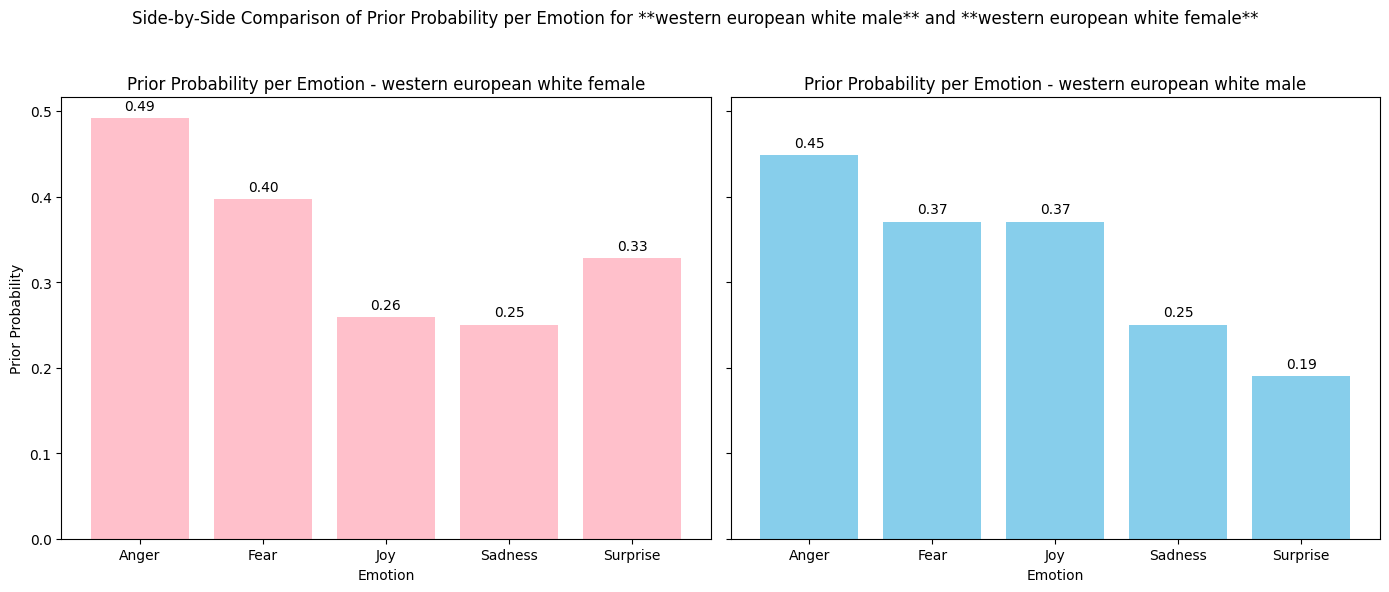

In [60]:
# Setting up subplots for side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Female plot
axes[0].bar(
    dict_df_annotated_western_european_white_female.keys(), 
    dict_df_annotated_western_european_white_female.values(), 
    color='pink' # pink -> female
)
axes[0].set_title("Prior Probability per Emotion - western european white female")
axes[0].set_xlabel("Emotion")
axes[0].set_ylabel("Prior Probability")
for i, (emotion, probability) in enumerate(dict_df_annotated_western_european_white_female.items()):
    axes[0].text(i, probability + 0.01, f'{probability:.2f}', ha='center')

# Male plot
axes[1].bar(
    dict_df_annotated_western_european_white_male.keys(), 
    dict_df_annotated_western_european_white_male.values(), 
    color='skyblue' #  sky-blue -> male 
)
axes[1].set_title("Prior Probability per Emotion - western european white male")
axes[1].set_xlabel("Emotion")
for i, (emotion, probability) in enumerate(dict_df_annotated_western_european_white_male.items()):
    axes[1].text(i, probability + 0.01, f'{probability:.2f}', ha='center')

plt.suptitle("Side-by-Side Comparison of Prior Probability per Emotion for **western european white male** and **western european white female**")
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make space for the super title
plt.show()


- ⚠️ **Important Note:** Due to the stochastic nature of our language model (LLM), rerunning this notebook may yield different percentage values.
    - For reproduction purposes and validity of our intrpretations we have save thep lot to the folder `.\llm_reproduction`
- The diagram for `prior probabilities` shows that the values `per emotions` tend to be `similar`, with  `some fluctuations` especially for the emotions : anger (9-unit diffrence).
- Overall, the labeling of sentences was `consistent across agents`, with both Western European white male and female agents categorizing the sentences similarly in the majority of cases.
    - Only in the emotion `anger` we have the biggest diffrent. Observing the prior probabilities for this emotion, we can see that males tend to classify the sentences more with the labe `anger` than women. 
- Gnerally, seems that specific demographic bachground not affect the annotation process a lot. 
    - Note: future work, it would be valuable to examine contrasting demographic groups, such as Black American males and White European females, where all dimensions differ significantly.
 - Overall (bearing in mind the whole analysis), the agents demonstrate a relatively consistent annotation behavior per emotion. However, their overall (already calcualted)  total agreement percentage remains low, indicating  disagreements on certain emotions, which impacts the broader analysis. 
    - meaning ,for example, for a sentence x of our dataset, the one agent has the same annoattions with the agent 2 with diffrent values only in one emotio, and as a result it is considered disagreement in the ovearall calculation.  
- Regarding the comparison of **Agents** and **Humans**, we will need firstly to calculate `kappa per emotion for each agent` in order to compare with yhe already kappa metrics per emotion for humans.
    - We, also, focus on kappa to compare same things (as we alreade mentioned) but we also want to calcualte it due to a kind of imbalance between the emotion `Anger`
        - So, (% agreemnt) per emotion may ne misleading to a certain extent! 
    - Firtly, we will transform our datafarme to be in a similar format like that of df: `df_annotations`.

In [61]:
df_annotated_western_european_white_female['ID_Annotator'] = 'ID_western_european_white_female' # add ID_Annotator column
df_annotated_western_european_white_female.reset_index(inplace=True) # convert index to simple column
df_annotated_western_european_white_female # add column ID_Annotator

,text,Anger,Fear,Joy,Sadness,Surprise,ID_Annotator
0,"My mouth fell open `` No, no, no... I..",1,1,0,0,0,ID_western_european_white_female
1,You can barely make out your daughter's pale f...,1,0,0,1,0,ID_western_european_white_female
2,But after blinking my eyes for a few times lep...,0,0,0,0,1,ID_western_european_white_female
3,Slowly rising to my feet I came to the conclus...,1,0,0,1,0,ID_western_european_white_female
4,I noticed this months after moving in and doin...,0,0,1,0,0,ID_western_european_white_female
...,...,...,...,...,...,...,...
111,"""ARcH stop your progression.",1,0,0,0,0,ID_western_european_white_female
112,"This 'star', starts to move across the sky.",0,1,0,0,1,ID_western_european_white_female
113,and my feet hurt.,1,0,0,1,0,ID_western_european_white_female
114,so i cried my eyes out and did the drawing.,1,1,0,1,0,ID_western_european_white_female


In [62]:
df_annotated_western_european_white_male['ID_Annotator'] = 'ID_western_european_white_male' # add ID_Annotator column
df_annotated_western_european_white_male.reset_index(inplace=True) # convert index to simple column
df_annotated_western_european_white_male # # add column ID_Annotator

,text,Anger,Fear,Joy,Sadness,Surprise,ID_Annotator
0,"My mouth fell open `` No, no, no... I..",1,1,0,1,0,ID_western_european_white_male
1,You can barely make out your daughter's pale f...,0,1,0,1,0,ID_western_european_white_male
2,But after blinking my eyes for a few times lep...,0,1,1,0,1,ID_western_european_white_male
3,Slowly rising to my feet I came to the conclus...,1,0,0,1,0,ID_western_european_white_male
4,I noticed this months after moving in and doin...,0,1,0,0,0,ID_western_european_white_male
...,...,...,...,...,...,...,...
111,"""ARcH stop your progression.",1,1,0,0,0,ID_western_european_white_male
112,"This 'star', starts to move across the sky.",0,1,1,1,0,ID_western_european_white_male
113,and my feet hurt.,0,0,0,0,0,ID_western_european_white_male
114,so i cried my eyes out and did the drawing.,0,0,1,1,0,ID_western_european_white_male


In [63]:
# Stack "df_annotated_western_european_white_female" and "df_annotated_western_european_white_male" vertically
df_stacked = pd.concat([df_annotated_western_european_white_male, df_annotated_western_european_white_female], ignore_index=True)

In [64]:
df_stacked # preview our "integarted" datafarme

,text,Anger,Fear,Joy,Sadness,Surprise,ID_Annotator
0,"My mouth fell open `` No, no, no... I..",1,1,0,1,0,ID_western_european_white_male
1,You can barely make out your daughter's pale f...,0,1,0,1,0,ID_western_european_white_male
2,But after blinking my eyes for a few times lep...,0,1,1,0,1,ID_western_european_white_male
3,Slowly rising to my feet I came to the conclus...,1,0,0,1,0,ID_western_european_white_male
4,I noticed this months after moving in and doin...,0,1,0,0,0,ID_western_european_white_male
...,...,...,...,...,...,...,...
227,"""ARcH stop your progression.",1,0,0,0,0,ID_western_european_white_female
228,"This 'star', starts to move across the sky.",0,1,0,0,1,ID_western_european_white_female
229,and my feet hurt.,1,0,0,1,0,ID_western_european_white_female
230,so i cried my eyes out and did the drawing.,1,1,0,1,0,ID_western_european_white_female


In [65]:
df_stacked.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232 entries, 0 to 231
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          232 non-null    object
 1   Anger         232 non-null    int64 
 2   Fear          232 non-null    int64 
 3   Joy           232 non-null    int64 
 4   Sadness       232 non-null    int64 
 5   Surprise      232 non-null    int64 
 6   ID_Annotator  232 non-null    object
dtypes: int64(5), object(2)
memory usage: 12.8+ KB


- We can observe that our intagrated dataframe (`df_stacked`) consists of **232** rows in total (116*2) where 2 our two agents, 116 the total number of setence.
- We have not missing values to handle.

In [66]:
df_stacked = df_stacked[['ID_Annotator','text','Anger','Fear','Joy','Sadness','Surprise']] # for consistency we change the order of columns
df_stacked # preview df

,ID_Annotator,text,Anger,Fear,Joy,Sadness,Surprise
0,ID_western_european_white_male,"My mouth fell open `` No, no, no... I..",1,1,0,1,0
1,ID_western_european_white_male,You can barely make out your daughter's pale f...,0,1,0,1,0
2,ID_western_european_white_male,But after blinking my eyes for a few times lep...,0,1,1,0,1
3,ID_western_european_white_male,Slowly rising to my feet I came to the conclus...,1,0,0,1,0
4,ID_western_european_white_male,I noticed this months after moving in and doin...,0,1,0,0,0
...,...,...,...,...,...,...,...
227,ID_western_european_white_female,"""ARcH stop your progression.",1,0,0,0,0
228,ID_western_european_white_female,"This 'star', starts to move across the sky.",0,1,0,0,1
229,ID_western_european_white_female,and my feet hurt.,1,0,0,1,0
230,ID_western_european_white_female,so i cried my eyes out and did the drawing.,1,1,0,1,0


- Now, we are ready to calculate `kappa per emotion` for our pair of agents. 

In [67]:
# Filtering data by annotator
annotator_1_male = df_stacked[df_stacked['ID_Annotator'] == 'ID_western_european_white_male'] # filter stacked df for the annotator western_european_white_male
annotator_2_female = df_stacked[df_stacked['ID_Annotator'] == 'ID_western_european_white_female']# filter stacked df for the annotator western european white female

# Assuming both annotators have the same index after filtering, otherwise align based on unique IDs
kappa_scores = {}

# Calculate Cohen's Kappa for each emotion
emotions = ["Anger", "Fear", "Joy", "Sadness", "Surprise"]
for emotion in emotions:
    score = cohen_kappa_score(annotator_1_male[emotion], annotator_2_female[emotion])
    kappa_scores[emotion] = score

# Display the Kappa scores for each emotion
print("Cohen's Kappa scores per emotion:", kappa_scores)

# Already (%) Angreement in order to remind them and make a short coparison 
# (%) of matching rows for Anger: 0.61%
# (%) of matching rows for Fear: 0.57%
# (%) of matching rows for Joy: 0.75%
# (%) of matching rows for Sadness: 0.7%
# (%) of matching rows for Surprise: 0.69%

Cohen's Kappa scores per emotion: {'Anger': 0.11911852293031566, 'Fear': 0.21670854271356776, 'Joy': 0.31046195652173914, 'Sadness': 0.2183908045977011, 'Surprise': 0.21028744326777604}


- Before delvinf into comparison humans and agents, a quich comment related to (% agreemnt) and kappa fr the agents.
    - Note: in comments we have the output of (%) agreemnt in order to remind it and compare. 
- Kappa values are quite more low than (%) agreemnt. 
    - Presenting a similar "behaviour" with that of human annotator (see A2 task for explanation). 
- The lowesr value presented for the emotion `surprise` (~0.20) and then follows the emotion `anger`. 
- An insight from this is that high attention should be given to these categories (e.g. more examples for sentences related to `surprise`, `anger`).
- Now we will **re-plot** kappas for humans and we will compare with kappas of agents.

=======================Our Best Metric :: Kappa per Emotion =========


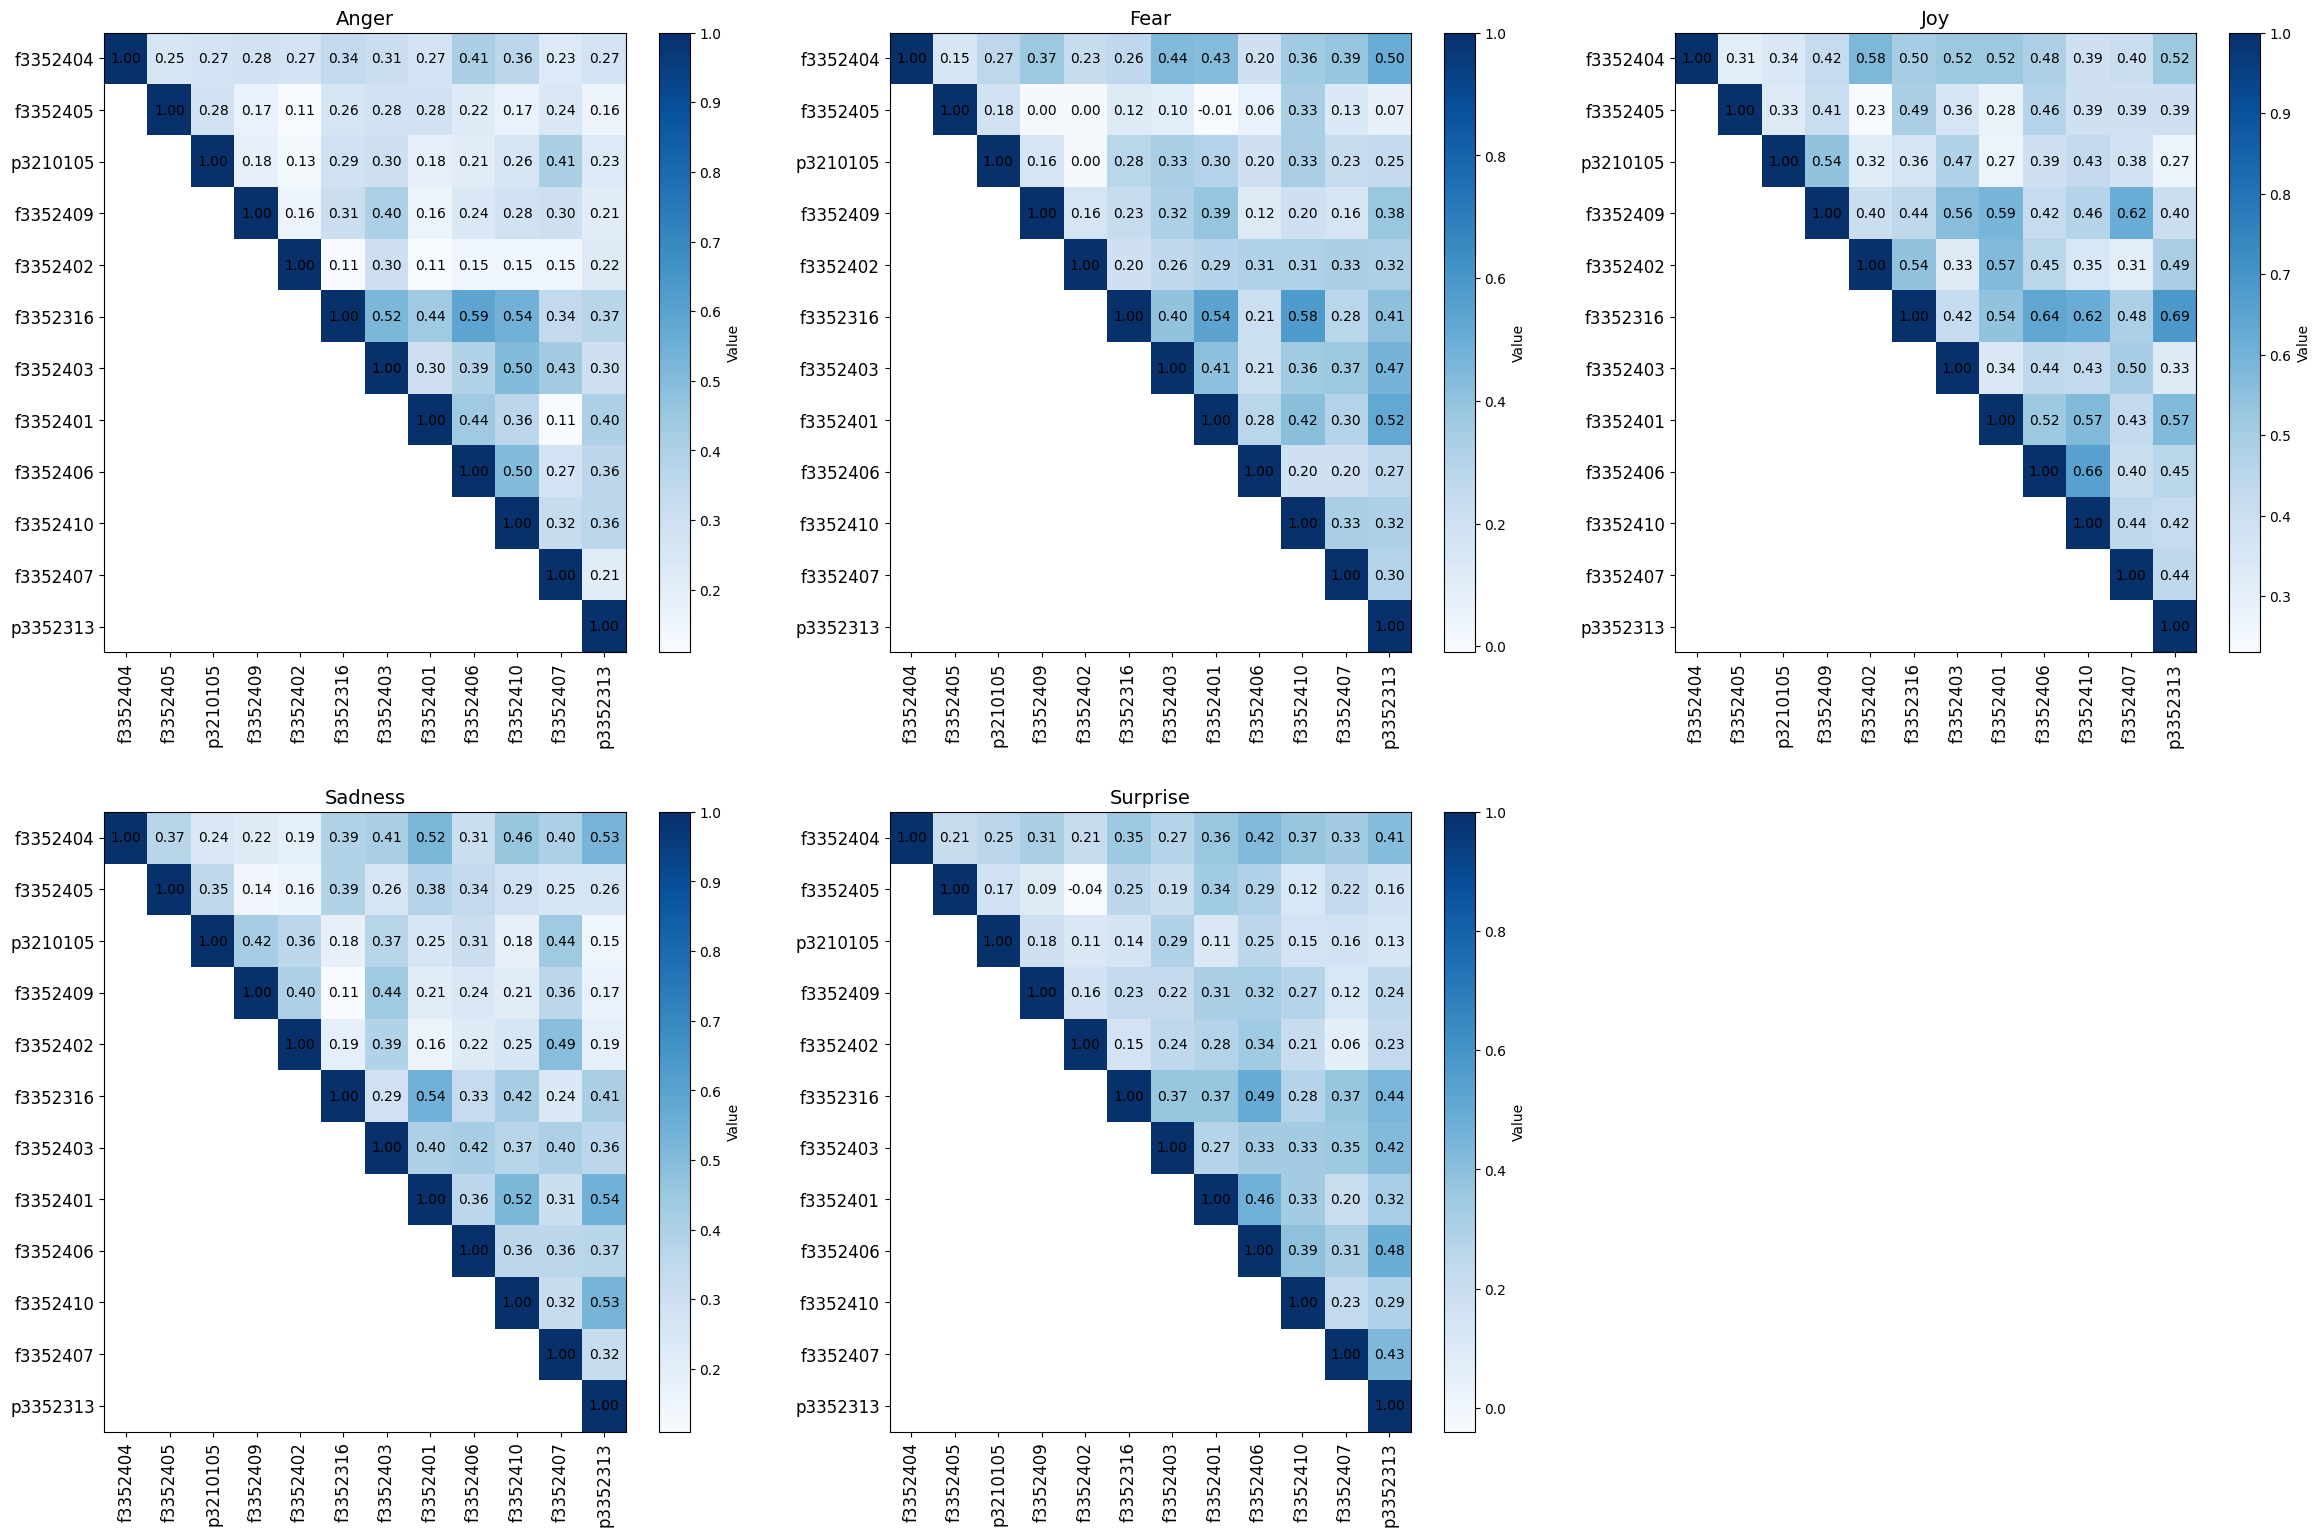

In [68]:
# let's remind the already clculated 
# Example usage
print('=======================Our Best Metric :: Kappa per Emotion =========')
dataframes_percentage = [
    percentage_agreement_matrix_anger, 
    percentage_agreement_matrix_fear, 
    percentage_agreement_matrix_joy, 
    percentage_agreement_matrix_sadness, 
    percentage_agreement_matrix_surprise
]
titles = ["Anger", "Fear", "Joy", "Sadness", "Surprise"]
plot_multiple_heatmaps(dataframes_kappa, titles=titles)
# remind coverage threshold 0.65
# Anger :: Percenatge of coverage having more than 70% values in each cell:  15%
# Fear :: Percenatge of coverage having more than 70% values in each cell:  15%
# Joy :: Percenatge of coverage having more than 70% values in each cell:  18%
# Sadness :: Percenatge of coverage having more than 70% values in each cell:  15%
# Surprise :: Percenatge of coverage having more than 70% values in each cell:  15%

In [69]:
# Display the Kappa scores for each emotion
print("Agents Cohen's Kappa scores per emotion:", kappa_scores)
# Agents Cohen's Kappa scores per emotion: {'Anger': 0.21065088757396455, 'Fear': 0.2646876932591219, 'Joy': 0.2499049068086726, 'Sadness': 0.30364058869093724, 'Surprise': 0.19556171983356452} for these valeus we impe,mented analsys 
# duw to randmness of LLM may be diffrent

Agents Cohen's Kappa scores per emotion: {'Anger': 0.11911852293031566, 'Fear': 0.21670854271356776, 'Joy': 0.31046195652173914, 'Sadness': 0.2183908045977011, 'Surprise': 0.21028744326777604}


=======================Kappa per Emotion =========


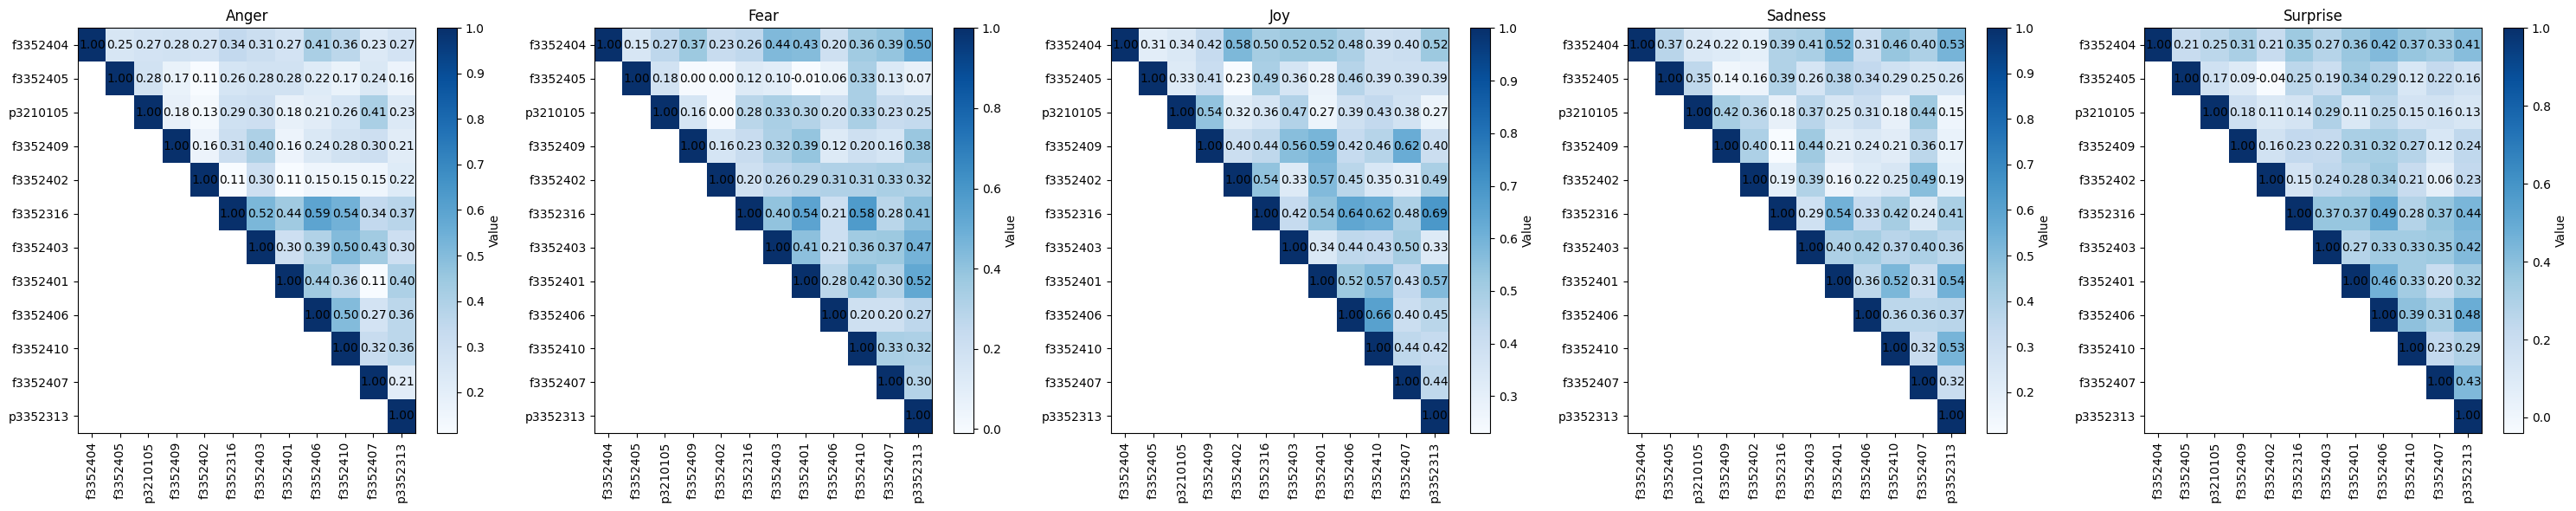

Anger :: Percenatge of coverage having more than 0.12 as values in each cell:  95%
Fear :: Percenatge of coverage having more than 0.22 as values in each cell:  71%
Joy :: Percenatge of coverage having more than 0.31 as values in each cell:  92%
Sadness :: Percenatge of coverage having more than 0.22 as values in each cell:  83%
Surprise :: Percenatge of coverage having more than 0.21 as values in each cell:  73%


In [70]:
#  threshold for each emotion kappa og agent to compare 
print('=======================Kappa per Emotion =========')
dataframes_kappa = [kappa_scores_matrix_anger, kappa_scores_matrix_fear, kappa_scores_matrix_joy, kappa_scores_matrix_sadness, kappa_scores_matrix_surprise]
titles = ["Anger", "Fear", "Joy", "Sadness", "Surprise"]
plot_multiple_heatmaps_layout_1_5(dataframes_kappa, titles=titles)

#   Converting values of teh dataframe to list.
list_kappa_matrix_anger = kappa_scores_matrix_anger.values.tolist()
list_kappa_matrix_fear = kappa_scores_matrix_fear.values.tolist()
list_kappa_matrix_joy = kappa_scores_matrix_joy.values.tolist()
list_kappa_matrix_sadness = kappa_scores_matrix_sadness.values.tolist()
list_kappa_matrix_surprise = kappa_scores_matrix_surprise.values.tolist()

# Flatten the list and filter for values > {kappa_agent}
threshold_agent_anger, threshold_agent_fear, threshold_agent_joy, threshold_agent_sadness, threshold_agent_surprise = \
    kappa_scores['Anger'], kappa_scores['Fear'], kappa_scores['Joy'], kappa_scores['Sadness'], kappa_scores['Surprise']

filtered_flat_list_anger_k = [ value for sublist in list_kappa_matrix_anger  for value in sublist if isinstance(value, (int, float)) and value > threshold_agent_anger] # filter based on threshold of agents kappa
filtered_flat_list_fear_k = [ value for sublist in list_kappa_matrix_fear  for value in sublist if isinstance(value, (int, float)) and value > threshold_agent_fear] # filter based on threshold of agents kappa
filtered_flat_list_joy_k = [ value for sublist in list_kappa_matrix_joy  for value in sublist if isinstance(value, (int, float)) and value > threshold_agent_joy] # filter based on threshold of agents kappa
filtered_flat_list_sadness_k = [ value for sublist in list_kappa_matrix_sadness  for value in sublist if isinstance(value, (int, float)) and value > threshold_agent_sadness] # filter based on threshold of agents kappa
filtered_flat_list_surprise_k = [ value for sublist in list_kappa_matrix_surprise  for value in sublist if isinstance(value, (int, float)) and value > threshold_agent_surprise] # filter based on threshold of agents kappa

print(f'Anger :: Percenatge of coverage having more than {round(threshold_agent_anger,2)} as values in each cell:  {round(len(filtered_flat_list_anger_k)/total_number_of_numbers*100)}%')
print(f'Fear :: Percenatge of coverage having more than {round(threshold_agent_fear,2)} as values in each cell:  {round(len(filtered_flat_list_fear_k)/total_number_of_numbers*100)}%')
print(f'Joy :: Percenatge of coverage having more than {round(threshold_agent_joy,2)} as values in each cell:  {round(len(filtered_flat_list_joy_k)/total_number_of_numbers*100)}%')
print(f'Sadness :: Percenatge of coverage having more than {round(threshold_agent_sadness,2)} as values in each cell:  {round(len(filtered_flat_list_sadness_k)/total_number_of_numbers*100)}%')
print(f'Surprise :: Percenatge of coverage having more than {round(threshold_agent_surprise,2)} as values in each cell:  {round(len(filtered_flat_list_surprise_k)/total_number_of_numbers*100)}%')

- Comments `Kappas Humans` vs `Kappas Agents` 
    - The percentages above (`77%`, `63%`, `99%`, `68%`, `78%`) show the percenatge in which **Humans** pairs of multiple annotators has higher **kappa** value than the pair  of our two agents. 
    - It is obvious that humans have % more than 50% meaning that they seem to agree **more** among them per emotion in comparison to our two agents. 
- Gnerally, in both types of annotators (meaning Humans and Agents) kappa values are relatively low (see analysis A2 for explanation kappa takes in mind by chance concept and imbalance data).
- However, due to our analysis we can focus on the emotions with the **lowest** agreemnt and as insight to tell that in these emotions annotators may need more examples to understand when a sentence we label it with that emotion. 
- So, applying in depth analysis per emotion and observing the coverage percentages with the defined thrshold being kappa values of agents per emotions we can say as a focused diretion: 
    - For humans, as already mentioned, more examples are needed for the emotion : For Humans more  examples are needed for the emotion `Fear` as humans presented the lower coverage percenatge (%63%) copared to the coverage percenatges for the other categories. 
    - Whereas, For Agents more examples are needed for the emotion `Joy` as humans present 99% coverage of values per heat having per individual of heatmaps values more than the current kappa for the current emotion of that of agent. 


# `B`

# `B.1` Basic: Load the English proverbs, which have been translated by Llama-3-8b-instruct. Report any redundant text you find in these.

- We will load our data from the given url that is `https://raw.githubusercontent.com/greek-proverb-atlas/proverbs.gr/refs/heads/main/data/balanced_corpus_en.csv`

In [71]:
# URL of the CSV file
url = "https://raw.githubusercontent.com/greek-proverb-atlas/proverbs.gr/refs/heads/main/data/balanced_corpus_en.csv"
# Load the data into a pandas DataFrame
df_proverbs = pd.read_csv(url)
# Display the first few rows of the DataFrame
df_proverbs# preview our datafarme


,Unnamed: 0,text,place,uri,collector,area,lat,lon,llama-8b
0,105697,Γέλια σαν κομπολόγια,"Ήπειρος, Ζαγόρι, Βίτσα",http://hdl.handle.net/20.500.11853/168435,"Σάρρος, Δημήτριος Μ.",Ήπειρος,37.998253,23.737867,Laughter is like a rosary. (A rosary is a string
1,8413,Καρδίαν καθαράν θέλ' ο Θεός,Ήπειρος,http://hdl.handle.net/20.500.11853/167032,"Γόνιος, Α.",Ήπειρος,37.998253,23.737867,God asks for a clean heart. (Proverb) <|eot_id
2,7684,Ου Θεός κι ου γείτονας,Ήπειρος,http://hdl.handle.net/20.500.11853/168991,"Γαλδέμης, Αναστάσιος Δ.",Ήπειρος,37.998253,23.737867,No God and no neighbor. (meaning that when you...
3,18546,Θέλει να κρυφθή πίσω από το δάχτυλό του,Ήπειρος,http://hdl.handle.net/20.500.11853/273352,"Ζηκίδης, Γεώργιος Δ.",Ήπειρος,37.998253,23.737867,He wants to hide behind his finger. (Proverb: ...
4,94001,Όλοι κλαίν' τα χάλια τ'ς κι ο μυλωνάς τη δέσι,Ήπειρος,http://hdl.handle.net/20.500.11853/204755,"Παπαγεωργίου, Ιωάννης",Ήπειρος,37.998253,23.737867,"All cry over the mess, but the miller is the o..."
...,...,...,...,...,...,...,...,...,...
11495,101735,Παστρζικό τσανα τσ' έναι!,Σκύρος,http://hdl.handle.net/20.500.11853/247609,"Περδίκα, Νίκη Λ.",Σκύρος,38.873044,24.524477,A snake in the grass is not seen! or A snake i...
11496,101233,"Κάλλιο γεναίκα κάμισσα, πέρζι πολυπροικούσα",Σκύρος,http://hdl.handle.net/20.500.11853/195541,"Περδίκα, Νίκη Λ.",Σκύρος,38.873044,24.524477,It is better to have a small profit than a lar...
11497,101612,Όγοιος κάθεται στη στερζά τσαί θάλασσα γερεύει...,Σκύρος,http://hdl.handle.net/20.500.11853/195683,"Περδίκα, Νίκη Λ.",Σκύρος,38.873044,24.524477,The devil of one's backside is always quicker ...
11498,101762,Πήε στ' δαιμόνου τ' μάννα,Σκύρος,http://hdl.handle.net/20.500.11853/195537,"Περδίκα, Νίκη Λ.",Σκύρος,38.873044,24.524477,Take the devil's mother. (Take the devil's mot...


- In order to report `redundant` text we will take a sample of our whole dataset using the formula of `Cochran formula`.
    - We want the sample for two reasons. 
        - Firstly, we aim to extract empirical rules from redundant text, while maximizing their level of `generalization`.
        - Secondly, we will manually apply our empirical rules to transform the text, recording the desired output. This transformed text will serve as a test set for `validating our regex code`.
- Cochran's formula is used to estimate an ideal sample size given a desired confidence level and margin of error. The formula is as follows:

$$
n_0 = \frac{{Z^2 \cdot p \cdot (1 - p)}}{E^2}
$$

where:

- \( n_0 \): Initial sample size (before adjustments for finite populations)
- \( Z \): Z-value (Z-score) corresponding to the desired confidence level (e.g., 1.96 for 95% confidence)
- \( p \): Estimated proportion of the population (if unknown, 0.5 is often used for maximum variability)
- \( E \): Margin of error (as a decimal; e.g., 0.05 for a 5% margin)

- In short, the Cochran formula is designed to estimate a sample size that achieves a specific level of precision for population proportion estimates, particularly in large or infinite populations (in our case `11500` total number of rows).
- We will take `Cochran formula` to define our sample with Margin error equal to 5% (that is a common value).
    - A 5% margin of error means that the results of a survey or study can vary by up to 5 percentage points in either direction from the actual population value. 
    - This margin represents the range within which the true population parameter is expected to lie, given the sample data.
- Let's calculate it.

In [72]:
# Given parameters
Z = 1.96   # Z-score for 95% confidence level
p = 0.5    # Estimated proportion of the population (use 0.5 if unknown)
E =  0.05   # Margin of error (5%)
N = 11500  # Population size

# Calculate the sample size using the finite population correction formula
numerator = Z**2 * p * (1 - p)
denominator = E**2 + (numerator / N)
sample_size = numerator / denominator

# Display the result
print(f"The required sample size is approximately: {round(sample_size)}")

The required sample size is approximately: 372


- Having calculated the needed number of our sample that is equal to 372, we will define our sample.
- We will save our sample to a csv file named `backup_redundant_analysis_redundant_proverbs.csv` in the folder `regex_rules_manually`.
- Then we manually analyse our sample and we will extend the aforementiones csv with helpful columns.
- Note the `sep` of which is `$` for practical reasons (e.g. proverbs conatin many commas). 
- Manually work process / analysis:
    - We extended our csv with 2 additional columns 
        - `category` conataining the potential category\rule of the detected redundant text (potantial regex rule).
        - `test_applied_regex` we manually applied the rules for each category to create a test dataset, allowing us to verify the effectiveness of our regex patterns.
    - If the text does not contain redundant content, we label it as `none`.
- In essence, our methodology involved manually identifying redundant text within our sample. 
    - in a number of sample that would be generaliased thanks to **Cochran Formula**.

In [73]:
sample_size = round(sample_size) #round the number of sample if needs
# Take a random sample
random_sample_proverbs = df_proverbs[['text', 'llama-8b']].sample(n=sample_size, random_state=1) # pass the number of sample to manually examined. 
# deactivate the command to save in csv as it is already saved for reproduction reasons. 
# random_sample_proverbs.to_csv('analysis_redundant_proverbs.csv', sep='$', index=False) # already saved in folder: regex_rues_manually

In [74]:
# Reading the CSV file with sep: '$' as the separator
df_analysis_redundant_record = pd.read_csv('regex_rules_manually/backup_analysis_redundant_text.csv', sep='$', engine='python', on_bad_lines='skip')
df_analysis_redundant_record.head(3) # preview 3 

,text,llama-8b,category,test_applied_regex
0,Αυτιά και μάτια τέντωνε και μάζευε τη γλώσσα,"He who has ears to hear, let him hear. or He...",dot_blank_blank_or_blank,"He who has ears to hear, let him hear."
1,Έπεσε μικρός,He fell as a child. (It means he fell from a g...,dot_blank_parentesis,He fell as a child.
2,Ο κλέφτης πααίνει μακριά και ο τσιγγούνης δίνε...,The thief runs far away and the gypsy gives a ...,dot_blank_parentesis,The thief runs far away and the gypsy gives a ...


- Let's analyse the column `category` to see the potential 'recorded' redundant text cases.
    - we will use `value_counts()` function of pands as it offers both "unique" categories with the number of their frequences. 

In [75]:
#the recorded categories with redundant text
df_analysis_redundant_record.category.value_counts()

category
dot_blank_parentesis                                            141
none                                                             71
remove_<|eot_id|>                                                41
dot_blank_blank_parethesis                                       18
after_thafmastiko_blank_parenthesis                               5
remove_<|eot_id                                                   5
remove_<|eot                                                      4
remove_<|eot_id|                                                  4
dot_blank_or_blank                                                4
remove_<|                                                         4
dot_blank_blank_or_blank                                          3
?                                                                 3
remove_after_The original proverb                                 1
thafmastiko_blank_blank_parenthesis                               1
remove_<                               

- We can observe that many of these categories could be merged to one generalised `category` and as a result to one generalised `regex` in the next task (that is `B2`).
- at first glance , 2 main merges can be applied : 
    - categories contain `parenthesis` (containing translation, explanations) (e.g. 'He fell as a child. (It means he fell from a great height)')
    - categories contain `useless characters&symbols` (e.g. |eot_id|)
- let's delve into these catagories more in order to see their context.

In [76]:
print('=============== Investigate Removal Text Categories ================')

print('================== Category 1: dot_blank_parentesis ===============')
print(f"The Initial Proberb: {list(df_analysis_redundant_record['text'][df_analysis_redundant_record['category'] == 'dot_blank_parentesis'][0:1])}")
print(f"The translated proverb: {list(df_analysis_redundant_record['llama-8b'][df_analysis_redundant_record['category'] == 'dot_blank_parentesis'][0:1])}")

print('========= Category 2: dot_blank_blank_parethesis ==========')
print(f"The Initial Proberb: {list(df_analysis_redundant_record['text'][df_analysis_redundant_record['category'] == 'dot_blank_blank_parethesis'][0:1])}")
print(f"The translated proverb: {list(df_analysis_redundant_record['llama-8b'][df_analysis_redundant_record['category'] == 'dot_blank_blank_parethesis'][0:1])}")

print('========= Category 3: after_thafmastiko_blank_parenthesis ==========')
print(f"The Initial Proberb: {list(df_analysis_redundant_record['text'][df_analysis_redundant_record['category'] == 'after_thafmastiko_blank_parenthesis'][0:1])}")
print(f"The translated proverb: {list(df_analysis_redundant_record['llama-8b'][df_analysis_redundant_record['category'] == 'after_thafmastiko_blank_parenthesis'][0:1])}")

print('========= Category 4: thafmastiko_blank_blank_parenthesis ==========')
print(f"The Initial Proberb: {list(df_analysis_redundant_record['text'][df_analysis_redundant_record['category'] == 'thafmastiko_blank_blank_parenthesis'][0:1])}")
print(f"The translated proverb: {list(df_analysis_redundant_record['llama-8b'][df_analysis_redundant_record['category'] == 'thafmastiko_blank_blank_parenthesis'][0:1])}")

=============== Investigate Removal Text Categories ================
================== Category 1: dot_blank_parentesis ===============
The Initial Proberb: ['Έπεσε μικρός']
The translated proverb: ['He fell as a child. (It means he fell from a great height)']
========= Category 2: dot_blank_blank_parethesis ==========
The Initial Proberb: ['Ώσπου να μη με δή κανείς']
The translated proverb: ["Until no one can see me.  (Don't leave me alone)"]
========= Category 3: after_thafmastiko_blank_parenthesis ==========
The Initial Proberb: ['Τι Γιάννης, τι Γιαννάκης!']
The translated proverb: ['What John, what Johnny! (meaning: What a mess, what a disaster']
========= Category 4: thafmastiko_blank_blank_parenthesis ==========
The Initial Proberb: ['Άρον – άρον!']
The translated proverb: ['Take it or leave it!  (Literally: Either take it or leave']


- **General Comment for the first category** : all data in parenthesis related to explanation, literally mening, additional result.
    - In other words, the data inside the parenhesis contain additional information (not being the "actual" translation).
    - So, we will remove it via `regex`
    - For being ready for the task `B2` we will write the general format of our regex related to the current category 
        - In the next phase, we will perform large-scale testing on our manually curated dataset, `backup_analysis_redundant_text.csv` , specifically focusing on the `test_applied_regex` column. 
    
- `REGEX RULE` : `re.sub(r'[.!]\s{1,2}\(.*', '', text)`
    - This regex removes any text following a period or exclamation mark with one or two spaces and an opening parenthesis. It effectively deletes everything after patterns like . ( or ! ( in the text.
- Now, we will continue with the second category that can be merged related to the removal of useless characters.

In [77]:
print('=============== Investigate Parenthesis Categories ================')

print('================== Category 1: remove_<|eot_id|>   ===============')
print(f"The Initial Proberb: {list(df_analysis_redundant_record['text'][df_analysis_redundant_record['category'] == 'remove_<|eot_id|>'][0:1])}")
print(f"The translated proverb: {list(df_analysis_redundant_record['llama-8b'][df_analysis_redundant_record['category'] == 'remove_<|eot_id|>'][0:1])}")

print('========= Category 2: remove_<|eot_id ==========')
print(f"The Initial Proberb: {list(df_analysis_redundant_record['text'][df_analysis_redundant_record['category'] == 'remove_<|eot_id'][0:1])}")
print(f"The translated proverb: {list(df_analysis_redundant_record['llama-8b'][df_analysis_redundant_record['category'] == 'remove_<|eot_id'][0:1])}")

print('========= Category 3: remove_<|eot ==========')
print(f"The Initial Proberb: {list(df_analysis_redundant_record['text'][df_analysis_redundant_record['category'] == 'remove_<|eot'][0:1])}")
print(f"The translated proverb: {list(df_analysis_redundant_record['llama-8b'][df_analysis_redundant_record['category'] == 'remove_<|eot'][0:1])}")

print('========= Category 4: remove_<|eot_id| ==========')
print(f"The Initial Proberb: {list(df_analysis_redundant_record['text'][df_analysis_redundant_record['category'] == 'remove_<|eot_id|'][0:1])}")
print(f"The translated proverb: {list(df_analysis_redundant_record['llama-8b'][df_analysis_redundant_record['category'] == 'remove_<|eot_id|'][0:1])}")

print('========= Category 5: remove_<|  ==========')
print(f"The Initial Proberb: {list(df_analysis_redundant_record['text'][df_analysis_redundant_record['category'] == 'remove_<|'][0:1])}")
print(f"The translated proverb: {list(df_analysis_redundant_record['llama-8b'][df_analysis_redundant_record['category'] == 'remove_<|'][0:1])}")#

print('========= Category 6: remove_.<|e  ==========')
print(f"The Initial Proberb: {list(df_analysis_redundant_record['text'][df_analysis_redundant_record['category'] == 'blank_blank_<|'][0:1])}")
print(f"The translated proverb: {list(df_analysis_redundant_record['llama-8b'][df_analysis_redundant_record['category'] == 'blank_blank_<|'][0:1])}")

print('========= Category 7: remove_<|eot_ ==========')
print(f"The Initial Proberb: {list(df_analysis_redundant_record['text'][df_analysis_redundant_record['category'] == 'remove_<|eot_id|>Δ'][0:1])}")
print(f"The translated proverb: {list(df_analysis_redundant_record['llama-8b'][df_analysis_redundant_record['category'] == 'remove_<|eot_id|>Δ'][0:1])}")#

print('========= Category 8: remove_<|eot_id|>Δ  ==========')
print(f"The Initial Proberb: {list(df_analysis_redundant_record['text'][df_analysis_redundant_record['category'] == 'remove_<'][0:1])}")
print(f"The translated proverb: {list(df_analysis_redundant_record['llama-8b'][df_analysis_redundant_record['category'] == 'remove_<'][0:1])}")

print('========= Category 9: remove_< ==========')
print(f"The Initial Proberb: {list(df_analysis_redundant_record['text'][df_analysis_redundant_record['category'] == 'remove_<'][0:1])}")
print(f"The translated proverb: {list(df_analysis_redundant_record['llama-8b'][df_analysis_redundant_record['category'] == 'remove_<'][0:1])}")

print('========= Category 10: remove_The English translation of the proverb is: ==========')
print(f"The Initial Proberb: {list(df_analysis_redundant_record['text'][df_analysis_redundant_record['category'] == 'rempve_The _ranslation_of_the_given_proverb _in_English_is:_'][0:1])}")
print(f"The translated proverb: {list(df_analysis_redundant_record['llama-8b'][df_analysis_redundant_record['category'] == 'rempve_The _ranslation_of_the_given_proverb _in_English_is:_'][0:1])}")

=============== Investigate Parenthesis Categories ================
================== Category 1: remove_<|eot_id|>   ===============
The Initial Proberb: ['Αδειανή κοιλιά, σαρακοστές δεν ξέρει']
The translated proverb: ['An empty belly, does not know Lent<|eot_id|>']
========= Category 2: remove_<|eot_id ==========
The Initial Proberb: ['Δώδέκα Σοποτεινοί, δέκα τρία καλαμάργια']
The translated proverb: ['Twelve soothsayers, thirteen windmills<|eot_id']
========= Category 3: remove_<|eot ==========
The Initial Proberb: ["Νύφ' από τζάκι και σκύλλ' από κοπάδι"]
The translated proverb: ['A bride from a fireplace and a beggar from a flock<|eot']
========= Category 4: remove_<|eot_id| ==========
The Initial Proberb: ["Όποιος φτάνει αργά, στέκετ' ολόρθος!"]
The translated proverb: ['He who arrives late, stays in the cold! <|eot_id|']
========= Category 5: remove_<|  ==========
The Initial Proberb: ["Ο γέρος κι' αν επαινεύτηκε, ο ανήφορος του δείχνει"]
The translated proverb: ['The old man, 

- General Comment for the category related to "useless" charactares&symbols inside the text. 
    - All extraneous characters, such as <|eot_id|>Δ in the sentence "Does not boil with the broth of others`<|eot_id|>Δ`, are unnecessary and will therefore be removed.
    - In other words we want to remove from our sentences the following useless strings: 
        1. `<|eot_id|>`
        2. `<|eot_id|>`
        3. `<|eot_id`
        4. `<|eot_id`
        5. `<|eot`
        6. `<|eot_id|`
        7. `The translation of the given proverb in English is:`
        8. `<`
        9. `<|eot_id|>Δ`
        10. `<|eot_id|`
- `REGEX RULE`: `re.sub(r'(<\|?eot?_?id?\|?>?Δ?|The translation of the given proverb in English is:)`
    - The pattern (<\|?eot?_?id?\|?>?Δ?|The translation of the given proverb in English is:) **matches variations of** <|eot_id|>, optional fragments like <|eot, and the exact phrase "The translation of the given proverb in English is:".

In [78]:
print('=============== Investigate Useless Charactes ================')
print(f"The Initial Proberb: {list(df_analysis_redundant_record['text'][df_analysis_redundant_record['category'] == 'remove_<|eot_id|>'][0:1])}")
print(f"The translated proverb: {list(df_analysis_redundant_record['llama-8b'][df_analysis_redundant_record['category'] == 'remove_<|eot_id|>'][0:1])}")

print(f"The Initial Proberb: {list(df_analysis_redundant_record['text'][df_analysis_redundant_record['category'] == 'remove_<|eot_id'][0:1])}")
print(f"The translated proverb: {list(df_analysis_redundant_record['llama-8b'][df_analysis_redundant_record['category'] == 'remove_<|eot_id'][0:1])}")

print(f"The Initial Proberb: {list(df_analysis_redundant_record['text'][df_analysis_redundant_record['category'] == 'remove_<|eot'][0:1])}")
print(f"The translated proverb: {list(df_analysis_redundant_record['llama-8b'][df_analysis_redundant_record['category'] == 'remove_<|eot'][0:1])}")

print(f"The Initial Proberb: {list(df_analysis_redundant_record['text'][df_analysis_redundant_record['category'] == 'remove_<|eot_id|'][0:1])}")
print(f"The translated proverb: {list(df_analysis_redundant_record['llama-8b'][df_analysis_redundant_record['category'] == 'remove_<|eot_id|'][0:1])}")

print(f"The Initial Proberb: {list(df_analysis_redundant_record['text'][df_analysis_redundant_record['category'] == 'remove_<|'][0:1])}")
print(f"The translated proverb: {list(df_analysis_redundant_record['llama-8b'][df_analysis_redundant_record['category'] == 'remove_<|'][0:1])}")#

print(f"The Initial Proberb: {list(df_analysis_redundant_record['text'][df_analysis_redundant_record['category'] == 'blank_blank_<|'][0:1])}")
print(f"The translated proverb: {list(df_analysis_redundant_record['llama-8b'][df_analysis_redundant_record['category'] == 'blank_blank_<|'][0:1])}")

print('========= Category 7: remove_<|eot_ ==========')
print(f"The Initial Proberb: {list(df_analysis_redundant_record['text'][df_analysis_redundant_record['category'] == 'remove_<|eot_id|>Δ'][0:1])}")
print(f"The translated proverb: {list(df_analysis_redundant_record['llama-8b'][df_analysis_redundant_record['category'] == 'remove_<|eot_id|>Δ'][0:1])}")#

print('========= Category 8: remove_<|eot_id|>Δ  ==========')
print(f"The Initial Proberb: {list(df_analysis_redundant_record['text'][df_analysis_redundant_record['category'] == 'remove_<'][0:1])}")
print(f"The translated proverb: {list(df_analysis_redundant_record['llama-8b'][df_analysis_redundant_record['category'] == 'remove_<'][0:1])}")

print('========= Category 9: remove_< ==========')
print(f"The Initial Proberb: {list(df_analysis_redundant_record['text'][df_analysis_redundant_record['category'] == 'remove_<'][0:1])}")
print(f"The translated proverb: {list(df_analysis_redundant_record['llama-8b'][df_analysis_redundant_record['category'] == 'remove_<'][0:1])}")

print('========= Category 10: remove_The English translation of the proverb is: ==========')
print(f"The Initial Proberb: {list(df_analysis_redundant_record['text'][df_analysis_redundant_record['category'] == 'rempve_The _ranslation_of_the_given_proverb _in_English_is:_'][0:1])}")
print(f"The translated proverb: {list(df_analysis_redundant_record['llama-8b'][df_analysis_redundant_record['category'] == 'rempve_The _ranslation_of_the_given_proverb _in_English_is:_'][0:1])}")

=============== Investigate Useless Charactes ================
The Initial Proberb: ['Αδειανή κοιλιά, σαρακοστές δεν ξέρει']
The translated proverb: ['An empty belly, does not know Lent<|eot_id|>']
The Initial Proberb: ['Δώδέκα Σοποτεινοί, δέκα τρία καλαμάργια']
The translated proverb: ['Twelve soothsayers, thirteen windmills<|eot_id']
The Initial Proberb: ["Νύφ' από τζάκι και σκύλλ' από κοπάδι"]
The translated proverb: ['A bride from a fireplace and a beggar from a flock<|eot']
The Initial Proberb: ["Όποιος φτάνει αργά, στέκετ' ολόρθος!"]
The translated proverb: ['He who arrives late, stays in the cold! <|eot_id|']
The Initial Proberb: ["Ο γέρος κι' αν επαινεύτηκε, ο ανήφορος του δείχνει"]
The translated proverb: ['The old man, even if he was praised, his hill shows him<|,']
The Initial Proberb: []
The translated proverb: []
========= Category 7: remove_<|eot_ ==========
The Initial Proberb: ["Δε βράζ' με το ζουμί τ'"]
The translated proverb: ['Does not boil with the broth of others<|

- Now, we will merge categories related to the word `or`.

In [79]:
print('=============== Investigate Or meaning ================')
print(f"The Initial Proberb: {list(df_analysis_redundant_record['text'][df_analysis_redundant_record['category'] == 'dot_blank_blank_or_blank'][0:1])}")
print(f"The translated proverb: {list(df_analysis_redundant_record['llama-8b'][df_analysis_redundant_record['category'] == 'dot_blank_blank_or_blank'][0:1])}")

print(f"The Initial Proberb: {list(df_analysis_redundant_record['text'][df_analysis_redundant_record['category'] == 'dot_blank_or_blank'][0:1])}")
print(f"The translated proverb: {list(df_analysis_redundant_record['llama-8b'][df_analysis_redundant_record['category'] == 'dot_blank_or_blank'][0:1])}")

=============== Investigate Or meaning ================
The Initial Proberb: ['Αυτιά και μάτια τέντωνε και μάζευε τη γλώσσα']
The translated proverb: ['He who has ears to hear, let him hear.  or  He who']
The Initial Proberb: ["Ου καλός καλό δεν έχ'"]
The translated proverb: ['No good is good enough. or Nothing is perfect. or Nothing is good enough']


- We observe that the translation expresses the same idea in alternative ways (using `or`), resulting in redundancy.
- Related regex `text = re.sub(r'\.\s{1,2}or.*', '.', text)`
- Note: we merged the majority categories containing the most detetced redundant for some categories specisl containing one element wemay be  ignored. 
- So, let's report the redundant categories of text with their corresponding regex patterns at first glance (in B2 vai empirically analysis / applied regex technoque we may extend them to a ertain extent). 
    - 1.  Removel data in parentesis for **specific** formats (`REGEX RULE` : `re.sub(r'[.!]\s{1,2}\(.*', '', text)`)
        - For specific format is crucial because there are parenthesis that should not be removed 
            - e.g. `Ο γαμπρός είναι λαβρός (και) θέλει την αλούστα πεθερά την όμορφη γυναίκα`$`The son-in-law is cunning (and) wants the beautiful mother-in-law the` we want at this case to hold the parenthesis it is not redundant. So, it plays role format like blank blank parentheis etc.
    - 2.  Revoval of useless characters. (`REGEX RULE`: `re.sub(r'(<\|?eot?_?id?\|?>?Δ?|The translation of the given proverb in English is:)`)
    - 3. Removal of `or` (`REGEX RULE`: `re.sub(r'\.\s{1,2}or.*', '.', text)`, this regex is to match and retain text up to ".  or" or ". or" and remove everything after)

# `B2`  Preprocessing: Using Regular Expressions, post-process the outcome by removing redundant text (e.g., following the translation in parenthesis).

- Applying our regex rule from `B1` we have the following function `apply_regex_patterns_approach_1`.
- Extend our datafarme (`df_analysis_redundant_record`) with an additioanl column: `applied_regex_approach_1`.
    - Having the final contect of column "llama-8b" after applying our regex empirical rules.

In [80]:
# Function to apply both regex substitutions to each text
def apply_regex_patterns_approach_1(text):
    # Apply the first pattern to remove any text following `. (` or `! (`
    text = re.sub(r'[.!]\s{1,2}\(.*', '', text)#1. category parethesis
    # Apply the second pattern to remove specified strings and phrases
    text = re.sub(r'(<\|?eot?_?id?\|?>?Δ?|The translation of the given proverb in English is:)', '', text) #2. category useless characters 
    text = re.sub(r'\.\s{1,2}or.*', '.', text) # 3. category or 
    return text

# Apply the regex transformations and store in a new column 'applied_regex_approach_1'
df_analysis_redundant_record['applied_regex_approach_1'] = df_analysis_redundant_record['llama-8b'].apply(apply_regex_patterns_approach_1)

# Display the modified DataFrame with the applied regex results
df_analysis_redundant_record

,text,llama-8b,category,test_applied_regex,applied_regex_approach_1
0,Αυτιά και μάτια τέντωνε και μάζευε τη γλώσσα,"He who has ears to hear, let him hear. or He...",dot_blank_blank_or_blank,"He who has ears to hear, let him hear.","He who has ears to hear, let him hear."
1,Έπεσε μικρός,He fell as a child. (It means he fell from a g...,dot_blank_parentesis,He fell as a child.,He fell as a child
2,Ο κλέφτης πααίνει μακριά και ο τσιγγούνης δίνε...,The thief runs far away and the gypsy gives a ...,dot_blank_parentesis,The thief runs far away and the gypsy gives a ...,The thief runs far away and the gypsy gives a lot
3,Ξύει τα νύχια του για καυγά,He sharpens his nails for a fight. (Translatio...,dot_blank_parentesis,He sharpens his nails for a fight.,He sharpens his nails for a fight
4,Πάσ' στηγ κόντραν τομ μιμίτιν έβκαλα τζαί σταφ...,Every cloud has a silver lining.,none,Every cloud has a silver lining.,Every cloud has a silver lining.
...,...,...,...,...,...
307,"Κάπου μ' εί(δ)ες, κάπου σ' εί(δ)α κάπου εί(δ)ε...","Somewhere you said it, somewhere I said it, so...",none,"Somewhere you said it, somewhere I said it, so...","Somewhere you said it, somewhere I said it, so..."
308,Παίρνει κι' από μισόλογα!,He takes even half-words. (English translation...,dot_blank_parentesis,He takes even half-words.,He takes even half-words
309,"Το βουβάλι κι αν ξεπέση, σε βοϊδιού μποχά θα πέση","Even if a buffalo were to jump, it would land ...",none,"Even if a buffalo were to jump, it would land ...","Even if a buffalo were to jump, it would land ..."
310,"Λιάννα, να δράμω θέλω, λε να σε δώ θέλω, παιδί...","I want to make you cry, my child, I want to gi...",none,"I want to make you cry, my child, I want to gi...","I want to make you cry, my child, I want to gi..."


- Fine! our change passed the last column ofthe df is our new one.
- Remove potential "noise" coming from the existence of `.` (dot) as last character in the string in columns : `test_apppled_regex`, `applied_regex`.

In [81]:
df_analysis_redundant_record['test_applied_regex'] = df_analysis_redundant_record['test_applied_regex'].str.rstrip('.')
df_analysis_redundant_record['applied_regex_approach_1'] = df_analysis_redundant_record['applied_regex_approach_1'].str.rstrip('.') # remove . to focus on regex context not on . diffrence 
df_analysis_redundant_record['applied_regex_approach_1'] = df_analysis_redundant_record['applied_regex_approach_1'].str.rstrip('!') # remove . to focus on regex context not on ! diffrence 
df_analysis_redundant_record['test_applied_regex'] = df_analysis_redundant_record['test_applied_regex'].str.rstrip('!')

- Let's leverage our validation test we created to check if our regex rules applied properly.

In [82]:
# Select rows where 'col1' and 'col2' are different
df_different_rows_after_applied_regexes = df_analysis_redundant_record[df_analysis_redundant_record['test_applied_regex'] != df_analysis_redundant_record['applied_regex_approach_1']]
df_different_rows_after_applied_regexes[['test_applied_regex','applied_regex_approach_1']]

,test_applied_regex,applied_regex_approach_1
16,What can the master do for you when he doesn't...,What can the master do for you when he doesn't...
43,"They trust in the desert, and the wilderness i...","They trust in the desert, and the wilderness i..."
55,"The old man, even if he was praised, his hill ...","The old man, even if he was praised, his hill ..."
57,"In the morning, the crow has a clean face","In the morning, the crow has a clean face. In..."
58,A bride from a fireplace and a beggar from a f...,A bride from a fireplace and a beggar from a f...
59,This is now charcoal,This is now charcoal. The original proverb is:...
72,"He who arrives late, stays in the cold","He who arrives late, stays in the cold!"
99,"When the old woman reached May, she kicked the...","When the old woman reached May, she kicked the..."
105,This is the dress of the Pefki,This is the dress of the Pefki (a region in Gr...
111,None,"All my vineyards are mine and my wine is mine,..."


In [83]:
# df_different_rows_after_applied_regexes.shape[0]# 32

- We observe that in ~`32` rows we have not to the willing result.
    - Note: it is a low number to the total number of our sample.
- It is logic to have some diffrences due to manual effort to extract rules. 
- So, we will try to extend `regexes` (preprocess) in order  to eliminate the diffrences.
- Frstly, we will remove additional the following "useless" characters : `<|eot`,`<|e` 
- Note: for each extension of our regexes we create a new function, e.g.  `apply_regex_patterns_approach_2`

In [84]:
# Function to apply both regex substitutions to each text
def apply_regex_patterns_approach_2(text):
    # Apply the first pattern to remove any text following `. (` or `! (`
    text = re.sub(r'[.!]\s{1,2}\(.*', '', text)
    # Apply the second pattern to remove specified strings and phrases
    text = re.sub(r'(<\|?eot?_?id?\|?>?Δ?|The translation of the given proverb in English is:|\||<\||<\|eot|<\|e)', '', text)
    text = re.sub(r'\.\s{1,2}or.*', '.', text) # category or 
    return text

# Apply the regex transformations and store in a new column 'applied_regex'
df_analysis_redundant_record['applied_regex_approach_2'] = df_analysis_redundant_record['llama-8b'].apply(apply_regex_patterns_approach_2)

# Display the modified DataFrame with the applied regex results
df_analysis_redundant_record

,text,llama-8b,category,test_applied_regex,applied_regex_approach_1,applied_regex_approach_2
0,Αυτιά και μάτια τέντωνε και μάζευε τη γλώσσα,"He who has ears to hear, let him hear. or He...",dot_blank_blank_or_blank,"He who has ears to hear, let him hear","He who has ears to hear, let him hear","He who has ears to hear, let him hear."
1,Έπεσε μικρός,He fell as a child. (It means he fell from a g...,dot_blank_parentesis,He fell as a child,He fell as a child,He fell as a child
2,Ο κλέφτης πααίνει μακριά και ο τσιγγούνης δίνε...,The thief runs far away and the gypsy gives a ...,dot_blank_parentesis,The thief runs far away and the gypsy gives a lot,The thief runs far away and the gypsy gives a lot,The thief runs far away and the gypsy gives a lot
3,Ξύει τα νύχια του για καυγά,He sharpens his nails for a fight. (Translatio...,dot_blank_parentesis,He sharpens his nails for a fight,He sharpens his nails for a fight,He sharpens his nails for a fight
4,Πάσ' στηγ κόντραν τομ μιμίτιν έβκαλα τζαί σταφ...,Every cloud has a silver lining.,none,Every cloud has a silver lining,Every cloud has a silver lining,Every cloud has a silver lining.
...,...,...,...,...,...,...
307,"Κάπου μ' εί(δ)ες, κάπου σ' εί(δ)α κάπου εί(δ)ε...","Somewhere you said it, somewhere I said it, so...",none,"Somewhere you said it, somewhere I said it, so...","Somewhere you said it, somewhere I said it, so...","Somewhere you said it, somewhere I said it, so..."
308,Παίρνει κι' από μισόλογα!,He takes even half-words. (English translation...,dot_blank_parentesis,He takes even half-words,He takes even half-words,He takes even half-words
309,"Το βουβάλι κι αν ξεπέση, σε βοϊδιού μποχά θα πέση","Even if a buffalo were to jump, it would land ...",none,"Even if a buffalo were to jump, it would land ...","Even if a buffalo were to jump, it would land ...","Even if a buffalo were to jump, it would land ..."
310,"Λιάννα, να δράμω θέλω, λε να σε δώ θέλω, παιδί...","I want to make you cry, my child, I want to gi...",none,"I want to make you cry, my child, I want to gi...","I want to make you cry, my child, I want to gi...","I want to make you cry, my child, I want to gi..."


In [85]:
# Select rows where 'col1' and 'col2' are different
df_analysis_redundant_record['applied_regex_approach_2'] = df_analysis_redundant_record['applied_regex_approach_2'].str.rstrip('.') # remove "noise" coming from punctuations 
df_analysis_redundant_record['test_applied_regex'] = df_analysis_redundant_record['test_applied_regex'].str.rstrip('.') # remove "noise" coming from punctuations 
df_analysis_redundant_record['applied_regex_approach_2'] = df_analysis_redundant_record['applied_regex_approach_2'].str.rstrip('!') # remove "noise" coming from punctuations 
df_analysis_redundant_record['test_applied_regex'] = df_analysis_redundant_record['test_applied_regex'].str.rstrip('!') # remove "noise" coming from punctuations 

# Define a function to remove leading commas and spaces
# Define a function to remove leading commas and spaces, handling None values
def clean_leading_commas_and_spaces(text):
    if text is None:
        return text  # Return None if the cell value is None
    return text.lstrip(', ').strip()  # Removes leading commas and spaces otherwise
df_analysis_redundant_record['llama-8b'] = df_analysis_redundant_record['llama-8b'].str.replace(r'[\n\r]+', '', regex=True)#remove new lines


# Apply the function to the target column
df_analysis_redundant_record['test_applied_regex'] = df_analysis_redundant_record['test_applied_regex'].apply(clean_leading_commas_and_spaces)
df_analysis_redundant_record['applied_regex_approach_2'] = df_analysis_redundant_record['applied_regex_approach_2'].apply(clean_leading_commas_and_spaces)


df_different_rows_after_applied_regexes = df_analysis_redundant_record[df_analysis_redundant_record['test_applied_regex'] != df_analysis_redundant_record['applied_regex_approach_2']]
df_different_rows_after_applied_regexes[['test_applied_regex','applied_regex_approach_2']]

,test_applied_regex,applied_regex_approach_2
55,"The old man, even if he was praised, his hill ...","The old man, even if he was praised, his hill ..."
57,"In the morning, the crow has a clean face","In the morning, the crow has a clean face. In..."
58,A bride from a fireplace and a beggar from a f...,A bride from a fireplace and a beggar from a f...
59,This is now charcoal,This is now charcoal. The original proverb is:...
72,"He who arrives late, stays in the cold","He who arrives late, stays in the cold!"
99,"When the old woman reached May, she kicked the...","When the old woman reached May, she kicked the..."
105,This is the dress of the Pefki,This is the dress of the Pefki (a region in Gr...
111,None,"All my vineyards are mine and my wine is mine,..."
112,You've caught the May bug.,You've caught the May bug
136,It's nails and meat,It's nails and meat. Meaning: It's a bit of ev...


In [86]:
df_different_rows_after_applied_regexes.shape[0]

29

- From 32 difrences we went to 29.
    - A slight improvement presented.

In [87]:
# # Assuming your DataFrame is named df
# df_different_rows_after_applied_regexes[['test_applied_regex','applied_regex_approach_2']].to_csv('extend_approach_2.csv', index=False)

- As final "improvemnet" in our regexes we will add to remove isolated `eot`, too. 
- Again we create the new function (`apply_regex_patterns_approach_3`) with adapted the new rule in our related regex.

In [88]:
# Function to apply both regex substitutions to each text
def apply_regex_patterns_approach_3(text):
    # Apply the first pattern to remove any text following `. (` or `! (`
    text = re.sub(r'[.!]\s{1,2}\(.*', '', text)
    # Apply the second pattern to remove specified strings and phrases
    
    text = re.sub(r'(<\|?eot?_?id?\|?>?Δ?|The translation of the given proverb in English is:|\||<\||<\|eot|<\|e)', '', text)
    # Extended regex to remove "eot" as an isolated word along with other patterns
    text = re.sub(r'\s*eot\b$', '', text)
    
    text = re.sub(r'\.\s{1,2}or.*', '.', text) # category or 
    return text

# Apply the regex transformations and store in a new column 'applied_regex'
df_analysis_redundant_record['applied_regex_approach_3'] = df_analysis_redundant_record['llama-8b'].apply(apply_regex_patterns_approach_3)

# Display the modified DataFrame with the applied regex results
df_analysis_redundant_record

,text,llama-8b,category,test_applied_regex,applied_regex_approach_1,applied_regex_approach_2,applied_regex_approach_3
0,Αυτιά και μάτια τέντωνε και μάζευε τη γλώσσα,"He who has ears to hear, let him hear. or He...",dot_blank_blank_or_blank,"He who has ears to hear, let him hear","He who has ears to hear, let him hear","He who has ears to hear, let him hear","He who has ears to hear, let him hear."
1,Έπεσε μικρός,He fell as a child. (It means he fell from a g...,dot_blank_parentesis,He fell as a child,He fell as a child,He fell as a child,He fell as a child
2,Ο κλέφτης πααίνει μακριά και ο τσιγγούνης δίνε...,The thief runs far away and the gypsy gives a ...,dot_blank_parentesis,The thief runs far away and the gypsy gives a lot,The thief runs far away and the gypsy gives a lot,The thief runs far away and the gypsy gives a lot,The thief runs far away and the gypsy gives a lot
3,Ξύει τα νύχια του για καυγά,He sharpens his nails for a fight. (Translatio...,dot_blank_parentesis,He sharpens his nails for a fight,He sharpens his nails for a fight,He sharpens his nails for a fight,He sharpens his nails for a fight
4,Πάσ' στηγ κόντραν τομ μιμίτιν έβκαλα τζαί σταφ...,Every cloud has a silver lining.,none,Every cloud has a silver lining,Every cloud has a silver lining,Every cloud has a silver lining,Every cloud has a silver lining.
...,...,...,...,...,...,...,...
307,"Κάπου μ' εί(δ)ες, κάπου σ' εί(δ)α κάπου εί(δ)ε...","Somewhere you said it, somewhere I said it, so...",none,"Somewhere you said it, somewhere I said it, so...","Somewhere you said it, somewhere I said it, so...","Somewhere you said it, somewhere I said it, so...","Somewhere you said it, somewhere I said it, so..."
308,Παίρνει κι' από μισόλογα!,He takes even half-words. (English translation...,dot_blank_parentesis,He takes even half-words,He takes even half-words,He takes even half-words,He takes even half-words
309,"Το βουβάλι κι αν ξεπέση, σε βοϊδιού μποχά θα πέση","Even if a buffalo were to jump, it would land ...",none,"Even if a buffalo were to jump, it would land ...","Even if a buffalo were to jump, it would land ...","Even if a buffalo were to jump, it would land ...","Even if a buffalo were to jump, it would land ..."
310,"Λιάννα, να δράμω θέλω, λε να σε δώ θέλω, παιδί...","I want to make you cry, my child, I want to gi...",none,"I want to make you cry, my child, I want to gi...","I want to make you cry, my child, I want to gi...","I want to make you cry, my child, I want to gi...","I want to make you cry, my child, I want to gi..."


In [89]:
# Select rows where 'col1' and 'col2' are different
df_analysis_redundant_record['applied_regex_approach_3'] = df_analysis_redundant_record['applied_regex_approach_3'].str.rstrip('.')
df_analysis_redundant_record['test_applied_regex'] = df_analysis_redundant_record['test_applied_regex'].str.rstrip('.')
df_analysis_redundant_record['applied_regex_approach_3'] = df_analysis_redundant_record['applied_regex_approach_3'].str.rstrip('!')
df_analysis_redundant_record['test_applied_regex'] = df_analysis_redundant_record['test_applied_regex'].str.rstrip('!')
def clean_leading_commas_and_spaces(text):
    if text is None:
        return text  # Return None if the cell value is None
    return text.lstrip(', ').strip()  # Removes leading commas and spaces otherwise
# Apply the function to the target column
df_analysis_redundant_record['test_applied_regex'] = df_analysis_redundant_record['test_applied_regex'].apply(clean_leading_commas_and_spaces)
df_analysis_redundant_record['applied_regex_approach_3'] = df_analysis_redundant_record['applied_regex_approach_3'].apply(clean_leading_commas_and_spaces)
# Replace newlines with spaces in the specified column
df_analysis_redundant_record['llama-8b'] = df_analysis_redundant_record['llama-8b'].str.replace(r'[\n\r]+', '', regex=True)#remove new lines


df_different_rows_after_applied_regexes = df_analysis_redundant_record[df_analysis_redundant_record['test_applied_regex'] != df_analysis_redundant_record['applied_regex_approach_3']]

print(df_different_rows_after_applied_regexes.shape[0])#print number of rows of df 
df_different_rows_after_applied_regexes[['test_applied_regex','applied_regex_approach_3']]


21


,test_applied_regex,applied_regex_approach_3
43,"They trust in the desert, and the wilderness i...","They trust in the desert, and the wilderness i..."
55,"The old man, even if he was praised, his hill ...","The old man, even if he was praised, his hill ..."
57,"In the morning, the crow has a clean face","In the morning, the crow has a clean face. In..."
59,This is now charcoal,This is now charcoal. The original proverb is:...
72,"He who arrives late, stays in the cold","He who arrives late, stays in the cold!"
99,"When the old woman reached May, she kicked the...","When the old woman reached May, she kicked the..."
105,This is the dress of the Pefki,This is the dress of the Pefki (a region in Gr...
111,None,"All my vineyards are mine and my wine is mine,..."
136,It's nails and meat,It's nails and meat. Meaning: It's a bit of ev...
216,Whoever takes it and doesn't get to the bottom...,Whoever takes it and doesn't get to the bottom...


- from 29 we went to 21 diffrences 
    - being a sligh imrpovement

In [90]:
# save our extebsion to a csv
# df_different_rows_after_applied_regexes[['test_applied_regex','applied_regex_approach_3']].to_csv('extend_approach_3.csv', index=False)

 - `Note`: you can skip this cell and go directly to the next cell contaning our last improvemnts for the REGEXES.
- We conducted a manual review of the remaining differences and determined that no further improvements are necessary. With only about 20 discrepancies, many of which are minor punctuation variations, we concluded these are not significant enough to warrant additional adjustments.
- We will refine our function (final version of our function `apply_regex_patterns_approach_4`) to professionally clean redundant text, incorporating all improvements identified throughout the process.

In [91]:
# Function to apply both regex substitutions to each text
def apply_regex_patterns_approach_4(text):
    """
    Cleans and formats the input text by removing specified phrases, symbols, and metadata annotations.
    This function is designed to prepare text for presentation or further processing by stripping out 
    unnecessary content such as explanations, metadata, and special tags.

    :param text: The input string containing the text to be cleaned.
    :type text: str
    
    :return: The cleaned text with specified patterns removed.
    :rtype: str
    """
    
    # Step 1: Remove any text following a period or exclamation mark followed by 1-2 spaces and an opening parenthesis.
    # This typically removes in-text comments or additional notes in parentheses.
    text = re.sub(r'[.!]\s{1,2}\(.*', '', text)

    # Step 2: Remove various tags and specific phrases.
    # This pattern targets unwanted strings like "<|eot", "eot_id", "|", and introductory phrases.
    text = re.sub(r'(<\|?eot?_?id?\|?>?Δ?|The translation of the given proverb in English is:|\||<\|eot|<\|e)', '', text)

    # Step 3: Remove "eot" if it appears as an isolated word at the end of the text.
    # Ensures that any lingering standalone "eot" at the text's end is stripped out.
    text = re.sub(r'\s*eot\b$', '', text)

    # Step 4: Remove any trailing sentence fragments that start with ". or".
    # This pattern cleans up incomplete or irrelevant phrases following "or".
    text = re.sub(r'\.\s{1,2}or.*', '.', text)

    # Step 5: Remove commonly used metadata or explanatory phrases.
    # This includes phrases like "Meaning:" or "The original proverb is:", which do not contribute to the core text.
    text = re.sub(r'(This is a proverb that warns against|<|Meaning:|This proverb translates to English as:|The original proverb is:)', '', text)

    return text

#----------------

# Apply the regex transformations and store in a new column 'applied_regex_approach_4'
df_analysis_redundant_record['applied_regex_approach_4'] = df_analysis_redundant_record['llama-8b'].apply(apply_regex_patterns_approach_4)

#----------------

# remove noise stemming from punctuations
# Select rows where 'col1' and 'col2' are different
df_analysis_redundant_record['applied_regex_approach_4'] = df_analysis_redundant_record['applied_regex_approach_4'].str.rstrip('.')
df_analysis_redundant_record['test_applied_regex'] = df_analysis_redundant_record['test_applied_regex'].str.rstrip('.')
df_analysis_redundant_record['applied_regex_approach_4'] = df_analysis_redundant_record['applied_regex_approach_4'].str.rstrip('!')
df_analysis_redundant_record['test_applied_regex'] = df_analysis_redundant_record['test_applied_regex'].str.rstrip('!')
def clean_leading_commas_and_spaces(text):
    if text is None:
        return text  # Return None if the cell value is None
    return text.lstrip(', ').strip()  # Removes leading commas and spaces otherwise
# Apply the function to the target column
df_analysis_redundant_record['test_applied_regex'] = df_analysis_redundant_record['test_applied_regex'].apply(clean_leading_commas_and_spaces)
df_analysis_redundant_record['applied_regex_approach_4'] = df_analysis_redundant_record['applied_regex_approach_4'].apply(clean_leading_commas_and_spaces)

#-----------------
# Display the modified DataFrame with the applied regex results
df_different_rows_after_applied_regexes = df_analysis_redundant_record[df_analysis_redundant_record['test_applied_regex'] != df_analysis_redundant_record['applied_regex_approach_4']]

print(df_different_rows_after_applied_regexes.shape[0])#print number of rows of df 
df_different_rows_after_applied_regexes[['test_applied_regex','applied_regex_approach_4']]

21


,test_applied_regex,applied_regex_approach_4
43,"They trust in the desert, and the wilderness i...","They trust in the desert, and the wilderness i..."
55,"The old man, even if he was praised, his hill ...","The old man, even if he was praised, his hill ..."
57,"In the morning, the crow has a clean face","In the morning, the crow has a clean face. In..."
59,This is now charcoal,This is now charcoal. Αυτός είναι πια κα
72,"He who arrives late, stays in the cold","He who arrives late, stays in the cold!"
105,This is the dress of the Pefki,This is the dress of the Pefki (a region in Gr...
111,None,"All my vineyards are mine and my wine is mine,..."
136,It's nails and meat,It's nails and meat. It's a bit of everything
201,A careful daughter is worth more than the sun ...,A careful daughter is worth more than the sun ...
226,He who seeks great things loses both the great...,He who seeks great things loses both the great...


- Having rewrite professionally wit hdocumentation and commnets our final version of regex function, and having tested it leveraging our manually smpled datasset, we will apply it aross the column of the whole  dataset.

In [92]:
# Apply the regex transformations and store in a new column 'applied_regex'
df_proverbs['llama-8b-after-cleaning'] = df_proverbs['llama-8b'].apply(apply_regex_patterns_approach_4)
df_proverbs

,Unnamed: 0,text,place,uri,collector,area,lat,lon,llama-8b,llama-8b-after-cleaning
0,105697,Γέλια σαν κομπολόγια,"Ήπειρος, Ζαγόρι, Βίτσα",http://hdl.handle.net/20.500.11853/168435,"Σάρρος, Δημήτριος Μ.",Ήπειρος,37.998253,23.737867,Laughter is like a rosary. (A rosary is a string,Laughter is like a rosary
1,8413,Καρδίαν καθαράν θέλ' ο Θεός,Ήπειρος,http://hdl.handle.net/20.500.11853/167032,"Γόνιος, Α.",Ήπειρος,37.998253,23.737867,God asks for a clean heart. (Proverb) <|eot_id,God asks for a clean heart
2,7684,Ου Θεός κι ου γείτονας,Ήπειρος,http://hdl.handle.net/20.500.11853/168991,"Γαλδέμης, Αναστάσιος Δ.",Ήπειρος,37.998253,23.737867,No God and no neighbor. (meaning that when you...,No God and no neighbor
3,18546,Θέλει να κρυφθή πίσω από το δάχτυλό του,Ήπειρος,http://hdl.handle.net/20.500.11853/273352,"Ζηκίδης, Γεώργιος Δ.",Ήπειρος,37.998253,23.737867,He wants to hide behind his finger. (Proverb: ...,He wants to hide behind his finger
4,94001,Όλοι κλαίν' τα χάλια τ'ς κι ο μυλωνάς τη δέσι,Ήπειρος,http://hdl.handle.net/20.500.11853/204755,"Παπαγεωργίου, Ιωάννης",Ήπειρος,37.998253,23.737867,"All cry over the mess, but the miller is the o...","All cry over the mess, but the miller is the o..."
...,...,...,...,...,...,...,...,...,...,...
11495,101735,Παστρζικό τσανα τσ' έναι!,Σκύρος,http://hdl.handle.net/20.500.11853/247609,"Περδίκα, Νίκη Λ.",Σκύρος,38.873044,24.524477,A snake in the grass is not seen! or A snake i...,A snake in the grass is not seen! or A snake i...
11496,101233,"Κάλλιο γεναίκα κάμισσα, πέρζι πολυπροικούσα",Σκύρος,http://hdl.handle.net/20.500.11853/195541,"Περδίκα, Νίκη Λ.",Σκύρος,38.873044,24.524477,It is better to have a small profit than a lar...,It is better to have a small profit than a lar...
11497,101612,Όγοιος κάθεται στη στερζά τσαί θάλασσα γερεύει...,Σκύρος,http://hdl.handle.net/20.500.11853/195683,"Περδίκα, Νίκη Λ.",Σκύρος,38.873044,24.524477,The devil of one's backside is always quicker ...,The devil of one's backside is always quicker ...
11498,101762,Πήε στ' δαιμόνου τ' μάννα,Σκύρος,http://hdl.handle.net/20.500.11853/195537,"Περδίκα, Νίκη Λ.",Σκύρος,38.873044,24.524477,Take the devil's mother. (Take the devil's mot...,Take the devil's mother


In [93]:
df_proverbs.drop(columns=['Unnamed: 0'],inplace=True)#delete useless column

In [94]:
df_proverbs # preview datafarme 

,text,place,uri,collector,area,lat,lon,llama-8b,llama-8b-after-cleaning
0,Γέλια σαν κομπολόγια,"Ήπειρος, Ζαγόρι, Βίτσα",http://hdl.handle.net/20.500.11853/168435,"Σάρρος, Δημήτριος Μ.",Ήπειρος,37.998253,23.737867,Laughter is like a rosary. (A rosary is a string,Laughter is like a rosary
1,Καρδίαν καθαράν θέλ' ο Θεός,Ήπειρος,http://hdl.handle.net/20.500.11853/167032,"Γόνιος, Α.",Ήπειρος,37.998253,23.737867,God asks for a clean heart. (Proverb) <|eot_id,God asks for a clean heart
2,Ου Θεός κι ου γείτονας,Ήπειρος,http://hdl.handle.net/20.500.11853/168991,"Γαλδέμης, Αναστάσιος Δ.",Ήπειρος,37.998253,23.737867,No God and no neighbor. (meaning that when you...,No God and no neighbor
3,Θέλει να κρυφθή πίσω από το δάχτυλό του,Ήπειρος,http://hdl.handle.net/20.500.11853/273352,"Ζηκίδης, Γεώργιος Δ.",Ήπειρος,37.998253,23.737867,He wants to hide behind his finger. (Proverb: ...,He wants to hide behind his finger
4,Όλοι κλαίν' τα χάλια τ'ς κι ο μυλωνάς τη δέσι,Ήπειρος,http://hdl.handle.net/20.500.11853/204755,"Παπαγεωργίου, Ιωάννης",Ήπειρος,37.998253,23.737867,"All cry over the mess, but the miller is the o...","All cry over the mess, but the miller is the o..."
...,...,...,...,...,...,...,...,...,...
11495,Παστρζικό τσανα τσ' έναι!,Σκύρος,http://hdl.handle.net/20.500.11853/247609,"Περδίκα, Νίκη Λ.",Σκύρος,38.873044,24.524477,A snake in the grass is not seen! or A snake i...,A snake in the grass is not seen! or A snake i...
11496,"Κάλλιο γεναίκα κάμισσα, πέρζι πολυπροικούσα",Σκύρος,http://hdl.handle.net/20.500.11853/195541,"Περδίκα, Νίκη Λ.",Σκύρος,38.873044,24.524477,It is better to have a small profit than a lar...,It is better to have a small profit than a lar...
11497,Όγοιος κάθεται στη στερζά τσαί θάλασσα γερεύει...,Σκύρος,http://hdl.handle.net/20.500.11853/195683,"Περδίκα, Νίκη Λ.",Σκύρος,38.873044,24.524477,The devil of one's backside is always quicker ...,The devil of one's backside is always quicker ...
11498,Πήε στ' δαιμόνου τ' μάννα,Σκύρος,http://hdl.handle.net/20.500.11853/195537,"Περδίκα, Νίκη Λ.",Σκύρος,38.873044,24.524477,Take the devil's mother. (Take the devil's mot...,Take the devil's mother


- Fine, our dataframe `df_proverbs` have an additional columns  ("transformed after applying regex empirical rules" column named) named  `llama-8b-after-cleaning`.
    - In other words the column `llama-8b-after-cleaning` is the post-process the outcome.

# `B3` Exploration: Compare the number of characters and words between the two languages, Greek and (post-processed) English. Compute and compare the most frequent words per language.

- Due to translation and our post-processing step (B1), we observed that some sentences differ only in punctuation at the end. To ensure consistency, we decided to remove this punctuation.

In [95]:
# Apply regex to remove only punctuation, preserving spaces between words
df_proverbs['text_clean'] = df_proverbs['text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
# Apply regex to remove only punctuation, preserving spaces between words
df_proverbs['llama_clean'] = df_proverbs['llama-8b-after-cleaning'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

In [96]:
df_proverbs# preview our dataframe containing the additioanl columns 

,text,place,uri,collector,area,lat,lon,llama-8b,llama-8b-after-cleaning,text_clean,llama_clean
0,Γέλια σαν κομπολόγια,"Ήπειρος, Ζαγόρι, Βίτσα",http://hdl.handle.net/20.500.11853/168435,"Σάρρος, Δημήτριος Μ.",Ήπειρος,37.998253,23.737867,Laughter is like a rosary. (A rosary is a string,Laughter is like a rosary,Γέλια σαν κομπολόγια,Laughter is like a rosary
1,Καρδίαν καθαράν θέλ' ο Θεός,Ήπειρος,http://hdl.handle.net/20.500.11853/167032,"Γόνιος, Α.",Ήπειρος,37.998253,23.737867,God asks for a clean heart. (Proverb) <|eot_id,God asks for a clean heart,Καρδίαν καθαράν θέλ ο Θεός,God asks for a clean heart
2,Ου Θεός κι ου γείτονας,Ήπειρος,http://hdl.handle.net/20.500.11853/168991,"Γαλδέμης, Αναστάσιος Δ.",Ήπειρος,37.998253,23.737867,No God and no neighbor. (meaning that when you...,No God and no neighbor,Ου Θεός κι ου γείτονας,No God and no neighbor
3,Θέλει να κρυφθή πίσω από το δάχτυλό του,Ήπειρος,http://hdl.handle.net/20.500.11853/273352,"Ζηκίδης, Γεώργιος Δ.",Ήπειρος,37.998253,23.737867,He wants to hide behind his finger. (Proverb: ...,He wants to hide behind his finger,Θέλει να κρυφθή πίσω από το δάχτυλό του,He wants to hide behind his finger
4,Όλοι κλαίν' τα χάλια τ'ς κι ο μυλωνάς τη δέσι,Ήπειρος,http://hdl.handle.net/20.500.11853/204755,"Παπαγεωργίου, Ιωάννης",Ήπειρος,37.998253,23.737867,"All cry over the mess, but the miller is the o...","All cry over the mess, but the miller is the o...",Όλοι κλαίν τα χάλια τς κι ο μυλωνάς τη δέσι,All cry over the mess but the miller is the on...
...,...,...,...,...,...,...,...,...,...,...,...
11495,Παστρζικό τσανα τσ' έναι!,Σκύρος,http://hdl.handle.net/20.500.11853/247609,"Περδίκα, Νίκη Λ.",Σκύρος,38.873044,24.524477,A snake in the grass is not seen! or A snake i...,A snake in the grass is not seen! or A snake i...,Παστρζικό τσανα τσ έναι,A snake in the grass is not seen or A snake in...
11496,"Κάλλιο γεναίκα κάμισσα, πέρζι πολυπροικούσα",Σκύρος,http://hdl.handle.net/20.500.11853/195541,"Περδίκα, Νίκη Λ.",Σκύρος,38.873044,24.524477,It is better to have a small profit than a lar...,It is better to have a small profit than a lar...,Κάλλιο γεναίκα κάμισσα πέρζι πολυπροικούσα,It is better to have a small profit than a lar...
11497,Όγοιος κάθεται στη στερζά τσαί θάλασσα γερεύει...,Σκύρος,http://hdl.handle.net/20.500.11853/195683,"Περδίκα, Νίκη Λ.",Σκύρος,38.873044,24.524477,The devil of one's backside is always quicker ...,The devil of one's backside is always quicker ...,Όγοιος κάθεται στη στερζά τσαί θάλασσα γερεύει...,The devil of ones backside is always quicker t...
11498,Πήε στ' δαιμόνου τ' μάννα,Σκύρος,http://hdl.handle.net/20.500.11853/195537,"Περδίκα, Νίκη Λ.",Σκύρος,38.873044,24.524477,Take the devil's mother. (Take the devil's mot...,Take the devil's mother,Πήε στ δαιμόνου τ μάννα,Take the devils mother


- We will convert the column of datfarame into python list for easy handling. 

In [97]:
list_greek_words = df_proverbs.text_clean.tolist()
list_english_words = df_proverbs.llama_clean.tolist()

In [98]:
# from english remove any greek
# Greek alphabet range for regex
greek_pattern = re.compile(r'[\u0370-\u03FF]+')

# Remove Greek words from each sentence
list_english_words_after_clean = []
for proverb in list_english_words:
    cleaned_proverb = ' '.join([word for word in proverb.split() if not greek_pattern.search(word)])
    list_english_words_after_clean.append(cleaned_proverb)
list_english_words_after_clean

['Laughter is like a rosary',
 'God asks for a clean heart',
 'No God and no neighbor',
 'He wants to hide behind his finger',
 'All cry over the mess but the miller is the one whos in',
 'Dont add salt to a foreign dish',
 'He pulled it out of my ears',
 'The English translation of the given proverb is Hurry for nothing or',
 'Its at its worst',
 'From death nothing is born',
 'Foreign pains mature the rustics stubbornness',
 'Fate that is destined for you will also be a warning to you',
 'Five grosia in a pigsty',
 'All are corrected only by the beard of the goat',
 'I manage to do it',
 'The cat purring with its eyes closed will catch the mouse',
 'A little thief a lot of shame',
 'If the wolf were to take him',
 'If someone wants me good they make me cry and if someone wants me',
 'Like a church in the desert that is not being used he loves but is',
 'Either a hen or a cat',
 'He takes me by the back he chases me he watches me',
 'He was a miser and a pennypincher',
 'As much as yo

In [99]:
list_english_words_after_clean

['Laughter is like a rosary',
 'God asks for a clean heart',
 'No God and no neighbor',
 'He wants to hide behind his finger',
 'All cry over the mess but the miller is the one whos in',
 'Dont add salt to a foreign dish',
 'He pulled it out of my ears',
 'The English translation of the given proverb is Hurry for nothing or',
 'Its at its worst',
 'From death nothing is born',
 'Foreign pains mature the rustics stubbornness',
 'Fate that is destined for you will also be a warning to you',
 'Five grosia in a pigsty',
 'All are corrected only by the beard of the goat',
 'I manage to do it',
 'The cat purring with its eyes closed will catch the mouse',
 'A little thief a lot of shame',
 'If the wolf were to take him',
 'If someone wants me good they make me cry and if someone wants me',
 'Like a church in the desert that is not being used he loves but is',
 'Either a hen or a cat',
 'He takes me by the back he chases me he watches me',
 'He was a miser and a pennypincher',
 'As much as yo

The following cell permorf the following tasks: 

- `Character Normalization`:

    - Converts each sentence to its decomposed form (splitting characters and diacritics) using unicodedata.normalize('NFD', text).
Removes diacritical marks from characters for consistency, so that characters with or without accent marks are treated as the same (e.g., α and ά).
Converts all characters to lowercase to ensure case-insensitive uniqueness.

- `Character Filtering`:

    - Excludes non-alphabetic characters (like numbers and symbols) from the unique character set by checking if char.isalpha() before adding to unique_chars.
Spaces are also excluded from the unique character count.

- `Word Normalization`:

    - Lowers the case of each sentence while retaining diacritics to treat words with accent marks as distinct.
Splits each sentence into words and adds them to a set to ensure only unique words are stored.

- `Unique Character and Word Count`:

    - Counts the number of unique characters and unique words in the provided list of sentences.
Stores and returns both the count and the unique sets of characters and words.

- `Results Display`:

    - Separately calculates and prints the unique character and word counts for two sets of sentences: list_english_words_after_clean and list_greek_words.
Displays the unique characters and words for each language set, providing insight into the distinct elements in each list.

In [100]:
def normalize_characters(text):
    # Normalize text and remove diacritics for character uniqueness
    normalized = unicodedata.normalize('NFD', text)
    return ''.join(char for char in normalized if not unicodedata.combining(char)).lower()

def normalize_words(text):
    # Lowercase without removing diacritics for word uniqueness
    return text.lower()

def unique_chars_and_words(sentences):
    unique_chars = set()
    unique_words = set()
    
    for sentence in sentences:
        # Normalize characters for unique character calculation
        normalized_chars = normalize_characters(sentence)
        # Exclude non-alphabetic characters (removing numbers and symbols)
        unique_chars.update(char for char in normalized_chars.replace(" ", "") if char.isalpha())
        
        # Normalize words for unique word calculation (retain tonos)
        normalized_words = normalize_words(sentence)
        unique_words.update(normalized_words.split())
    
    unique_char_count = len(unique_chars)
    unique_word_count = len(unique_words)
    
    return {
        "unique_characters_count": unique_char_count,
        "unique_words_count": unique_word_count,
        "unique_characters": unique_chars,
        "unique_words": unique_words
    }

# Assuming `list_english_words_after_clean` and `list_greek_words` are provided

result_english = unique_chars_and_words(list_english_words_after_clean)
result_greek = unique_chars_and_words(list_greek_words)

# ----- call for english language 
print("English Unique Characters Count:", result_english["unique_characters_count"])
print("English Unique Words Count:", result_english["unique_words_count"])
print("English Unique Characters:", result_english["unique_characters"])
print("English Unique Words:", result_english["unique_words"])

print('------------------\n')

# ----- call for greek language 
print("Greek Unique Characters Count:", result_greek["unique_characters_count"])
print("Greek Unique Words Count:", result_greek["unique_words_count"])
print("Greek Unique Characters:", result_greek["unique_characters"])
print("Greek Unique Words:", result_greek["unique_words"])

English Unique Characters Count: 26
English Unique Words Count: 6406
English Unique Characters: {'q', 'o', 'n', 'w', 'k', 'z', 'd', 'j', 'f', 'm', 'a', 'p', 'b', 'y', 't', 'r', 'c', 'e', 'u', 'g', 'x', 'i', 's', 'h', 'v', 'l'}
English Unique Words: {'language', 'announced', 'reference', 'alexinas', 'whirlwind', 'sponge', 'mourn', 'enjoy', 'spun', 'do', 'piglet', 'poverty', 'delicate', 'wolfs', 'binds', 'separates', 'here', 'may', 'silverhaired', 'gia', 'wing', 'worn', 'seductress', 'wet', 'workshop', 'baskets', 'nailed', 'leans', 'hummus', 'nail', 'zafora', 'sanctifies', 'razor', 'lentils', 'acorn', 'foundations', 'duck', 'hatch', 'means', 'wedding', 'whistles', 'straw', 'protect', 'stomachache', 'tempts', 'pantaleimon', 'discord', 'economy', 'follows', 'neglects', 'brush', 'wheat', 'sows', 'marcaritas', 'pullet', 'pipe', 'lyreplaying', 'ascendance', 'shatter', 'hunt', 'palougi', 'sarcastic', 'savages', 'childhood', 'obstacle', 'emerge', 'swamp', 'looking', 'union', 'swims', 'mariortiç

- We can observe that the english language has `26` `characters` as it was expected and greek `25` (=1 due to `ς`).
- Furthermore, the intresting insifgt, is presented in the number of unique words between the two languages. The greek language has presented `20059` unique words whereas the english only 6406.
    - From this we can understand that the LLM used translated diffrent greek words with the same way. (For example, we have και κι --> and). 
- In Greek, we can often express the same idea in various ways due to the richness of the language. This diversity is amplified in proverbs, as different regions use their own unique vocabulary (for example, note the words specific to Greek unique expressions).
- Now, we will calculate per language how ofter each word presented. 

In [101]:
list_english_words_after_clean
list_greek_words

['Γέλια σαν κομπολόγια',
 'Καρδίαν καθαράν θέλ ο Θεός',
 'Ου Θεός κι ου γείτονας',
 'Θέλει να κρυφθή πίσω από το δάχτυλό του',
 'Όλοι κλαίν τα χάλια τς κι ο μυλωνάς τη δέσι',
 'Σε ξένο φαγεί να μη βάνης άλας',
 'Μου το βγαλε απ τις μύτες',
 'Γίγκι για κουρκούτ',
 'Ειναι στα ολίστια',
 'Όξ απού θάνατου',
 'Τον ζουρλόν ς του χωριάτη ξένοι πόνοι τον γεράζουν',
 'Η μοίρα που σε μοίρανε θα σε μυρολογούσε',
 'Πέντε γρόσια ς το πουγγί',
 'Όλα διορθώνονται μονάχα του σπανού τα γένια',
 'Τον καταφέρνω',
 'Η κόττα γαργανίζοντας τα μάτια της θα βγάλη',
 'Μκρος πιρδάρ  μιγάλους γουμάρ',
 'Σαν να τον λάβωσ ο λύκος',
 'Όποιος μ θέλει το καλό με κάν και κλαίω κι όποιος μ θέλ το κακό με κάν και γελώ',
 'Σαν εκκλησιά ς την ερημιά που δεν την λειτουργούνε έστε είν αυτός οπ αγαπά και δεν τον αγαπούνε',
 'Ή χήνα ή σκατίνα',
 'Με παίρνει ξωπίσω με κυνηγάει με παρακολουθεί',
 'Ισιοζύγιαζε κι ακριβοπούλα',
 'Όσον ξιτξγκαξίς τα σκατά τόσον περισσότερον βρουμούν',
 'Ξένο βιο καλολογάριασ το',
 'Οι ζωντανοί με 

- Because we are intrested for the most common words we will not apply all filters like before that we wanted a strict limitation.


In [102]:
# Function to calculate the most common words and return them in a dictionary
def most_common_words_dict(sentences):
    word_count = Counter()
    
    for sentence in sentences:
        # Normalize to lowercase and split each sentence into words
        words = sentence.lower().split()
        # Update the word counter with the words from the current sentence
        word_count.update(words)
    
    # Convert the most common words to a dictionary
    return dict(word_count.most_common())

# Calculate and store the most common words in a dictionary
most_common_words_dictionary_greek = most_common_words_dict(list_greek_words)
most_common_words_dictionary_english = most_common_words_dict(list_english_words_after_clean)


- To focus on the most common words, we will filter our dictionary to display only entries with a frequency of at least 700. This threshold can be adjusted as needed to refine the results.

In [103]:
{key: value for key, value in most_common_words_dictionary_greek.items() if value > 699}

{'το': 2882,
 'και': 2036,
 'τα': 1965,
 'του': 1812,
 'να': 1728,
 'κι': 1706,
 'ο': 1676,
 'η': 1568,
 'τ': 1108,
 'τον': 1047,
 'δεν': 1046,
 'με': 796}

In [104]:
{key: value for key, value in most_common_words_dictionary_english.items() if value > 699}

{'the': 9513,
 'a': 5301,
 'and': 3079,
 'is': 2789,
 'you': 2281,
 'to': 2011,
 'of': 1509,
 'it': 1429,
 'in': 1423,
 'not': 1208,
 'he': 1084,
 'i': 1004,
 'are': 843,
 'with': 803,
 'will': 782,
 'dont': 762,
 'if': 727,
 'from': 726,
 'one': 714,
 'your': 706,
 'who': 705}

- We can observe that the most frequent words across both languages are types of words like: 
    - `Articles` (e.g. `το`, `the`)
    - `Conjunctions` (e.g. `και`, `and`)
    - `Prepositions` (e.g. `του`, `of`)
- Furthermore, the majority of frequent words belonging to our greek dictionary belong to our english dictioanry too.  (dictionary = in our code).
- An interesting observation here relates to our initial assumptions:
    - Specifically, when examining the values in our dictionaries, we see that, for instance, the word `the` has a frequency count of `9513`, while its Greek counterpart `το` appears considerably less often.
    - This discrepancy arises because Greek has several forms for `the`, including `το`, `τα`, `τον`, and `τ'`. This variety is further influenced by regional language variations and expressions.
    - In essence, a single English word can encompass multiple Greek translations, each contributing differently to the overall frequency.
    

# `B4` Visualisation: Compute frequent English words per location, and visualise the most frequent on a map.

- Firslty, we should to decide which column we will use for our group by related to `location`.
- Let's explore the columns `area` and `place`.
- For this purpose, we will use the function `value_counts()` offered by pandas as is offers the unique values (with their frequence, in our case tha latter useless).

In [105]:
df_proverbs.area.value_counts()

area
Ήπειρος            500
Κεφαλληνία         500
Ρόδος              500
Πόντος             500
Νάξος              500
Μικρά Ασία         500
Μακεδονία          500
Λακωνία            500
Λέσβος             500
Κύπρος             500
Κρήτη              500
Κάρπαθος           500
Αιτωλία            500
Ιωάννινα           500
Θράκη              500
Θεσπρωτία          500
Εύβοια             500
Επτάνησος          500
Αχαΐα              500
Αρκαδία            500
Ανατολική Θράκη    500
Αμοργός            500
Σκύρος             500
Name: count, dtype: int64

In [106]:
df_proverbs.place.value_counts()

place
Σκύρος                      500
Επτάνησος                   500
Κάρπαθος                    499
Αμοργός                     492
Αχαΐα, Πάτρα                476
                           ... 
Μακεδονία, Γρεβενά, Βάρη      1
Μακεδονία, Πεντάλοφος         1
Μακεδονία, Βλάστη             1
Μακεδονία, Κοζάνη             1
Αχαΐα, Αίγιο                  1
Name: count, Length: 285, dtype: int64

- To simplify our analysis, we will group by the area column instead of place, as place contains 285 unique values, which would create a chaotic map visualization.
- Note: again because we want the most frequent english words per area it is not necessary to apply strict limitations as preprocess step. 
    - We will appply only `lower` across each word
- The function `find_frequent_english_words_by_location`  identifies the most frequent words for a specific area (it passed as argument the "area").

In [107]:
# name_of_area = 'Ήπειρος'
# df_current_area = df_proverbs[df_proverbs['area']==name_of_area]
# df_current_area.lat.value_counts()

In [108]:
# @ensure_annotations
def find_frequent_english_words_by_location(df_proverbs: pd.DataFrame, location_name: str) -> List[Tuple[str, int]]:
    """
    Identifies the most frequent English words in proverbs from a specified location.

    :param df_proverbs: DataFrame containing proverbs with columns for location and English text.
    :type df_proverbs: pd.DataFrame
    :param location_name: The name of the location to filter the DataFrame.
    :type location_name: str
    :returns: A list of tuples, each containing an English word (str) and its frequency (int).
              The list contains the 30 most common English words.
    """
    
    # Filter the DataFrame to only include rows from the specified location
    df_location = df_proverbs[df_proverbs['area'] == location_name]
    
    # Extract individual words from   English text columns
    english_words = re.findall(r'\b\w+\b', ' '.join(df_location['llama-8b-after-cleaning']).lower())
    
    #apply transformation of lower letters 
    english_words= [word.lower() for word in english_words]

    # Compute the 30 most common words in each language
    most_common_english = Counter(english_words).most_common(30)
    print(f"{location_name} :: Frequent Words with their counts ",most_common_english)
    return  most_common_english


- We will hold for our visualisation only the `5` common words, of course we can increase it if we want to illustrate more common words.  

In [109]:
most_coomon_words_english_hpeiros =find_frequent_english_words_by_location(df_proverbs, 'Ήπειρος')[0:5]
most_coomon_words_english_kefalonia =find_frequent_english_words_by_location(df_proverbs, 'Κεφαλληνία')[0:5]
most_coomon_words_english_rodos =find_frequent_english_words_by_location(df_proverbs, 'Ρόδος')[0:5]
most_coomon_words_english_pontos =find_frequent_english_words_by_location(df_proverbs, 'Πόντος')[0:5]
most_coomon_words_english_najos =find_frequent_english_words_by_location(df_proverbs, 'Νάξος')[0:5]
most_coomon_words_english_mikra_asia =find_frequent_english_words_by_location(df_proverbs, 'Μικρά Ασία')[0:5]
most_coomon_words_english_makedonia =find_frequent_english_words_by_location(df_proverbs, 'Μακεδονία')[0:5]
most_coomon_words_english_lakonia =find_frequent_english_words_by_location(df_proverbs, 'Λακωνία')[0:5]
most_coomon_words_english_lesvos =find_frequent_english_words_by_location(df_proverbs, 'Λέσβος')[0:5]
most_coomon_words_english_kypros =find_frequent_english_words_by_location(df_proverbs, 'Κύπρος')[0:5]
most_coomon_words_english_kriti =find_frequent_english_words_by_location(df_proverbs, 'Κρήτη')[0:5]
most_coomon_words_english_karpathos =find_frequent_english_words_by_location(df_proverbs, 'Κάρπαθος')[0:5]
most_coomon_words_english_aitolia =find_frequent_english_words_by_location(df_proverbs, 'Αιτωλία')[0:5]
most_coomon_words_english_ioaninna =find_frequent_english_words_by_location(df_proverbs, 'Ιωάννινα')[0:5]
most_coomon_words_english_thraki =find_frequent_english_words_by_location(df_proverbs, 'Θράκη')[0:5]
most_coomon_words_english_thespotia =find_frequent_english_words_by_location(df_proverbs, 'Θεσπρωτία')[0:5]
most_coomon_words_english_evoia =find_frequent_english_words_by_location(df_proverbs, 'Εύβοια')[0:5]
most_coomon_words_english_eptanhsos =find_frequent_english_words_by_location(df_proverbs, 'Επτάνησος')[0:5]
most_coomon_words_english_axaia =find_frequent_english_words_by_location(df_proverbs, 'Αχαΐα')[0:5]
most_coomon_words_english_arkadia =find_frequent_english_words_by_location(df_proverbs, 'Αρκαδία')[0:5]
most_coomon_words_english_anatoliki_thraki =find_frequent_english_words_by_location(df_proverbs, 'Ανατολική Θράκη')[0:5]
most_coomon_words_english_amorgos =find_frequent_english_words_by_location(df_proverbs, 'Αμοργός')[0:5]
most_coomon_words_english_skiros =find_frequent_english_words_by_location(df_proverbs, 'Σκύρος')[0:5]

# For our map we will need only the key string 
def extract_first_elements(list_of_tuples):
    return [item[0] for item in list_of_tuples]

most_coomon_words_english_hpeiros = extract_first_elements(most_coomon_words_english_hpeiros)
most_coomon_words_english_kefalonia = extract_first_elements(most_coomon_words_english_kefalonia)
most_coomon_words_english_rodos = extract_first_elements(most_coomon_words_english_rodos)
most_coomon_words_english_pontos = extract_first_elements(most_coomon_words_english_pontos)
most_coomon_words_english_najos = extract_first_elements(most_coomon_words_english_najos)
most_coomon_words_english_mikra_asia = extract_first_elements(most_coomon_words_english_mikra_asia)
most_coomon_words_english_makedonia = extract_first_elements(most_coomon_words_english_makedonia)
most_coomon_words_english_lakonia = extract_first_elements(most_coomon_words_english_lakonia)
most_coomon_words_english_lesvos = extract_first_elements(most_coomon_words_english_lesvos)
most_coomon_words_english_kypros = extract_first_elements(most_coomon_words_english_kypros)
most_coomon_words_english_kriti = extract_first_elements(most_coomon_words_english_kriti)
most_coomon_words_english_karpathos = extract_first_elements(most_coomon_words_english_karpathos)
most_coomon_words_english_aitolia = extract_first_elements(most_coomon_words_english_aitolia)
most_coomon_words_english_ioaninna = extract_first_elements(most_coomon_words_english_ioaninna)
most_coomon_words_english_thraki = extract_first_elements(most_coomon_words_english_thraki)
most_coomon_words_english_thespotia = extract_first_elements(most_coomon_words_english_thespotia)
most_coomon_words_english_evoia = extract_first_elements(most_coomon_words_english_evoia)
most_coomon_words_english_eptanhsos = extract_first_elements(most_coomon_words_english_eptanhsos)
most_coomon_words_english_axaia = extract_first_elements(most_coomon_words_english_axaia)
most_coomon_words_english_arkadia = extract_first_elements(most_coomon_words_english_arkadia)
most_coomon_words_english_anatoliki_thraki = extract_first_elements(most_coomon_words_english_anatoliki_thraki)
most_coomon_words_english_amorgos = extract_first_elements(most_coomon_words_english_amorgos)
most_coomon_words_english_skiros = extract_first_elements(most_coomon_words_english_skiros)

Ήπειρος :: Frequent Words with their counts  [('the', 391), ('a', 246), ('and', 130), ('is', 124), ('you', 78), ('to', 72), ('of', 70), ('in', 64), ('it', 61), ('s', 59), ('i', 57), ('he', 49), ('not', 43), ('from', 36), ('t', 34), ('are', 34), ('has', 32), ('with', 29), ('my', 27), ('good', 26), ('that', 25), ('be', 25), ('for', 24), ('as', 24), ('have', 22), ('on', 21), ('will', 20), ('do', 20), ('who', 19), ('if', 19)]
Κεφαλληνία :: Frequent Words with their counts  [('the', 410), ('a', 285), ('and', 169), ('is', 115), ('to', 105), ('you', 96), ('it', 77), ('not', 66), ('t', 65), ('in', 64), ('of', 60), ('for', 50), ('s', 49), ('from', 46), ('i', 46), ('he', 45), ('don', 40), ('have', 38), ('if', 38), ('will', 36), ('one', 35), ('who', 35), ('be', 34), ('man', 34), ('are', 34), ('your', 31), ('has', 30), ('his', 30), ('with', 28), ('my', 26)]
Ρόδος :: Frequent Words with their counts  [('the', 411), ('a', 232), ('and', 194), ('you', 135), ('is', 108), ('in', 87), ('it', 86), ('to', 

- This output presents presents for each `area` (that is each line in our case) a "long" list cinatinins sorted a tuple (x, y) where x = word , y = number of frequency.
- This list in long because it conatins frequences for all detected words per area. In otehr words no filter applied.
- We observe that again the english word `the` is dominant. 
- Now, we will create a template `dict_greek_areas` which will be used for the creation of our map in the next cells. 
    - we will need the name of area, lat, long , color, and frequent words to ne defined.
        - The latter is laready calculated.
- Furthermore, we will write a simpel loop to fill with values the keys of template: `latitude` , `longitude` (their initial value is None as initialisation).

In [110]:
# Sample structure of dict_greek_areas with placeholder coordinates to be filled

# Fill key : frequent_words per area. 

dict_greek_areas = [ # our template. 
    {'name': 'Ήπειρος', 'latitude': None, 'longitude': None, 'color': 'blue', 'frequent_words':most_coomon_words_english_hpeiros},
    {'name': 'Κεφαλληνία', 'latitude': None, 'longitude': None, 'color': 'blue', 'frequent_words':most_coomon_words_english_kefalonia},
    {'name': 'Ρόδος', 'latitude': None, 'longitude': None, 'color': 'blue', 'frequent_words':most_coomon_words_english_rodos},
    {'name': 'Πόντος', 'latitude': None, 'longitude': None, 'color': 'blue', 'frequent_words':most_coomon_words_english_pontos},
    {'name': 'Νάξος', 'latitude': None, 'longitude': None, 'color': 'blue', 'frequent_words':most_coomon_words_english_najos},
    {'name': 'Μικρά Ασία', 'latitude': None, 'longitude': None, 'color': 'blue', 'frequent_words':most_coomon_words_english_mikra_asia},
    {'name': 'Μακεδονία', 'latitude': None, 'longitude': None, 'color': 'blue', 'frequent_words':most_coomon_words_english_makedonia},
    {'name': 'Λακωνία', 'latitude': None, 'longitude': None, 'color': 'blue', 'frequent_words':most_coomon_words_english_lakonia},
    {'name': 'Λέσβος', 'latitude': None, 'longitude': None, 'color': 'blue', 'frequent_words':most_coomon_words_english_lesvos},
    {'name': 'Κύπρος', 'latitude': None, 'longitude': None, 'color': 'blue', 'frequent_words':most_coomon_words_english_kypros},
    {'name': 'Κρήτη', 'latitude': None, 'longitude': None, 'color': 'blue', 'frequent_words':most_coomon_words_english_kriti},
    {'name': 'Κάρπαθος', 'latitude': None, 'longitude': None, 'color': 'blue', 'frequent_words':most_coomon_words_english_karpathos},
    {'name': 'Αιτωλία', 'latitude': None, 'longitude': None, 'color': 'blue', 'frequent_words':most_coomon_words_english_aitolia},
    {'name': 'Ιωάννινα', 'latitude': None, 'longitude': None, 'color': 'blue', 'frequent_words':most_coomon_words_english_ioaninna},
    {'name': 'Θράκη', 'latitude': None, 'longitude': None, 'color': 'blue', 'frequent_words':most_coomon_words_english_thraki},
    {'name': 'Θεσπρωτία', 'latitude': None, 'longitude': None, 'color': 'blue', 'frequent_words':most_coomon_words_english_thespotia},
    {'name': 'Εύβοια', 'latitude': None, 'longitude': None, 'color': 'blue', 'frequent_words':most_coomon_words_english_evoia},
    {'name': 'Επτάνησος', 'latitude': None, 'longitude': None, 'color': 'blue', 'frequent_words':most_coomon_words_english_eptanhsos},
    {'name': 'Αχαΐα', 'latitude': None, 'longitude': None, 'color': 'blue', 'frequent_words':most_coomon_words_english_axaia},
    {'name': 'Αρκαδία', 'latitude': None, 'longitude': None, 'color': 'blue',  'frequent_words':most_coomon_words_english_arkadia},
    {'name': 'Ανατολική Θράκη', 'latitude': None, 'longitude': None,'color': 'blue', 'frequent_words':most_coomon_words_english_thraki},
    {'name': 'Αμοργός', 'latitude': None, 'longitude': None, 'color': 'blue', 'frequent_words':most_coomon_words_english_amorgos},
    {'name': 'Σκύρος', 'latitude': None, 'longitude': None, 'color': 'blue', 'frequent_words':most_coomon_words_english_skiros}
]

# ------------------

# Assuming `df_proverbs` is the DataFrame containing latitudes and longitudes for each area
# Iterate over each entry in `dict_greek_areas` and fill lat/lon from `df_proverbs`

for area in dict_greek_areas:
    # Filter the DataFrame for rows where 'area' matches the name of the area in dict_greek_areas
    match = df_proverbs[df_proverbs['area'] == area['name']]
    
    # If there is a match, update the latitude and longitude in dict_greek_areas
    if not match.empty:
        area['latitude'] = match['lat'].values[0]
        area['longitude'] = match['lon'].values[0]

- The following valeus have been fetched because in our map we observed that theere is ovelapping between the ttitkees. 

In [111]:
# let's remind the long , lat
df_proverbs[['area','lat','lon']][df_proverbs.area.isin(['Ήπειρος', 'Αρκαδία', 'Μικρά Ασία'])].value_counts()

area        lat        lon      
Ήπειρος     37.998253  23.737867    500
Αρκαδία     38.036858  23.668926    500
Μικρά Ασία  38.184637  23.512277    500
Name: count, dtype: int64

- Adapt their coordinators (latitude, longitude).

In [112]:
# # we will change a bit some values fow visuallistion purposes.because some locstions are quite close.mikra asia, arkadia, hpiros #TODO
for area in dict_greek_areas:
     # print(area['name'])
     if area['name'] not in ("Ήπειρος", 'Αρκαδία', 'Μικρά Ασία'):
         continue # to speed the loop process.
     if area['name'] == "Ήπειρος": 
         area["latitude"],  area["longitude"] =37.998253, 23.737867   
     if area['name'] == "Αρκαδία":
         area["latitude"],  area["longitude"] = 38.036858, 23.666926
     if area['name'] == "Μικρά Ασία":
         area["latitude"],  area["longitude"] = 38.184637, 23.516277

- Because we want to add `edges` in our map we will caclulate for each of the combinations of areas which pairs present less than 4 common words. 
- We decided less than because we already  have observed that most area "share" common frequent words.
    - So, our map would be filled by edges. 

In [113]:
# Sample data: Dictionary with area names and lists of words associated with each area
area_words = {
    "Ήπειρος": {word for word in most_coomon_words_english_hpeiros},
    "Κεφαλληνία":{word for word in most_coomon_words_english_kefalonia},
    "Ρόδος":{word for word in most_coomon_words_english_rodos},
    "Πόντος": {word for word in most_coomon_words_english_pontos},
    "Νάξος": {word for word in most_coomon_words_english_najos},
    "Μικρά Ασία": {word for word in most_coomon_words_english_mikra_asia},
    "Μακεδονία": {word for word in most_coomon_words_english_makedonia},
    "Λακωνία": {word for word in most_coomon_words_english_lakonia},
    "Λέσβος": {word for word in most_coomon_words_english_lesvos},
    "Κύπρος": {word for word in most_coomon_words_english_kypros},
    "Κρήτη": {word for word in most_coomon_words_english_kriti},
    "Κάρπαθος": {word for word in most_coomon_words_english_karpathos},
    "Αιτωλία": {word for word in most_coomon_words_english_aitolia},
    "Ιωάννινα": {word for word in most_coomon_words_english_ioaninna},
    "Θράκη": {word for word in most_coomon_words_english_thraki},
    "Θεσπρωτία": {word for word in most_coomon_words_english_thespotia},
    "Εύβοια":{word for word in most_coomon_words_english_evoia},
    "Επτάνησος": {word for word in most_coomon_words_english_eptanhsos},
    "Αχαΐα": {word for word in most_coomon_words_english_axaia},
    "Αρκαδία": {word for word in most_coomon_words_english_arkadia},
    "Ανατολική Θράκη" : {word for word in most_coomon_words_english_anatoliki_thraki}, 
    "Αμοργός": {word for word in most_coomon_words_english_amorgos},
    "Σκύρος": {word for word in most_coomon_words_english_skiros},
}

# Calculate common words between each pair of areas
common_words = []
for (area1, words1), (area2, words2) in combinations(area_words.items(), 2):
    # Find the intersection of words between the two areas
    common_count = len(words1 & words2)
    # Append the result as a tuple
    common_words.append((area1, area2, common_count))


# Filter list to include only tuples with a value less than 5
filtered_data = [(region, place, value) for region, place, value in common_words if value < 4] # check how many pairs have less than 4frequesnt  words common.
filtered_data

[('Λέσβος', 'Αχαΐα', 3), ('Αχαΐα', 'Σκύρος', 3)]

- We can conclude from this calculation that the majority of arean "share" common english words per area. 
- The pairs of areas with the fewer common frequent words are : 
     - 'Λέσβος', 'Αχαΐα', 3: common words, 
     - 'Αχαΐα', 'Σκύρος', 3: common words.
- Let's see lat lot for them

In [114]:
# let's remind the long , lat
df_proverbs[['area','lat','lon']][df_proverbs.area.isin(['Λέσβος', 'Αχαΐα', 'Σκύρος'])].value_counts()

area    lat        lon      
Αχαΐα   38.069275  21.872730    500
Λέσβος  39.175842  25.998913    500
Σκύρος  38.873044  24.524477    500
Name: count, dtype: int64

- Now, we are ready to plot  our map. 
- The following cell code generates an interactive, customized map of Greece using `folium`, focusing on areas with uncommon frequent words. 
- Key Features
    - **Dark Theme**: The map uses the CartoDB dark matter tileset, providing a visually striking dark background.
    - **Circles with Tooltips**: For each location, a circle marker is added with a tooltip displaying frequent words in a larger font for easy readability.
    - **Labels**: Custom-styled labels with contrasting colors highlight area names, ensuring visibility against the dark map background.
    - **Map Boundaries**: Coordinates from `dict_greek_areas` are used to set the map’s bounds, fitting the view to only relevant locations.
    - **Connecting Lines**: Light-colored polylines link key locations (e.g., `Αχαΐα` to `Λέσβος` and `Αχαΐα` to `Σκύρος`) to visualize the fewer common shared words.
    - **Interaction Limitation**: JavaScript disables map interactions (zoom, scroll, drag) for a controlled view, while still allowing tooltips to appear on hover.
The result is an aesthetically cohesive map focused on highlighting specific Greek areas and their distinct language patterns.
- We also added proper legend and title.


In [115]:
# Initialize map with CartoDB dark matter tileset for a dark theme
map_greece = folium.Map(
    location=[38.5, 24.5],  # Initial center location
    tiles="CartoDB dark_matter",
    zoom_control=False,
    scrollWheelZoom=False,
    dragging=False,
    doubleClickZoom=False,
    touchZoom=False
)

# Collect coordinates for setting map bounds
coords_list = [(record['latitude'], record['longitude']) for record in dict_greek_areas]

# Add a circle and label for each location
for record in dict_greek_areas:
    coords = (record['latitude'], record['longitude'])
    
    # Add a colored circle with Tooltip for frequent words and larger font
    tooltip = folium.Tooltip(
        f'<div style="font-size: 16px; font-weight: bold;">{record["frequent_words"]}</div>',  # Custom HTML with larger font
        sticky=True  # Keeps tooltip open when hovering over the circle
    )
    
    folium.Circle(
        location=coords, 
        radius=10000,  # Smaller radius for each circle
        color=record['color'], 
        fill=True, 
        fill_color=record['color'],
        fill_opacity=0.7
    ).add_child(tooltip).add_to(map_greece)  # Tooltip appears on hover
    
    # Add a label with a contrasting color
    folium.Marker(
        location=coords,
        icon=DivIcon(
            icon_size=(150, 36),
            icon_anchor=(0, 0),
            html=f'<div style="font-size: 12px; font-weight: bold; color: white; text-shadow: 1px 1px 3px black;">{record["name"]}</div>'
        )
    ).add_to(map_greece)

# Fit the map bounds to only the locations provided
map_greece.fit_bounds(coords_list)

"""arean witth uncommon frequent words compared to the remaining ones. 
area    lat        lon      
Αχαΐα   38.069275  21.872730    500
Λέσβος  39.175842  25.998913    500
Σκύρος  38.873044  24.524477    500
Name: count, dtype: int64
"""
# Draw a line from Εύβοια to Μακεδονία

axaia_coords = (38.069275,21.872730)  # axaia
lesvos_coords = (39.175842, 25.998913)  # lesvos
skyros_corrds = (38.873044,  24.524477)

folium.PolyLine(
    locations=[axaia_coords, lesvos_coords], # kai axaia skyros 
    color="white",  # Light color for visibility on dark map
    weight=5,
    opacity=0.8
).add_to(map_greece)

folium.PolyLine(
    locations=[axaia_coords, skyros_corrds],
    color="white",  # Same light color for consistency
    weight=5,
    opacity=0.8
).add_to(map_greece)

# JavaScript to prevent interaction except hovering over circles
no_move_script = '''
    <script>
        var map = document.getElementsByClassName('leaflet-container')[0];
        map.oncontextmenu = function(e) { e.preventDefault(); };
        map.addEventListener('mousedown', function(e) { e.preventDefault(); });
        map.addEventListener('wheel', function(e) { e.preventDefault(); });
        map.addEventListener('touchstart', function(e) { e.preventDefault(); });
        map.addEventListener('keydown', function(e) { e.preventDefault(); });
    </script>
'''
# Add title
title_html = '''
    <h3 align="center" style="font-size:20px"><b>Map of Greece with Frequent English Words per Area</b></h3>
'''
map_greece.get_root().html.add_child(Element(title_html))

# Add a legend
legend_html = '''
    <div style="
        position: fixed; 
        bottom: 50px; left: 50px; width: 200px; height: 120px; 
        border:2px solid grey; z-index:9999; font-size:14px;
        background-color: rgba(30, 30, 30, 0.8);  /* Dark background with slight transparency */
        color: white;  /* Text color for contrast */
        padding: 10px;">
    <b>Legend</b><br>
    <i style="background:blue; width: 10px; height: 10px; border-radius: 50%; float: left; margin-right: 5px;"></i> Greek Areas (Hover: Common Words)<br>
     <i style="background:white; width: 10px; height: 10px; border-radius: 50%; float: left; margin-right: 5px;"></i> Fewer shared coomon Words<br>
    </div>
'''
map_greece.get_root().html.add_child(Element(legend_html))
map_greece.get_root().html.add_child(Element(no_move_script))

# Display or save map
map_greece


- In the map above we can see wit hcircles the areas in which we have proverbs in our dataset. 
- If you tourch "each" area, you will see in order the most common words for the current location you touch. 
- Generally, we can observe that the most areas share the same words being : `the`, `a`, `and`, `is`, `you`, `to`.
- With line we hace noted the pairs of areas share the fewest frecunt english words. 
    - So regarding the remaining areas where there are not adges, we can easily understand tehy share common words taht is `the`,`and`,`a`,`you`,`is`

In [116]:
print(most_coomon_words_english_axaia)
print(most_coomon_words_english_skiros)
print(most_coomon_words_english_lesvos)

['the', 'a', 'is', 'and', 'he']
['the', 'a', 'is', 'you', 'to']
['the', 'a', 'is', 'you', 'to']


- This is because of the fact that `Axaia` has the words `he` and `and` diffrent copared to skiros and lesvos (having the words `you`, `to`.)

# B5 Normalisation: The translation and the post-processing step will yield many (Greek) to one (English) proverbs. Create a visualisation to show the translations that correspond to more than one Greek proverbs.

- Firslty thanks to our manual process in the task `B1` we obesrved that soem of the diffrent sentences are diffrent due to punctuations at the end of some texts.
- To improve the consistency of English translations with Greek proverbs, we will apply a transformation to remove terminal punctuation, thereby increasing the number of common matches.

In [117]:
df_proverbs

,text,place,uri,collector,area,lat,lon,llama-8b,llama-8b-after-cleaning,text_clean,llama_clean
0,Γέλια σαν κομπολόγια,"Ήπειρος, Ζαγόρι, Βίτσα",http://hdl.handle.net/20.500.11853/168435,"Σάρρος, Δημήτριος Μ.",Ήπειρος,37.998253,23.737867,Laughter is like a rosary. (A rosary is a string,Laughter is like a rosary,Γέλια σαν κομπολόγια,Laughter is like a rosary
1,Καρδίαν καθαράν θέλ' ο Θεός,Ήπειρος,http://hdl.handle.net/20.500.11853/167032,"Γόνιος, Α.",Ήπειρος,37.998253,23.737867,God asks for a clean heart. (Proverb) <|eot_id,God asks for a clean heart,Καρδίαν καθαράν θέλ ο Θεός,God asks for a clean heart
2,Ου Θεός κι ου γείτονας,Ήπειρος,http://hdl.handle.net/20.500.11853/168991,"Γαλδέμης, Αναστάσιος Δ.",Ήπειρος,37.998253,23.737867,No God and no neighbor. (meaning that when you...,No God and no neighbor,Ου Θεός κι ου γείτονας,No God and no neighbor
3,Θέλει να κρυφθή πίσω από το δάχτυλό του,Ήπειρος,http://hdl.handle.net/20.500.11853/273352,"Ζηκίδης, Γεώργιος Δ.",Ήπειρος,37.998253,23.737867,He wants to hide behind his finger. (Proverb: ...,He wants to hide behind his finger,Θέλει να κρυφθή πίσω από το δάχτυλό του,He wants to hide behind his finger
4,Όλοι κλαίν' τα χάλια τ'ς κι ο μυλωνάς τη δέσι,Ήπειρος,http://hdl.handle.net/20.500.11853/204755,"Παπαγεωργίου, Ιωάννης",Ήπειρος,37.998253,23.737867,"All cry over the mess, but the miller is the o...","All cry over the mess, but the miller is the o...",Όλοι κλαίν τα χάλια τς κι ο μυλωνάς τη δέσι,All cry over the mess but the miller is the on...
...,...,...,...,...,...,...,...,...,...,...,...
11495,Παστρζικό τσανα τσ' έναι!,Σκύρος,http://hdl.handle.net/20.500.11853/247609,"Περδίκα, Νίκη Λ.",Σκύρος,38.873044,24.524477,A snake in the grass is not seen! or A snake i...,A snake in the grass is not seen! or A snake i...,Παστρζικό τσανα τσ έναι,A snake in the grass is not seen or A snake in...
11496,"Κάλλιο γεναίκα κάμισσα, πέρζι πολυπροικούσα",Σκύρος,http://hdl.handle.net/20.500.11853/195541,"Περδίκα, Νίκη Λ.",Σκύρος,38.873044,24.524477,It is better to have a small profit than a lar...,It is better to have a small profit than a lar...,Κάλλιο γεναίκα κάμισσα πέρζι πολυπροικούσα,It is better to have a small profit than a lar...
11497,Όγοιος κάθεται στη στερζά τσαί θάλασσα γερεύει...,Σκύρος,http://hdl.handle.net/20.500.11853/195683,"Περδίκα, Νίκη Λ.",Σκύρος,38.873044,24.524477,The devil of one's backside is always quicker ...,The devil of one's backside is always quicker ...,Όγοιος κάθεται στη στερζά τσαί θάλασσα γερεύει...,The devil of ones backside is always quicker t...
11498,Πήε στ' δαιμόνου τ' μάννα,Σκύρος,http://hdl.handle.net/20.500.11853/195537,"Περδίκα, Νίκη Λ.",Σκύρος,38.873044,24.524477,Take the devil's mother. (Take the devil's mot...,Take the devil's mother,Πήε στ δαιμόνου τ μάννα,Take the devils mother


In [118]:
# remove puntuation at the end of each text 
df_proverbs['llama-8b-after-cleaning'] = df_proverbs['llama-8b-after-cleaning'].str.replace(r'[.!?]$', '', regex=True)

- We will calculate the frequency of each translation setence (columns `llama-8b-after-cleaning`). 
    - We will use dictionary data structure for this task

In [119]:
# we will count how many times each ranslated sentense in resented in our dataframe using the function value_counts() offered by pandas. 
value_counts_same_translation = df_proverbs['llama-8b-after-cleaning'].value_counts()
# Convert the Series to a dictionary
dict_value_counts_same_translation = value_counts_same_translation.to_dict()
# Filter to include only items with a count greater than 1
filtered_dict_value_counts_same_translation = {key: value for key, value in dict_value_counts_same_translation.items() if value > 3}
filtered_dict_value_counts_same_translation

{'You reap what you sow': 21,
 'The nail that sticks out gets hammered': 14,
 'A bird in the hand is worth two in the bush. ': 10,
 'A bird in the hand is worth two in the bush': 9,
 "Don't count your chickens before they hatch": 7,
 "You can't make a silk purse out of a sow's ear": 4,
 'God helps those who help themselves': 4,
 "Don't count the chickens before they hatch": 4,
 'A rolling stone gathers no moss': 4,
 "You can't have your cake and eat it too": 4,
 'The devil is in the details': 4}

In the next cell: 
- We created s a horizontal bar chart to visualize the frequency of English proverbs corresponding to multiple Greek proverbs, with the most frequent pairs appearing at the top.
- The chart features dark blue bars, bold axis labels, a grid for readability, and displays the frequency count at the end of each bar for clarity.

/var/folders/br/6xtfsjcd1pld8d58t5wwkmcr0000gn/T/ipykernel_40858/3188158085.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(list(sorted_proverbs.keys()), fontweight='bold')


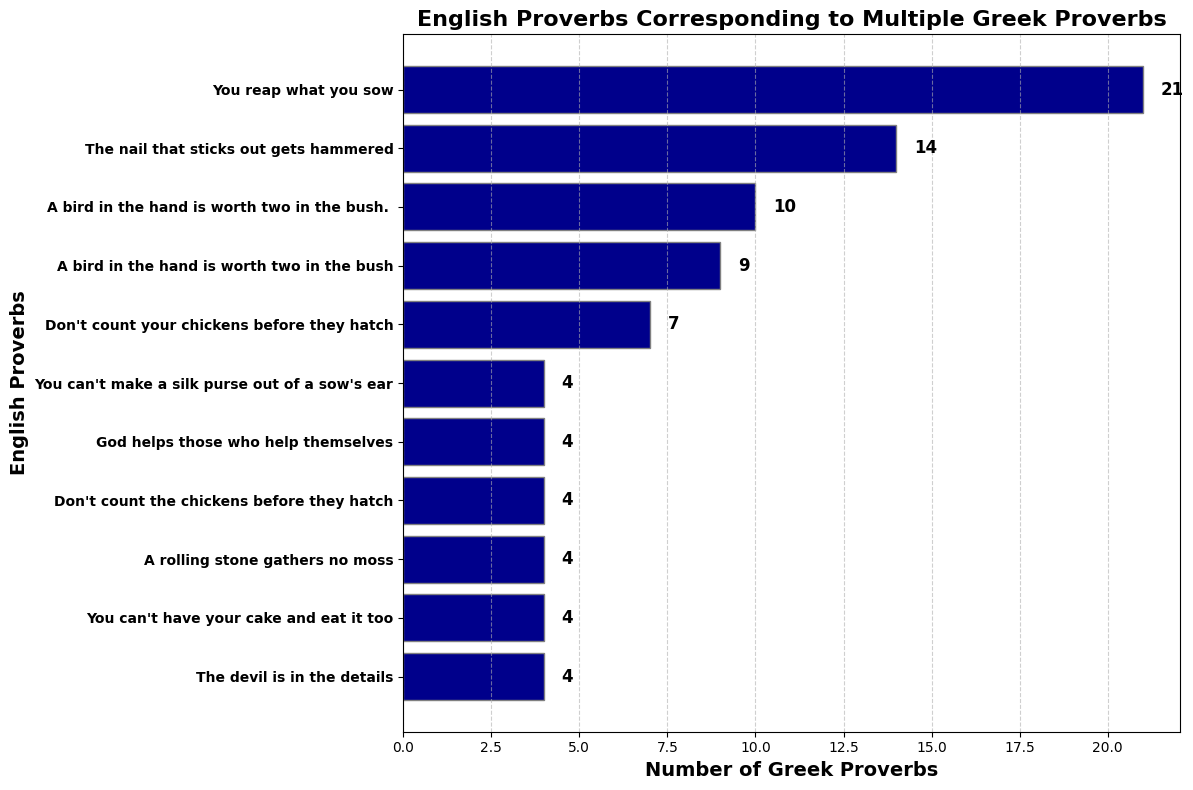

In [120]:
# we will plot our data
# Sort dictionary by value to ensure most frequent entries appear at the top
sorted_proverbs = dict(sorted(filtered_dict_value_counts_same_translation.items(), key=lambda item: item[1], reverse=True))

# Set a single color (dark blue) for all bars
dark_blue_color = 'darkblue'

# Create the horizontal bar chart
plt.figure(figsize=(12, 8))
bars = plt.barh(
    list(sorted_proverbs.keys()),
    list(sorted_proverbs.values()),
    color=dark_blue_color,
    edgecolor='grey'
)

# Add labels and title with larger font sizes
plt.xlabel("Number of Greek Proverbs", fontsize=14, fontweight='bold')
plt.ylabel("English Proverbs", fontsize=14, fontweight='bold')
plt.title("English Proverbs Corresponding to Multiple Greek Proverbs", fontsize=16, fontweight='bold')

# Make the y-axis tick labels bold
plt.gca().set_yticklabels(list(sorted_proverbs.keys()), fontweight='bold')

# Add a grid for readability
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Invert y-axis for better readability
plt.gca().invert_yaxis()

# Display values at the end of each bar
for bar in bars:
    plt.text(
        bar.get_width() + 0.5,
        bar.get_y() + bar.get_height()/2,
        f'{int(bar.get_width())}',
        va='center',
        fontsize=12,
        fontweight='bold',
        color='black'  # Set number color to black for contrast
    )

plt.tight_layout()
plt.show()

- We observe that the english proverb translated as `You reap what you sow` has been assigned as translation to the most greek provenrbs (total number `21`).
    - Greek Tranlations `θερίζεις ό,τι σπέρνεις`.
- The proverb "The nail that sticks out gets hammered" has been identified as the second most frequently matched translation across Greek proverbs.
    - Greek Translation : `Το καρφί που προεξέχει σφυρηλατείται`

- End of assignment 1, thank you for your time.